In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! git clone https://github.com/amirgholami/adahessian.git #original, if we want to modify something need to replace with a forked one

fatal: destination path 'adahessian' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Opti-ML') #to access other files
sys.path.insert(0,"adahessian/image_classification/")
#import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

In [ ]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.model_selection import KFold
#import torch_xla
#import torch_xla.core.xla_model as xm

from optimizer import set_parameter_requires_grad, initialize_model, train_and_test, test_model
from optim_adahessian import Adahessian

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# classic dataset
train_data=datasets.CIFAR10(root='data',train=True,download=True,transform=ToTensor())
test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Use a small subset of the data
# only error: 'Subset' object has no attribute 'targets'
if False: # put False if don't want it
  rng = np.random.default_rng()

  indices = rng.choice(len(train_data), 1000, replace=False)
  train_data = torch.utils.data.Subset(train_data, indices)

  indices = rng.choice(len(test_data), 200, replace=False)
  test_data = torch.utils.data.Subset(test_data, indices)

In [ ]:
print("train data of type:",type(train_data),"with length",len(train_data))
print("test data of type:",type(test_data),"with length",len(test_data))

train data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 50000
test data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 10000


In [ ]:
print("samples of type",type(train_data[0]),"with length",len(train_data[0]))
print("   - First entry: Image of type",type(train_data[0][0]),"and size",train_data[0][0].size())
print("   - Second entry: Label of type",type(train_data[0][1]))
print("The first sample:\n",train_data[0])

samples of type <class 'tuple'> with length 2
   - First entry: Image of type <class 'torch.Tensor'> and size torch.Size([3, 32, 32])
   - Second entry: Label of type <class 'int'>
The first sample:
 (tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627

In [ ]:
labels=np.unique(np.array(train_data.targets)) #don't seem to work for all datasets, like 'Subset' objects
print(labels)

[0 1 2 3 4 5 6 7 8 9]


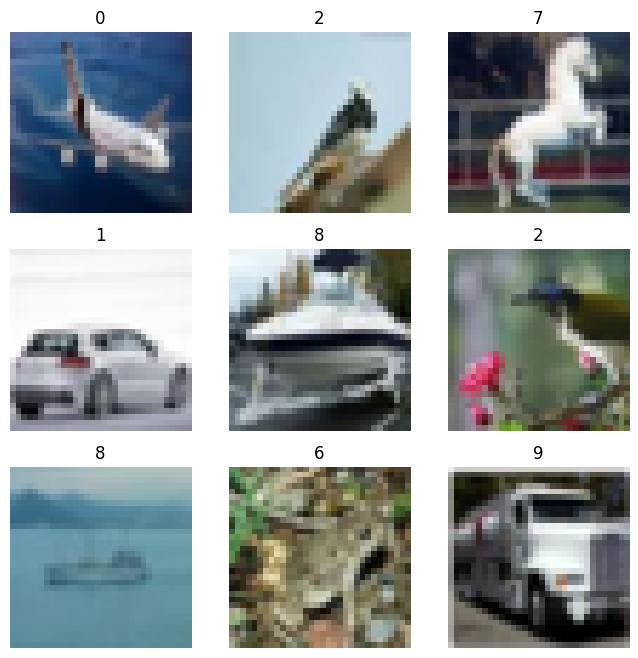

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

In [ ]:
batch_size = 256
seed = 100
k_folds = 5
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
#trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True) #change batch size with our need
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
kfold = KFold(n_splits=k_folds, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#device = xm.xla_device()

Using cuda device


In [ ]:
req_grad = True
use_pretrained=False
# Initialize the model for this run
model, input_size = initialize_model(use_pretrained=use_pretrained)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Send the model to GPU

model = model.to(device)
#model.load_state_dict(torch.load('./drive/MyDrive/Opti-ML/model_weights/model_adahessian.pt', map_location=lambda storage, loc: storage.cuda(0)))
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if req_grad:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

[image_classification/optim_adahessian.py](https://github.com/amirgholami/adahessian/blob/master/image_classification/optim_adahessian.py) on github:


```
"""Implements Adahessian algorithm.
    It has been proposed in `ADAHESSIAN: An Adaptive Second Order Optimizer for Machine Learning`.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 0.15)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-4)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        hessian_power (float, optional): Hessian power (default: 1). You can also try 0.5. For some tasks we found this to result in better performance.
        single_gpu (Bool, optional): Do you use distributed training or not "torch.nn.parallel.DistributedDataParallel" (default: True)
    """
```
- hessian_power is the "$k$"
- the weight decay is something like 0.1,...,0.0001


In [ ]:
lr=0.005 # default: 0.15
betas = (0.9, 0.999) # default: (0.9, 0.999)
weight_decay = 0.0005 # default: 0
hessian_power = 1 # default: 1
num_epoch = 360
momentum = 0.95

#optimizer_name = 'adahessian'
optimizer_name = 'SGD'

if optimizer_name == 'adahessian':
  optimizer = Adahessian(params_to_update, lr=lr, betas=betas, weight_decay=weight_decay,hessian_power=hessian_power) #set the parameter
elif optimizer_name == 'SGD':
  optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum, weight_decay=weight_decay)
elif optimizer_name == "adam":
  optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

scheduler_name = "multilr"
scheduler = None
if scheduler_name == "multilr":
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[180, 270], gamma=0.1)

path='./drive/MyDrive/Opti-ML/model_weights/model_0615_sgd'
train_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/train_loss_0615_0.txt'
train_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/train_acc_0615_0.txt'
val_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/val_loss_0615_0.txt'
val_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/val_acc_0615_0.txt'

The following cell takes ~180 second/epoch for batchsize=16

In [ ]:
#check the warning, nothing more on the adahessian git
best_k, train_loss, val_loss, train_acc, val_acc=train_and_test(model,train_data,batch_size,kfold,criterion,optimizer_name,scheduler,num_epoch,path,use_pretrained,lr,betas,momentum,weight_decay,hessian_power,device)
with open(train_loss_path, 'w') as fp:
    for item in train_loss:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(train_acc_path, 'w') as fp:
    for item in train_acc:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(val_loss_path, 'w') as fp:
    for item in val_loss:
        # write each item on a new line
        fp.write("%s\n" % item)
with open(val_acc_path, 'w') as fp:
    for item in val_acc:
        # write each item on a new line
        fp.write("%s\n" % item)

FOLD 0
--------------------------------


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/359
----------
Train Loss: 1.3214
Validation Loss: 1.2197


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 1/360 [00:26<2:37:05, 26.25s/it]

Train accuracy: 0.4798
Validation accuracy: 0.4583
Epoch 1/359
----------
Train Loss: 1.0083
Validation Loss: 1.0218


  1%|          | 2/360 [00:52<2:36:27, 26.22s/it]

Train accuracy: 0.5908
Validation accuracy: 0.5485
Epoch 2/359
----------
Train Loss: 0.8469
Validation Loss: 1.0413


  1%|          | 3/360 [01:18<2:35:21, 26.11s/it]

Train accuracy: 0.6102
Validation accuracy: 0.5507
Epoch 3/359
----------
Train Loss: 0.7204
Validation Loss: 0.9161


  1%|          | 4/360 [01:44<2:35:09, 26.15s/it]

Train accuracy: 0.7047
Validation accuracy: 0.6021
Epoch 4/359
----------
Train Loss: 0.6068
Validation Loss: 1.0646


  1%|▏         | 5/360 [02:10<2:34:26, 26.10s/it]

Train accuracy: 0.6618
Validation accuracy: 0.5696
Epoch 5/359
----------
Train Loss: 0.5235
Validation Loss: 0.8883


  2%|▏         | 6/360 [02:37<2:34:31, 26.19s/it]

Train accuracy: 0.8098
Validation accuracy: 0.6335
Epoch 6/359
----------
Train Loss: 0.4158
Validation Loss: 0.9362


  2%|▏         | 7/360 [03:03<2:33:57, 26.17s/it]

Train accuracy: 0.8375
Validation accuracy: 0.6398
Epoch 7/359
----------
Train Loss: 0.3483
Validation Loss: 1.1287


  2%|▏         | 8/360 [03:29<2:33:23, 26.15s/it]

Train accuracy: 0.7996
Validation accuracy: 0.6128
Epoch 8/359
----------
Train Loss: 0.3054
Validation Loss: 1.1017


  2%|▎         | 9/360 [03:55<2:33:01, 26.16s/it]

Train accuracy: 0.8447
Validation accuracy: 0.6318
Epoch 9/359
----------
Train Loss: 0.2428
Validation Loss: 1.1405


  3%|▎         | 10/360 [04:21<2:32:36, 26.16s/it]

Train accuracy: 0.8898
Validation accuracy: 0.6348
Epoch 10/359
----------
Train Loss: 0.1897
Validation Loss: 1.1711


  3%|▎         | 11/360 [04:47<2:31:49, 26.10s/it]

Train accuracy: 0.9121
Validation accuracy: 0.6498
Epoch 11/359
----------
Train Loss: 0.1724
Validation Loss: 1.1431


  3%|▎         | 12/360 [05:13<2:31:24, 26.11s/it]

Train accuracy: 0.9376
Validation accuracy: 0.6582
Epoch 12/359
----------
Train Loss: 0.1293
Validation Loss: 1.2975


  4%|▎         | 13/360 [05:40<2:31:31, 26.20s/it]

Train accuracy: 0.9346
Validation accuracy: 0.6469
Epoch 13/359
----------
Train Loss: 0.1195
Validation Loss: 1.2363


  4%|▍         | 14/360 [06:06<2:31:04, 26.20s/it]

Train accuracy: 0.9612
Validation accuracy: 0.6659
Epoch 14/359
----------
Train Loss: 0.0894
Validation Loss: 1.3694


  4%|▍         | 15/360 [06:32<2:30:24, 26.16s/it]

Train accuracy: 0.9447
Validation accuracy: 0.6495
Epoch 15/359
----------
Train Loss: 0.0734
Validation Loss: 1.4396


  4%|▍         | 16/360 [06:58<2:29:29, 26.08s/it]

Train accuracy: 0.9495
Validation accuracy: 0.6504
Epoch 16/359
----------
Train Loss: 0.0785
Validation Loss: 1.3322


  5%|▍         | 17/360 [07:24<2:29:11, 26.10s/it]

Train accuracy: 0.9674
Validation accuracy: 0.6643
Epoch 17/359
----------
Train Loss: 0.0745
Validation Loss: 1.3694


  5%|▌         | 18/360 [07:50<2:28:47, 26.10s/it]

Train accuracy: 0.9726
Validation accuracy: 0.6636
Epoch 18/359
----------
Train Loss: 0.0732
Validation Loss: 1.3366


  5%|▌         | 19/360 [08:16<2:28:24, 26.11s/it]

Train accuracy: 0.9732
Validation accuracy: 0.6683
Epoch 19/359
----------
Train Loss: 0.0604
Validation Loss: 1.4763


  6%|▌         | 20/360 [08:42<2:27:39, 26.06s/it]

Train accuracy: 0.9478
Validation accuracy: 0.6488
Epoch 20/359
----------
Train Loss: 0.0463
Validation Loss: 1.3705


  6%|▌         | 21/360 [09:08<2:27:37, 26.13s/it]

Train accuracy: 0.9842
Validation accuracy: 0.6738
Epoch 21/359
----------
Train Loss: 0.0409
Validation Loss: 1.4456


  6%|▌         | 22/360 [09:34<2:26:50, 26.07s/it]

Train accuracy: 0.9839
Validation accuracy: 0.6759
Epoch 22/359
----------
Train Loss: 0.0346
Validation Loss: 1.4218


  6%|▋         | 23/360 [10:00<2:26:18, 26.05s/it]

Train accuracy: 0.9849
Validation accuracy: 0.6768
Epoch 23/359
----------
Train Loss: 0.0357
Validation Loss: 1.4280


  7%|▋         | 24/360 [10:26<2:25:49, 26.04s/it]

Train accuracy: 0.9885
Validation accuracy: 0.6794
Epoch 24/359
----------
Train Loss: 0.0462
Validation Loss: 1.5544


  7%|▋         | 25/360 [10:53<2:25:40, 26.09s/it]

Train accuracy: 0.9640
Validation accuracy: 0.6613
Epoch 25/359
----------
Train Loss: 0.0540
Validation Loss: 1.4827


  7%|▋         | 26/360 [11:19<2:25:11, 26.08s/it]

Train accuracy: 0.9722
Validation accuracy: 0.6702
Epoch 26/359
----------
Train Loss: 0.0396
Validation Loss: 1.3705


  8%|▊         | 27/360 [11:44<2:24:14, 25.99s/it]

Train accuracy: 0.9898
Validation accuracy: 0.6813
Epoch 27/359
----------
Train Loss: 0.0347
Validation Loss: 1.3907


  8%|▊         | 28/360 [12:10<2:23:39, 25.96s/it]

Train accuracy: 0.9906
Validation accuracy: 0.6819
Epoch 28/359
----------
Train Loss: 0.0227
Validation Loss: 1.4092


  8%|▊         | 29/360 [12:36<2:23:05, 25.94s/it]

Train accuracy: 0.9944
Validation accuracy: 0.6914
Epoch 29/359
----------
Train Loss: 0.0281
Validation Loss: 1.5690


  8%|▊         | 30/360 [13:02<2:22:29, 25.91s/it]

Train accuracy: 0.9656
Validation accuracy: 0.6565
Epoch 30/359
----------
Train Loss: 0.0267
Validation Loss: 1.5315


  9%|▊         | 31/360 [13:28<2:21:49, 25.86s/it]

Train accuracy: 0.9865
Validation accuracy: 0.6765
Epoch 31/359
----------
Train Loss: 0.0347
Validation Loss: 1.4569


  9%|▉         | 32/360 [13:54<2:21:24, 25.87s/it]

Train accuracy: 0.9849
Validation accuracy: 0.6766
Epoch 32/359
----------
Train Loss: 0.0300
Validation Loss: 1.4654


  9%|▉         | 33/360 [14:19<2:20:40, 25.81s/it]

Train accuracy: 0.9905
Validation accuracy: 0.6763
Epoch 33/359
----------
Train Loss: 0.0249
Validation Loss: 1.5003


  9%|▉         | 34/360 [14:45<2:20:19, 25.83s/it]

Train accuracy: 0.9873
Validation accuracy: 0.6761
Epoch 34/359
----------
Train Loss: 0.0202
Validation Loss: 1.4669


 10%|▉         | 35/360 [15:11<2:19:49, 25.81s/it]

Train accuracy: 0.9928
Validation accuracy: 0.6822
Epoch 35/359
----------
Train Loss: 0.0217
Validation Loss: 1.5122


 10%|█         | 36/360 [15:37<2:19:13, 25.78s/it]

Train accuracy: 0.9863
Validation accuracy: 0.6721
Epoch 36/359
----------
Train Loss: 0.0151
Validation Loss: 1.4427


 10%|█         | 37/360 [16:03<2:18:54, 25.80s/it]

Train accuracy: 0.9925
Validation accuracy: 0.6874
Epoch 37/359
----------
Train Loss: 0.0219
Validation Loss: 1.5236


 11%|█         | 38/360 [16:28<2:18:24, 25.79s/it]

Train accuracy: 0.9862
Validation accuracy: 0.6762
Epoch 38/359
----------
Train Loss: 0.0276
Validation Loss: 1.5419


 11%|█         | 39/360 [16:54<2:17:49, 25.76s/it]

Train accuracy: 0.9848
Validation accuracy: 0.6682
Epoch 39/359
----------
Train Loss: 0.0279
Validation Loss: 1.4760


 11%|█         | 40/360 [17:20<2:17:05, 25.70s/it]

Train accuracy: 0.9902
Validation accuracy: 0.6836
Epoch 40/359
----------
Train Loss: 0.0381
Validation Loss: 1.5606


 11%|█▏        | 41/360 [17:45<2:17:04, 25.78s/it]

Train accuracy: 0.9691
Validation accuracy: 0.6687
Epoch 41/359
----------
Train Loss: 0.0425
Validation Loss: 1.4111


 12%|█▏        | 42/360 [18:11<2:16:30, 25.75s/it]

Train accuracy: 0.9893
Validation accuracy: 0.6836
Epoch 42/359
----------
Train Loss: 0.0333
Validation Loss: 1.4415


 12%|█▏        | 43/360 [18:37<2:16:00, 25.74s/it]

Train accuracy: 0.9839
Validation accuracy: 0.6703
Epoch 43/359
----------
Train Loss: 0.0251
Validation Loss: 1.4066


 12%|█▏        | 44/360 [19:03<2:15:27, 25.72s/it]

Train accuracy: 0.9937
Validation accuracy: 0.6857
Epoch 44/359
----------
Train Loss: 0.0179
Validation Loss: 1.4639


 12%|█▎        | 45/360 [19:28<2:14:54, 25.70s/it]

Train accuracy: 0.9873
Validation accuracy: 0.6763
Epoch 45/359
----------
Train Loss: 0.0127
Validation Loss: 1.4121


 13%|█▎        | 46/360 [19:54<2:14:38, 25.73s/it]

Train accuracy: 0.9973
Validation accuracy: 0.6896
Epoch 46/359
----------
Train Loss: 0.0099
Validation Loss: 1.4014


 13%|█▎        | 47/360 [20:20<2:14:11, 25.72s/it]

Train accuracy: 0.9970
Validation accuracy: 0.6952
Epoch 47/359
----------
Train Loss: 0.0076
Validation Loss: 1.3772


 13%|█▎        | 48/360 [20:45<2:13:40, 25.71s/it]

Train accuracy: 0.9992
Validation accuracy: 0.7043
Epoch 48/359
----------
Train Loss: 0.0027
Validation Loss: 1.3412


 14%|█▎        | 49/360 [21:11<2:13:21, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7091
Epoch 49/359
----------
Train Loss: 0.0007
Validation Loss: 1.3186


 14%|█▍        | 50/360 [21:37<2:12:53, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7121
Epoch 50/359
----------
Train Loss: 0.0004
Validation Loss: 1.3040


 14%|█▍        | 51/360 [22:03<2:12:26, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7147
Epoch 51/359
----------
Train Loss: 0.0003
Validation Loss: 1.2862


 14%|█▍        | 52/360 [22:28<2:11:56, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7149
Epoch 52/359
----------
Train Loss: 0.0002
Validation Loss: 1.2736


 15%|█▍        | 53/360 [22:54<2:11:18, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7139
Epoch 53/359
----------
Train Loss: 0.0002
Validation Loss: 1.2620


 15%|█▌        | 54/360 [23:20<2:11:06, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7135
Epoch 54/359
----------
Train Loss: 0.0002
Validation Loss: 1.2525


 15%|█▌        | 55/360 [23:45<2:10:28, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7141
Epoch 55/359
----------
Train Loss: 0.0003
Validation Loss: 1.2422


 16%|█▌        | 56/360 [24:11<2:09:58, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7174
Epoch 56/359
----------
Train Loss: 0.0002
Validation Loss: 1.2301


 16%|█▌        | 57/360 [24:37<2:09:45, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7172
Epoch 57/359
----------
Train Loss: 0.0002
Validation Loss: 1.2141


 16%|█▌        | 58/360 [25:02<2:09:13, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7142
Epoch 58/359
----------
Train Loss: 0.0002
Validation Loss: 1.2056


 16%|█▋        | 59/360 [25:28<2:08:59, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7169
Epoch 59/359
----------
Train Loss: 0.0002
Validation Loss: 1.1917


 17%|█▋        | 60/360 [25:54<2:08:31, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7170
Epoch 60/359
----------
Train Loss: 0.0002
Validation Loss: 1.1839


 17%|█▋        | 61/360 [26:19<2:07:59, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7171
Epoch 61/359
----------
Train Loss: 0.0002
Validation Loss: 1.1725


 17%|█▋        | 62/360 [26:45<2:07:30, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7173
Epoch 62/359
----------
Train Loss: 0.0002
Validation Loss: 1.1681


 18%|█▊        | 63/360 [27:11<2:07:14, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7170
Epoch 63/359
----------
Train Loss: 0.0002
Validation Loss: 1.1523


 18%|█▊        | 64/360 [27:36<2:06:39, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7175
Epoch 64/359
----------
Train Loss: 0.0002
Validation Loss: 1.1477


 18%|█▊        | 65/360 [28:02<2:06:13, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7192
Epoch 65/359
----------
Train Loss: 0.0002
Validation Loss: 1.1394


 18%|█▊        | 66/360 [28:28<2:06:00, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7179
Epoch 66/359
----------
Train Loss: 0.0002
Validation Loss: 1.1305


 19%|█▊        | 67/360 [28:54<2:05:29, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7159
Epoch 67/359
----------
Train Loss: 0.0003
Validation Loss: 1.1248


 19%|█▉        | 68/360 [29:19<2:05:17, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7188
Epoch 68/359
----------
Train Loss: 0.0002
Validation Loss: 1.1159


 19%|█▉        | 69/360 [29:45<2:04:40, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7197
Epoch 69/359
----------
Train Loss: 0.0003
Validation Loss: 1.1132


 19%|█▉        | 70/360 [30:11<2:04:29, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7203
Epoch 70/359
----------
Train Loss: 0.0003
Validation Loss: 1.1042


 20%|█▉        | 71/360 [30:37<2:03:54, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7183
Epoch 71/359
----------
Train Loss: 0.0003
Validation Loss: 1.0952


 20%|██        | 72/360 [31:02<2:03:20, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7204
Epoch 72/359
----------
Train Loss: 0.0003
Validation Loss: 1.0975


 20%|██        | 73/360 [31:28<2:02:56, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7188
Epoch 73/359
----------
Train Loss: 0.0003
Validation Loss: 1.0865


 21%|██        | 74/360 [31:54<2:02:46, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7196
Epoch 74/359
----------
Train Loss: 0.0003
Validation Loss: 1.0816


 21%|██        | 75/360 [32:20<2:02:23, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7187
Epoch 75/359
----------
Train Loss: 0.0003
Validation Loss: 1.0722


 21%|██        | 76/360 [32:45<2:02:00, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7202
Epoch 76/359
----------
Train Loss: 0.0003
Validation Loss: 1.0673


 21%|██▏       | 77/360 [33:11<2:01:29, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7192
Epoch 77/359
----------
Train Loss: 0.0003
Validation Loss: 1.0631


 22%|██▏       | 78/360 [33:37<2:00:42, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7185
Epoch 78/359
----------
Train Loss: 0.0003
Validation Loss: 1.0565


 22%|██▏       | 79/360 [34:02<2:00:30, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7198
Epoch 79/359
----------
Train Loss: 0.0003
Validation Loss: 1.0544


 22%|██▏       | 80/360 [34:28<2:00:09, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7190
Epoch 80/359
----------
Train Loss: 0.0003
Validation Loss: 1.0484


 22%|██▎       | 81/360 [34:54<1:59:33, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7190
Epoch 81/359
----------
Train Loss: 0.0003
Validation Loss: 1.0429


 23%|██▎       | 82/360 [35:20<1:59:09, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7183
Epoch 82/359
----------
Train Loss: 0.0003
Validation Loss: 1.0431


 23%|██▎       | 83/360 [35:45<1:58:46, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7183
Epoch 83/359
----------
Train Loss: 0.0003
Validation Loss: 1.0392


 23%|██▎       | 84/360 [36:11<1:58:24, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7177
Epoch 84/359
----------
Train Loss: 0.0003
Validation Loss: 1.0321


 24%|██▎       | 85/360 [36:37<1:57:57, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7207
Epoch 85/359
----------
Train Loss: 0.0003
Validation Loss: 1.0303


 24%|██▍       | 86/360 [37:03<1:57:31, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7193
Epoch 86/359
----------
Train Loss: 0.0003
Validation Loss: 1.0237


 24%|██▍       | 87/360 [37:28<1:57:14, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7193
Epoch 87/359
----------
Train Loss: 0.0003
Validation Loss: 1.0252


 24%|██▍       | 88/360 [37:54<1:56:54, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7182
Epoch 88/359
----------
Train Loss: 0.0003
Validation Loss: 1.0195


 25%|██▍       | 89/360 [38:20<1:56:26, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7180
Epoch 89/359
----------
Train Loss: 0.0003
Validation Loss: 1.0196


 25%|██▌       | 90/360 [38:46<1:55:47, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7205
Epoch 90/359
----------
Train Loss: 0.0004
Validation Loss: 1.0142


 25%|██▌       | 91/360 [39:11<1:55:27, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7204
Epoch 91/359
----------
Train Loss: 0.0004
Validation Loss: 1.0091


 26%|██▌       | 92/360 [39:37<1:54:47, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7210
Epoch 92/359
----------
Train Loss: 0.0004
Validation Loss: 1.0105


 26%|██▌       | 93/360 [40:03<1:54:28, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7214
Epoch 93/359
----------
Train Loss: 0.0004
Validation Loss: 1.0053


 26%|██▌       | 94/360 [40:29<1:54:12, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7214
Epoch 94/359
----------
Train Loss: 0.0004
Validation Loss: 0.9984


 26%|██▋       | 95/360 [40:54<1:53:42, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7214
Epoch 95/359
----------
Train Loss: 0.0004
Validation Loss: 0.9984


 27%|██▋       | 96/360 [41:20<1:53:24, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7207
Epoch 96/359
----------
Train Loss: 0.0004
Validation Loss: 0.9990


 27%|██▋       | 97/360 [41:46<1:52:52, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7210
Epoch 97/359
----------
Train Loss: 0.0004
Validation Loss: 0.9976


 27%|██▋       | 98/360 [42:12<1:52:33, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7212
Epoch 98/359
----------
Train Loss: 0.0013
Validation Loss: 1.0395


 28%|██▊       | 99/360 [42:37<1:52:04, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7118
Epoch 99/359
----------
Train Loss: 0.0007
Validation Loss: 1.0145


 28%|██▊       | 100/360 [43:03<1:51:45, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7175
Epoch 100/359
----------
Train Loss: 0.0005
Validation Loss: 1.0137


 28%|██▊       | 101/360 [43:29<1:51:28, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7185
Epoch 101/359
----------
Train Loss: 0.0004
Validation Loss: 1.0059


 28%|██▊       | 102/360 [43:55<1:51:12, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7205
Epoch 102/359
----------
Train Loss: 0.0004
Validation Loss: 1.0063


 29%|██▊       | 103/360 [44:21<1:50:31, 25.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7222
Epoch 103/359
----------
Train Loss: 0.0004
Validation Loss: 1.0005


 29%|██▉       | 104/360 [44:46<1:49:55, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7232
Epoch 104/359
----------
Train Loss: 0.0004
Validation Loss: 1.0041


 29%|██▉       | 105/360 [45:12<1:49:29, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7215
Epoch 105/359
----------
Train Loss: 0.0004
Validation Loss: 0.9985


 29%|██▉       | 106/360 [45:38<1:49:09, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7196
Epoch 106/359
----------
Train Loss: 0.0004
Validation Loss: 1.0016


 30%|██▉       | 107/360 [46:04<1:48:39, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7197
Epoch 107/359
----------
Train Loss: 0.0004
Validation Loss: 0.9931


 30%|███       | 108/360 [46:30<1:48:12, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7199
Epoch 108/359
----------
Train Loss: 0.0004
Validation Loss: 0.9900


 30%|███       | 109/360 [46:55<1:47:53, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7216
Epoch 109/359
----------
Train Loss: 0.0004
Validation Loss: 0.9906


 31%|███       | 110/360 [47:21<1:47:19, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7211
Epoch 110/359
----------
Train Loss: 0.0004
Validation Loss: 0.9838


 31%|███       | 111/360 [47:47<1:46:44, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7215
Epoch 111/359
----------
Train Loss: 0.0004
Validation Loss: 0.9829


 31%|███       | 112/360 [48:12<1:46:13, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7214
Epoch 112/359
----------
Train Loss: 0.0004
Validation Loss: 0.9812


 31%|███▏      | 113/360 [48:38<1:45:45, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7208
Epoch 113/359
----------
Train Loss: 0.0004
Validation Loss: 0.9822


 32%|███▏      | 114/360 [49:04<1:45:33, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7213
Epoch 114/359
----------
Train Loss: 0.0004
Validation Loss: 0.9801


 32%|███▏      | 115/360 [49:30<1:45:05, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7231
Epoch 115/359
----------
Train Loss: 0.0004
Validation Loss: 0.9815


 32%|███▏      | 116/360 [49:55<1:44:28, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7211
Epoch 116/359
----------
Train Loss: 0.0004
Validation Loss: 0.9805


 32%|███▎      | 117/360 [50:21<1:44:17, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7215
Epoch 117/359
----------
Train Loss: 0.0007
Validation Loss: 0.9886


 33%|███▎      | 118/360 [50:47<1:43:51, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7183
Epoch 118/359
----------
Train Loss: 0.0005
Validation Loss: 0.9862


 33%|███▎      | 119/360 [51:12<1:43:16, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7202
Epoch 119/359
----------
Train Loss: 0.0004
Validation Loss: 0.9791


 33%|███▎      | 120/360 [51:38<1:42:59, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7203
Epoch 120/359
----------
Train Loss: 0.0004
Validation Loss: 0.9831


 34%|███▎      | 121/360 [52:04<1:42:17, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7197
Epoch 121/359
----------
Train Loss: 0.0004
Validation Loss: 0.9777


 34%|███▍      | 122/360 [52:30<1:42:03, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7214
Epoch 122/359
----------
Train Loss: 0.0004
Validation Loss: 0.9769


 34%|███▍      | 123/360 [52:55<1:41:32, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7208
Epoch 123/359
----------
Train Loss: 0.0004
Validation Loss: 0.9746


 34%|███▍      | 124/360 [53:21<1:41:03, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7202
Epoch 124/359
----------
Train Loss: 0.0005
Validation Loss: 0.9806


 35%|███▍      | 125/360 [53:47<1:40:42, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7174
Epoch 125/359
----------
Train Loss: 0.0004
Validation Loss: 0.9793


 35%|███▌      | 126/360 [54:12<1:40:13, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7191
Epoch 126/359
----------
Train Loss: 0.0004
Validation Loss: 0.9765


 35%|███▌      | 127/360 [54:38<1:39:44, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7192
Epoch 127/359
----------
Train Loss: 0.0004
Validation Loss: 0.9756


 36%|███▌      | 128/360 [55:04<1:39:13, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7195
Epoch 128/359
----------
Train Loss: 0.0004
Validation Loss: 0.9740


 36%|███▌      | 129/360 [55:30<1:39:04, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7198
Epoch 129/359
----------
Train Loss: 0.0142
Validation Loss: 1.5266


 36%|███▌      | 130/360 [55:55<1:38:36, 25.73s/it]

Train accuracy: 0.7813
Validation accuracy: 0.5811
Epoch 130/359
----------
Train Loss: 0.5977
Validation Loss: 0.8249


 36%|███▋      | 131/360 [56:21<1:38:14, 25.74s/it]

Train accuracy: 0.7787
Validation accuracy: 0.6522
Epoch 131/359
----------
Train Loss: 0.3652
Validation Loss: 0.9035


 37%|███▋      | 132/360 [56:47<1:37:44, 25.72s/it]

Train accuracy: 0.8346
Validation accuracy: 0.6553
Epoch 132/359
----------
Train Loss: 0.2578
Validation Loss: 0.9321


 37%|███▋      | 133/360 [57:13<1:37:37, 25.80s/it]

Train accuracy: 0.8763
Validation accuracy: 0.6572
Epoch 133/359
----------
Train Loss: 0.1913
Validation Loss: 1.0189


 37%|███▋      | 134/360 [57:38<1:37:05, 25.78s/it]

Train accuracy: 0.8917
Validation accuracy: 0.6591
Epoch 134/359
----------
Train Loss: 0.1489
Validation Loss: 0.9415


 38%|███▊      | 135/360 [58:04<1:36:32, 25.74s/it]

Train accuracy: 0.9480
Validation accuracy: 0.6923
Epoch 135/359
----------
Train Loss: 0.1230
Validation Loss: 1.0257


 38%|███▊      | 136/360 [58:30<1:36:03, 25.73s/it]

Train accuracy: 0.9458
Validation accuracy: 0.6901
Epoch 136/359
----------
Train Loss: 0.1127
Validation Loss: 1.0050


 38%|███▊      | 137/360 [58:56<1:35:49, 25.78s/it]

Train accuracy: 0.9634
Validation accuracy: 0.7007
Epoch 137/359
----------
Train Loss: 0.0898
Validation Loss: 1.0268


 38%|███▊      | 138/360 [59:22<1:35:28, 25.81s/it]

Train accuracy: 0.9560
Validation accuracy: 0.6940
Epoch 138/359
----------
Train Loss: 0.0597
Validation Loss: 1.1047


 39%|███▊      | 139/360 [59:47<1:34:58, 25.79s/it]

Train accuracy: 0.9620
Validation accuracy: 0.6862
Epoch 139/359
----------
Train Loss: 0.0466
Validation Loss: 1.0717


 39%|███▉      | 140/360 [1:00:13<1:34:20, 25.73s/it]

Train accuracy: 0.9811
Validation accuracy: 0.7084
Epoch 140/359
----------
Train Loss: 0.0507
Validation Loss: 1.0678


 39%|███▉      | 141/360 [1:00:39<1:33:58, 25.75s/it]

Train accuracy: 0.9790
Validation accuracy: 0.7076
Epoch 141/359
----------
Train Loss: 0.0418
Validation Loss: 1.1023


 39%|███▉      | 142/360 [1:01:05<1:33:41, 25.79s/it]

Train accuracy: 0.9796
Validation accuracy: 0.7082
Epoch 142/359
----------
Train Loss: 0.0308
Validation Loss: 1.0873


 40%|███▉      | 143/360 [1:01:30<1:33:15, 25.79s/it]

Train accuracy: 0.9881
Validation accuracy: 0.7118
Epoch 143/359
----------
Train Loss: 0.0307
Validation Loss: 1.1033


 40%|████      | 144/360 [1:01:56<1:32:46, 25.77s/it]

Train accuracy: 0.9863
Validation accuracy: 0.7106
Epoch 144/359
----------
Train Loss: 0.0346
Validation Loss: 1.1853


 40%|████      | 145/360 [1:02:22<1:32:19, 25.76s/it]

Train accuracy: 0.9767
Validation accuracy: 0.6949
Epoch 145/359
----------
Train Loss: 0.0315
Validation Loss: 1.0952


 41%|████      | 146/360 [1:02:48<1:31:57, 25.78s/it]

Train accuracy: 0.9929
Validation accuracy: 0.7158
Epoch 146/359
----------
Train Loss: 0.0334
Validation Loss: 1.1055


 41%|████      | 147/360 [1:03:13<1:31:20, 25.73s/it]

Train accuracy: 0.9877
Validation accuracy: 0.7073
Epoch 147/359
----------
Train Loss: 0.0253
Validation Loss: 1.1562


 41%|████      | 148/360 [1:03:39<1:31:02, 25.76s/it]

Train accuracy: 0.9888
Validation accuracy: 0.7090
Epoch 148/359
----------
Train Loss: 0.0230
Validation Loss: 1.1639


 41%|████▏     | 149/360 [1:04:05<1:30:41, 25.79s/it]

Train accuracy: 0.9883
Validation accuracy: 0.7052
Epoch 149/359
----------
Train Loss: 0.0191
Validation Loss: 1.1404


 42%|████▏     | 150/360 [1:04:31<1:30:11, 25.77s/it]

Train accuracy: 0.9913
Validation accuracy: 0.7128
Epoch 150/359
----------
Train Loss: 0.0172
Validation Loss: 1.2116


 42%|████▏     | 151/360 [1:04:56<1:29:39, 25.74s/it]

Train accuracy: 0.9870
Validation accuracy: 0.7071
Epoch 151/359
----------
Train Loss: 0.0226
Validation Loss: 1.2269


 42%|████▏     | 152/360 [1:05:22<1:29:18, 25.76s/it]

Train accuracy: 0.9863
Validation accuracy: 0.7032
Epoch 152/359
----------
Train Loss: 0.0242
Validation Loss: 1.2301


 42%|████▎     | 153/360 [1:05:48<1:28:51, 25.75s/it]

Train accuracy: 0.9794
Validation accuracy: 0.6924
Epoch 153/359
----------
Train Loss: 0.0249
Validation Loss: 1.1682


 43%|████▎     | 154/360 [1:06:13<1:28:14, 25.70s/it]

Train accuracy: 0.9879
Validation accuracy: 0.7125
Epoch 154/359
----------
Train Loss: 0.0246
Validation Loss: 1.1736


 43%|████▎     | 155/360 [1:06:39<1:27:57, 25.74s/it]

Train accuracy: 0.9896
Validation accuracy: 0.7057
Epoch 155/359
----------
Train Loss: 0.0194
Validation Loss: 1.1399


 43%|████▎     | 156/360 [1:07:05<1:27:26, 25.72s/it]

Train accuracy: 0.9942
Validation accuracy: 0.7171
Epoch 156/359
----------
Train Loss: 0.0143
Validation Loss: 1.1516


 44%|████▎     | 157/360 [1:07:31<1:27:12, 25.78s/it]

Train accuracy: 0.9953
Validation accuracy: 0.7146
Epoch 157/359
----------
Train Loss: 0.0100
Validation Loss: 1.1205


 44%|████▍     | 158/360 [1:07:57<1:26:43, 25.76s/it]

Train accuracy: 0.9985
Validation accuracy: 0.7241
Epoch 158/359
----------
Train Loss: 0.0078
Validation Loss: 1.1237


 44%|████▍     | 159/360 [1:08:22<1:26:23, 25.79s/it]

Train accuracy: 0.9984
Validation accuracy: 0.7245
Epoch 159/359
----------
Train Loss: 0.0049
Validation Loss: 1.0995


 44%|████▍     | 160/360 [1:08:48<1:25:51, 25.76s/it]

Train accuracy: 0.9996
Validation accuracy: 0.7278
Epoch 160/359
----------
Train Loss: 0.0019
Validation Loss: 1.0696


 45%|████▍     | 161/360 [1:09:14<1:25:25, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7346
Epoch 161/359
----------
Train Loss: 0.0009
Validation Loss: 1.0363


 45%|████▌     | 162/360 [1:09:40<1:25:01, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7372
Epoch 162/359
----------
Train Loss: 0.0004
Validation Loss: 1.0228


 45%|████▌     | 163/360 [1:10:05<1:24:26, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7391
Epoch 163/359
----------
Train Loss: 0.0003
Validation Loss: 1.0125


 46%|████▌     | 164/360 [1:10:31<1:23:57, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7399
Epoch 164/359
----------
Train Loss: 0.0003
Validation Loss: 1.0055


 46%|████▌     | 165/360 [1:10:57<1:23:25, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7410
Epoch 165/359
----------
Train Loss: 0.0003
Validation Loss: 0.9944


 46%|████▌     | 166/360 [1:11:22<1:23:06, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7421
Epoch 166/359
----------
Train Loss: 0.0003
Validation Loss: 0.9888


 46%|████▋     | 167/360 [1:11:48<1:22:36, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7425
Epoch 167/359
----------
Train Loss: 0.0003
Validation Loss: 0.9811


 47%|████▋     | 168/360 [1:12:14<1:22:03, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7437
Epoch 168/359
----------
Train Loss: 0.0003
Validation Loss: 0.9735


 47%|████▋     | 169/360 [1:12:39<1:21:35, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7436
Epoch 169/359
----------
Train Loss: 0.0003
Validation Loss: 0.9627


 47%|████▋     | 170/360 [1:13:05<1:21:21, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7430
Epoch 170/359
----------
Train Loss: 0.0003
Validation Loss: 0.9563


 48%|████▊     | 171/360 [1:13:31<1:21:05, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7444
Epoch 171/359
----------
Train Loss: 0.0003
Validation Loss: 0.9536


 48%|████▊     | 172/360 [1:13:57<1:20:42, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7459
Epoch 172/359
----------
Train Loss: 0.0003
Validation Loss: 0.9442


 48%|████▊     | 173/360 [1:14:22<1:20:17, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7433
Epoch 173/359
----------
Train Loss: 0.0003
Validation Loss: 0.9370


 48%|████▊     | 174/360 [1:14:48<1:19:39, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7443
Epoch 174/359
----------
Train Loss: 0.0003
Validation Loss: 0.9350


 49%|████▊     | 175/360 [1:15:14<1:19:22, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7438
Epoch 175/359
----------
Train Loss: 0.0003
Validation Loss: 0.9301


 49%|████▉     | 176/360 [1:15:40<1:19:06, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7448
Epoch 176/359
----------
Train Loss: 0.0003
Validation Loss: 0.9184


 49%|████▉     | 177/360 [1:16:05<1:18:34, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7444
Epoch 177/359
----------
Train Loss: 0.0004
Validation Loss: 0.9208


 49%|████▉     | 178/360 [1:16:31<1:18:11, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7445
Epoch 178/359
----------
Train Loss: 0.0004
Validation Loss: 0.9170


 50%|████▉     | 179/360 [1:16:57<1:17:37, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7450
Epoch 179/359
----------
Train Loss: 0.0004
Validation Loss: 0.9084


 50%|█████     | 180/360 [1:17:23<1:17:09, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7461
Epoch 180/359
----------
Train Loss: 0.0004
Validation Loss: 0.9046


 50%|█████     | 181/360 [1:17:48<1:16:41, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7455
Epoch 181/359
----------
Train Loss: 0.0004
Validation Loss: 0.9002


 51%|█████     | 182/360 [1:18:14<1:16:26, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7463
Epoch 182/359
----------
Train Loss: 0.0004
Validation Loss: 0.8994


 51%|█████     | 183/360 [1:18:40<1:16:13, 25.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7476
Epoch 183/359
----------
Train Loss: 0.0004
Validation Loss: 0.8916


 51%|█████     | 184/360 [1:19:06<1:15:48, 25.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7471
Epoch 184/359
----------
Train Loss: 0.0004
Validation Loss: 0.8935


 51%|█████▏    | 185/360 [1:19:32<1:15:26, 25.87s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7477
Epoch 185/359
----------
Train Loss: 0.0004
Validation Loss: 0.8867


 52%|█████▏    | 186/360 [1:19:58<1:15:07, 25.91s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7461
Epoch 186/359
----------
Train Loss: 0.0004
Validation Loss: 0.8836


 52%|█████▏    | 187/360 [1:20:24<1:14:31, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7473
Epoch 187/359
----------
Train Loss: 0.0005
Validation Loss: 0.8888


 52%|█████▏    | 188/360 [1:20:49<1:13:53, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7446
Epoch 188/359
----------
Train Loss: 0.0005
Validation Loss: 0.8846


 52%|█████▎    | 189/360 [1:21:15<1:13:21, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7464
Epoch 189/359
----------
Train Loss: 0.0005
Validation Loss: 0.8851


 53%|█████▎    | 190/360 [1:21:41<1:13:11, 25.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7471
Epoch 190/359
----------
Train Loss: 0.0004
Validation Loss: 0.8783


 53%|█████▎    | 191/360 [1:22:07<1:12:42, 25.81s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7474
Epoch 191/359
----------
Train Loss: 0.0004
Validation Loss: 0.8791


 53%|█████▎    | 192/360 [1:22:33<1:12:22, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7477
Epoch 192/359
----------
Train Loss: 0.0004
Validation Loss: 0.8784


 54%|█████▎    | 193/360 [1:22:58<1:11:50, 25.81s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7474
Epoch 193/359
----------
Train Loss: 0.0005
Validation Loss: 0.8764


 54%|█████▍    | 194/360 [1:23:24<1:11:09, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7474
Epoch 194/359
----------
Train Loss: 0.0005
Validation Loss: 0.8742


 54%|█████▍    | 195/360 [1:23:50<1:10:55, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7478
Epoch 195/359
----------
Train Loss: 0.0005
Validation Loss: 0.8700


 54%|█████▍    | 196/360 [1:24:16<1:10:31, 25.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7482
Epoch 196/359
----------
Train Loss: 0.0005
Validation Loss: 0.8705


 55%|█████▍    | 197/360 [1:24:41<1:10:08, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7478
Epoch 197/359
----------
Train Loss: 0.0005
Validation Loss: 0.8678


 55%|█████▌    | 198/360 [1:25:08<1:09:52, 25.88s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7498
Epoch 198/359
----------
Train Loss: 0.0005
Validation Loss: 0.8678


 55%|█████▌    | 199/360 [1:25:33<1:09:22, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7475
Epoch 199/359
----------
Train Loss: 0.0007
Validation Loss: 0.8823


 56%|█████▌    | 200/360 [1:25:59<1:08:50, 25.81s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7431
Epoch 200/359
----------
Train Loss: 0.0005
Validation Loss: 0.8757


 56%|█████▌    | 201/360 [1:26:25<1:08:25, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7462
Epoch 201/359
----------
Train Loss: 0.0005
Validation Loss: 0.8694


 56%|█████▌    | 202/360 [1:26:51<1:07:58, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7473
Epoch 202/359
----------
Train Loss: 0.0005
Validation Loss: 0.8710


 56%|█████▋    | 203/360 [1:27:16<1:07:33, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7484
Epoch 203/359
----------
Train Loss: 0.0005
Validation Loss: 0.8735


 57%|█████▋    | 204/360 [1:27:42<1:07:07, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7487
Epoch 204/359
----------
Train Loss: 0.0005
Validation Loss: 0.8717


 57%|█████▋    | 205/360 [1:28:08<1:06:35, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7473
Epoch 205/359
----------
Train Loss: 0.0005
Validation Loss: 0.8713


 57%|█████▋    | 206/360 [1:28:34<1:06:20, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7462
Epoch 206/359
----------
Train Loss: 0.0005
Validation Loss: 0.8700


 57%|█████▊    | 207/360 [1:29:00<1:05:52, 25.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7466
Epoch 207/359
----------
Train Loss: 0.0005
Validation Loss: 0.8703


 58%|█████▊    | 208/360 [1:29:26<1:05:28, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7477
Epoch 208/359
----------
Train Loss: 0.0005
Validation Loss: 0.8701


 58%|█████▊    | 209/360 [1:29:51<1:04:56, 25.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7475
Epoch 209/359
----------
Train Loss: 0.0005
Validation Loss: 0.8697


 58%|█████▊    | 210/360 [1:30:17<1:04:27, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7485
Epoch 210/359
----------
Train Loss: 0.0005
Validation Loss: 0.8768


 59%|█████▊    | 211/360 [1:30:43<1:04:02, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7484
Epoch 211/359
----------
Train Loss: 0.0005
Validation Loss: 0.8728


 59%|█████▉    | 212/360 [1:31:09<1:03:32, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7481
Epoch 212/359
----------
Train Loss: 0.0005
Validation Loss: 0.8716


 59%|█████▉    | 213/360 [1:31:34<1:03:08, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7489
Epoch 213/359
----------
Train Loss: 0.0005
Validation Loss: 0.8730


 59%|█████▉    | 214/360 [1:32:00<1:02:45, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7471
Epoch 214/359
----------
Train Loss: 0.0005
Validation Loss: 0.8722


 60%|█████▉    | 215/360 [1:32:26<1:02:19, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7483
Epoch 215/359
----------
Train Loss: 0.0005
Validation Loss: 0.8735


 60%|██████    | 216/360 [1:32:52<1:01:45, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7462
Epoch 216/359
----------
Train Loss: 0.0005
Validation Loss: 0.8776


 60%|██████    | 217/360 [1:33:17<1:01:23, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7456
Epoch 217/359
----------
Train Loss: 0.0005
Validation Loss: 0.8793


 61%|██████    | 218/360 [1:33:43<1:01:05, 25.81s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7459
Epoch 218/359
----------
Train Loss: 0.0005
Validation Loss: 0.8758


 61%|██████    | 219/360 [1:34:09<1:00:34, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7472
Epoch 219/359
----------
Train Loss: 0.0005
Validation Loss: 0.8770


 61%|██████    | 220/360 [1:34:35<1:00:08, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7464
Epoch 220/359
----------
Train Loss: 0.0005
Validation Loss: 0.8758


 61%|██████▏   | 221/360 [1:35:00<59:37, 25.73s/it]  

Train accuracy: 1.0000
Validation accuracy: 0.7469
Epoch 221/359
----------
Train Loss: 0.0005
Validation Loss: 0.8823


 62%|██████▏   | 222/360 [1:35:26<59:12, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7456
Epoch 222/359
----------
Train Loss: 0.0005
Validation Loss: 0.8816


 62%|██████▏   | 223/360 [1:35:52<58:58, 25.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7472
Epoch 223/359
----------
Train Loss: 0.0005
Validation Loss: 0.8825


 62%|██████▏   | 224/360 [1:36:18<58:21, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7455
Epoch 224/359
----------
Train Loss: 0.0005
Validation Loss: 0.8878


 62%|██████▎   | 225/360 [1:36:44<57:56, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7472
Epoch 225/359
----------
Train Loss: 0.0008
Validation Loss: 0.9168


 63%|██████▎   | 226/360 [1:37:09<57:27, 25.73s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7408
Epoch 226/359
----------
Train Loss: 0.0006
Validation Loss: 0.9005


 63%|██████▎   | 227/360 [1:37:35<57:10, 25.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7457
Epoch 227/359
----------
Train Loss: 0.0006
Validation Loss: 0.9011


 63%|██████▎   | 228/360 [1:38:01<56:44, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7445
Epoch 228/359
----------
Train Loss: 0.0005
Validation Loss: 0.8982


 64%|██████▎   | 229/360 [1:38:27<56:17, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7463
Epoch 229/359
----------
Train Loss: 0.0005
Validation Loss: 0.8965


 64%|██████▍   | 230/360 [1:38:52<55:48, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7468
Epoch 230/359
----------
Train Loss: 0.0006
Validation Loss: 0.9064


 64%|██████▍   | 231/360 [1:39:18<55:23, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7443
Epoch 231/359
----------
Train Loss: 0.0005
Validation Loss: 0.9062


 64%|██████▍   | 232/360 [1:39:44<54:56, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7452
Epoch 232/359
----------
Train Loss: 0.0005
Validation Loss: 0.9031


 65%|██████▍   | 233/360 [1:40:10<54:30, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7449
Epoch 233/359
----------
Train Loss: 0.0005
Validation Loss: 0.9017


 65%|██████▌   | 234/360 [1:40:36<54:12, 25.81s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7446
Epoch 234/359
----------
Train Loss: 0.0005
Validation Loss: 0.9086


 65%|██████▌   | 235/360 [1:41:01<53:36, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7437
Epoch 235/359
----------
Train Loss: 0.0005
Validation Loss: 0.9060


 66%|██████▌   | 236/360 [1:41:27<52:59, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7453
Epoch 236/359
----------
Train Loss: 0.0005
Validation Loss: 0.9069


 66%|██████▌   | 237/360 [1:41:52<52:22, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7448
Epoch 237/359
----------
Train Loss: 0.0006
Validation Loss: 0.9130


 66%|██████▌   | 238/360 [1:42:17<51:44, 25.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7461
Epoch 238/359
----------
Train Loss: 0.0006
Validation Loss: 0.9194


 66%|██████▋   | 239/360 [1:42:43<51:20, 25.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7437
Epoch 239/359
----------
Train Loss: 0.4514
Validation Loss: 0.7584


 67%|██████▋   | 240/360 [1:43:08<50:50, 25.42s/it]

Train accuracy: 0.8063
Validation accuracy: 0.6837
Epoch 240/359
----------
Train Loss: 0.3810
Validation Loss: 0.9381


 67%|██████▋   | 241/360 [1:43:33<50:25, 25.43s/it]

Train accuracy: 0.7969
Validation accuracy: 0.6402
Epoch 241/359
----------
Train Loss: 0.2379
Validation Loss: 0.9354


 67%|██████▋   | 242/360 [1:44:00<50:28, 25.66s/it]

Train accuracy: 0.8677
Validation accuracy: 0.6736
Epoch 242/359
----------
Train Loss: 0.1788
Validation Loss: 0.9720


 68%|██████▊   | 243/360 [1:44:25<50:02, 25.66s/it]

Train accuracy: 0.8925
Validation accuracy: 0.6791
Epoch 243/359
----------
Train Loss: 0.1502
Validation Loss: 0.8985


 68%|██████▊   | 244/360 [1:44:51<49:30, 25.61s/it]

Train accuracy: 0.9361
Validation accuracy: 0.7000
Epoch 244/359
----------
Train Loss: 0.1057
Validation Loss: 0.9493


 68%|██████▊   | 245/360 [1:45:16<48:56, 25.54s/it]

Train accuracy: 0.9366
Validation accuracy: 0.7033
Epoch 245/359
----------
Train Loss: 0.0883
Validation Loss: 0.9955


 68%|██████▊   | 246/360 [1:45:42<48:32, 25.55s/it]

Train accuracy: 0.9462
Validation accuracy: 0.6875
Epoch 246/359
----------
Train Loss: 0.0583
Validation Loss: 0.9878


 69%|██████▊   | 247/360 [1:46:07<48:00, 25.49s/it]

Train accuracy: 0.9667
Validation accuracy: 0.7122
Epoch 247/359
----------
Train Loss: 0.0531
Validation Loss: 0.9338


 69%|██████▉   | 248/360 [1:46:33<47:34, 25.48s/it]

Train accuracy: 0.9834
Validation accuracy: 0.7243
Epoch 248/359
----------
Train Loss: 0.0504
Validation Loss: 1.0625


 69%|██████▉   | 249/360 [1:46:58<47:05, 25.46s/it]

Train accuracy: 0.9534
Validation accuracy: 0.7010
Epoch 249/359
----------
Train Loss: 0.0490
Validation Loss: 0.9254


 69%|██████▉   | 250/360 [1:47:23<46:38, 25.44s/it]

Train accuracy: 0.9908
Validation accuracy: 0.7284
Epoch 250/359
----------
Train Loss: 0.0436
Validation Loss: 0.9996


 70%|██████▉   | 251/360 [1:47:49<46:19, 25.50s/it]

Train accuracy: 0.9835
Validation accuracy: 0.7167
Epoch 251/359
----------
Train Loss: 0.0342
Validation Loss: 0.9727


 70%|███████   | 252/360 [1:48:15<45:55, 25.51s/it]

Train accuracy: 0.9922
Validation accuracy: 0.7320
Epoch 252/359
----------
Train Loss: 0.0240
Validation Loss: 1.0100


 70%|███████   | 253/360 [1:48:40<45:31, 25.53s/it]

Train accuracy: 0.9884
Validation accuracy: 0.7215
Epoch 253/359
----------
Train Loss: 0.0256
Validation Loss: 1.0451


 71%|███████   | 254/360 [1:49:06<45:07, 25.54s/it]

Train accuracy: 0.9817
Validation accuracy: 0.7248
Epoch 254/359
----------
Train Loss: 0.0169
Validation Loss: 0.9639


 71%|███████   | 255/360 [1:49:31<44:47, 25.59s/it]

Train accuracy: 0.9966
Validation accuracy: 0.7419
Epoch 255/359
----------
Train Loss: 0.0109
Validation Loss: 1.0090


 71%|███████   | 256/360 [1:49:57<44:21, 25.59s/it]

Train accuracy: 0.9969
Validation accuracy: 0.7335
Epoch 256/359
----------
Train Loss: 0.0085
Validation Loss: 1.0105


 71%|███████▏  | 257/360 [1:50:22<43:53, 25.57s/it]

Train accuracy: 0.9945
Validation accuracy: 0.7339
Epoch 257/359
----------
Train Loss: 0.0110
Validation Loss: 1.0483


 72%|███████▏  | 258/360 [1:50:48<43:31, 25.60s/it]

Train accuracy: 0.9928
Validation accuracy: 0.7280
Epoch 258/359
----------
Train Loss: 0.0222
Validation Loss: 1.0380


 72%|███████▏  | 259/360 [1:51:14<43:05, 25.60s/it]

Train accuracy: 0.9918
Validation accuracy: 0.7321
Epoch 259/359
----------
Train Loss: 0.0363
Validation Loss: 1.0469


 72%|███████▏  | 260/360 [1:51:39<42:33, 25.54s/it]

Train accuracy: 0.9823
Validation accuracy: 0.7171
Epoch 260/359
----------
Train Loss: 0.0324
Validation Loss: 1.0482


 72%|███████▎  | 261/360 [1:52:05<42:10, 25.56s/it]

Train accuracy: 0.9842
Validation accuracy: 0.7210
Epoch 261/359
----------
Train Loss: 0.0311
Validation Loss: 1.0868


 73%|███████▎  | 262/360 [1:52:31<41:57, 25.69s/it]

Train accuracy: 0.9805
Validation accuracy: 0.7083
Epoch 262/359
----------
Train Loss: 0.0225
Validation Loss: 1.0173


 73%|███████▎  | 263/360 [1:52:56<41:31, 25.69s/it]

Train accuracy: 0.9880
Validation accuracy: 0.7258
Epoch 263/359
----------
Train Loss: 0.0232
Validation Loss: 0.9961


 73%|███████▎  | 264/360 [1:53:22<41:15, 25.79s/it]

Train accuracy: 0.9941
Validation accuracy: 0.7321
Epoch 264/359
----------
Train Loss: 0.0144
Validation Loss: 0.9797


 74%|███████▎  | 265/360 [1:53:48<40:44, 25.73s/it]

Train accuracy: 0.9979
Validation accuracy: 0.7411
Epoch 265/359
----------
Train Loss: 0.0088
Validation Loss: 0.9850


 74%|███████▍  | 266/360 [1:54:14<40:18, 25.73s/it]

Train accuracy: 0.9989
Validation accuracy: 0.7432
Epoch 266/359
----------
Train Loss: 0.0072
Validation Loss: 0.9968


 74%|███████▍  | 267/360 [1:54:40<39:56, 25.77s/it]

Train accuracy: 0.9982
Validation accuracy: 0.7403
Epoch 267/359
----------
Train Loss: 0.0038
Validation Loss: 0.9636


 74%|███████▍  | 268/360 [1:55:05<39:31, 25.78s/it]

Train accuracy: 0.9997
Validation accuracy: 0.7458
Epoch 268/359
----------
Train Loss: 0.0038
Validation Loss: 0.9864


 75%|███████▍  | 269/360 [1:55:31<39:02, 25.74s/it]

Train accuracy: 0.9995
Validation accuracy: 0.7448
Epoch 269/359
----------
Train Loss: 0.0025
Validation Loss: 0.9622


 75%|███████▌  | 270/360 [1:55:57<38:34, 25.71s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7482
Epoch 270/359
----------
Train Loss: 0.0020
Validation Loss: 0.9781


 75%|███████▌  | 271/360 [1:56:22<38:08, 25.72s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7471
Epoch 271/359
----------
Train Loss: 0.0017
Validation Loss: 1.0127


 76%|███████▌  | 272/360 [1:56:48<37:40, 25.68s/it]

Train accuracy: 0.9985
Validation accuracy: 0.7391
Epoch 272/359
----------
Train Loss: 0.0012
Validation Loss: 0.9371


 76%|███████▌  | 273/360 [1:57:14<37:18, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7519
Epoch 273/359
----------
Train Loss: 0.0006
Validation Loss: 0.9336


 76%|███████▌  | 274/360 [1:57:40<36:54, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7524
Epoch 274/359
----------
Train Loss: 0.0004
Validation Loss: 0.9171


 76%|███████▋  | 275/360 [1:58:06<36:29, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7557
Epoch 275/359
----------
Train Loss: 0.0004
Validation Loss: 0.9189


 77%|███████▋  | 276/360 [1:58:31<36:01, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7549
Epoch 276/359
----------
Train Loss: 0.0004
Validation Loss: 0.9082


 77%|███████▋  | 277/360 [1:58:57<35:38, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7573
Epoch 277/359
----------
Train Loss: 0.0004
Validation Loss: 0.9040


 77%|███████▋  | 278/360 [1:59:23<35:10, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7552
Epoch 278/359
----------
Train Loss: 0.0004
Validation Loss: 0.8905


 78%|███████▊  | 279/360 [1:59:49<34:48, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7563
Epoch 279/359
----------
Train Loss: 0.0004
Validation Loss: 0.8820


 78%|███████▊  | 280/360 [2:00:15<34:26, 25.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7578
Epoch 280/359
----------
Train Loss: 0.0004
Validation Loss: 0.8773


 78%|███████▊  | 281/360 [2:00:40<33:58, 25.81s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 281/359
----------
Train Loss: 0.0004
Validation Loss: 0.8677


 78%|███████▊  | 282/360 [2:01:06<33:27, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7580
Epoch 282/359
----------
Train Loss: 0.0004
Validation Loss: 0.8681


 79%|███████▊  | 283/360 [2:01:32<33:02, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7595
Epoch 283/359
----------
Train Loss: 0.0004
Validation Loss: 0.8621


 79%|███████▉  | 284/360 [2:01:58<32:48, 25.90s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7584
Epoch 284/359
----------
Train Loss: 0.0004
Validation Loss: 0.8573


 79%|███████▉  | 285/360 [2:02:24<32:28, 25.98s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7602
Epoch 285/359
----------
Train Loss: 0.0005
Validation Loss: 0.8530


 79%|███████▉  | 286/360 [2:02:50<31:59, 25.93s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7602
Epoch 286/359
----------
Train Loss: 0.0005
Validation Loss: 0.8553


 80%|███████▉  | 287/360 [2:03:15<31:26, 25.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7598
Epoch 287/359
----------
Train Loss: 0.0005
Validation Loss: 0.8499


 80%|████████  | 288/360 [2:03:41<30:58, 25.81s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7619
Epoch 288/359
----------
Train Loss: 0.0005
Validation Loss: 0.8478


 80%|████████  | 289/360 [2:04:07<30:30, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7625
Epoch 289/359
----------
Train Loss: 0.0005
Validation Loss: 0.8487


 81%|████████  | 290/360 [2:04:33<30:05, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7611
Epoch 290/359
----------
Train Loss: 0.0005
Validation Loss: 0.8391


 81%|████████  | 291/360 [2:04:59<29:40, 25.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7607
Epoch 291/359
----------
Train Loss: 0.0005
Validation Loss: 0.8392


 81%|████████  | 292/360 [2:05:24<29:13, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7602
Epoch 292/359
----------
Train Loss: 0.0005
Validation Loss: 0.8393


 81%|████████▏ | 293/360 [2:05:50<28:46, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7611
Epoch 293/359
----------
Train Loss: 0.0005
Validation Loss: 0.8349


 82%|████████▏ | 294/360 [2:06:16<28:17, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7618
Epoch 294/359
----------
Train Loss: 0.0006
Validation Loss: 0.8330


 82%|████████▏ | 295/360 [2:06:41<27:48, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7622
Epoch 295/359
----------
Train Loss: 0.0006
Validation Loss: 0.8297


 82%|████████▏ | 296/360 [2:07:07<27:24, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7631
Epoch 296/359
----------
Train Loss: 0.0006
Validation Loss: 0.8315


 82%|████████▎ | 297/360 [2:07:33<26:59, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7623
Epoch 297/359
----------
Train Loss: 0.0006
Validation Loss: 0.8306


 83%|████████▎ | 298/360 [2:07:58<26:33, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7611
Epoch 298/359
----------
Train Loss: 0.0006
Validation Loss: 0.8301


 83%|████████▎ | 299/360 [2:08:24<26:10, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7624
Epoch 299/359
----------
Train Loss: 0.0006
Validation Loss: 0.8283


 83%|████████▎ | 300/360 [2:08:50<25:51, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7629
Epoch 300/359
----------
Train Loss: 0.0008
Validation Loss: 0.8332


 84%|████████▎ | 301/360 [2:09:17<25:30, 25.94s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7617
Epoch 301/359
----------
Train Loss: 0.0006
Validation Loss: 0.8336


 84%|████████▍ | 302/360 [2:09:43<25:16, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7603
Epoch 302/359
----------
Train Loss: 0.0006
Validation Loss: 0.8324


 84%|████████▍ | 303/360 [2:10:09<24:53, 26.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7629
Epoch 303/359
----------
Train Loss: 0.0006
Validation Loss: 0.8327


 84%|████████▍ | 304/360 [2:10:36<24:24, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7639
Epoch 304/359
----------
Train Loss: 0.0041
Validation Loss: 0.9570


 85%|████████▍ | 305/360 [2:11:02<24:00, 26.19s/it]

Train accuracy: 0.9979
Validation accuracy: 0.7392
Epoch 305/359
----------
Train Loss: 0.0526
Validation Loss: 1.1369


 85%|████████▌ | 306/360 [2:11:28<23:35, 26.22s/it]

Train accuracy: 0.8788
Validation accuracy: 0.6659
Epoch 306/359
----------
Train Loss: 0.2076
Validation Loss: 0.9631


 85%|████████▌ | 307/360 [2:11:54<23:08, 26.20s/it]

Train accuracy: 0.9072
Validation accuracy: 0.6805
Epoch 307/359
----------
Train Loss: 0.1116
Validation Loss: 0.8772


 86%|████████▌ | 308/360 [2:12:21<22:46, 26.27s/it]

Train accuracy: 0.9625
Validation accuracy: 0.7156
Epoch 308/359
----------
Train Loss: 0.0733
Validation Loss: 0.9542


 86%|████████▌ | 309/360 [2:12:47<22:21, 26.30s/it]

Train accuracy: 0.9640
Validation accuracy: 0.7108
Epoch 309/359
----------
Train Loss: 0.0645
Validation Loss: 0.9547


 86%|████████▌ | 310/360 [2:13:13<21:56, 26.33s/it]

Train accuracy: 0.9698
Validation accuracy: 0.7122
Epoch 310/359
----------
Train Loss: 0.0439
Validation Loss: 1.1320


 86%|████████▋ | 311/360 [2:13:40<21:34, 26.41s/it]

Train accuracy: 0.9407
Validation accuracy: 0.6785
Epoch 311/359
----------
Train Loss: 0.0368
Validation Loss: 0.9458


 87%|████████▋ | 312/360 [2:14:06<21:03, 26.33s/it]

Train accuracy: 0.9860
Validation accuracy: 0.7317
Epoch 312/359
----------
Train Loss: 0.0454
Validation Loss: 0.9194


 87%|████████▋ | 313/360 [2:14:32<20:35, 26.30s/it]

Train accuracy: 0.9878
Validation accuracy: 0.7336
Epoch 313/359
----------
Train Loss: 0.0346
Validation Loss: 1.1216


 87%|████████▋ | 314/360 [2:14:59<20:10, 26.31s/it]

Train accuracy: 0.9544
Validation accuracy: 0.6929
Epoch 314/359
----------
Train Loss: 0.0370
Validation Loss: 0.9669


 88%|████████▊ | 315/360 [2:15:25<19:41, 26.27s/it]

Train accuracy: 0.9846
Validation accuracy: 0.7222
Epoch 315/359
----------
Train Loss: 0.0270
Validation Loss: 0.9349


 88%|████████▊ | 316/360 [2:15:51<19:16, 26.27s/it]

Train accuracy: 0.9960
Validation accuracy: 0.7381
Epoch 316/359
----------
Train Loss: 0.0197
Validation Loss: 0.9420


 88%|████████▊ | 317/360 [2:16:17<18:48, 26.25s/it]

Train accuracy: 0.9956
Validation accuracy: 0.7430
Epoch 317/359
----------
Train Loss: 0.0132
Validation Loss: 0.9473


 88%|████████▊ | 318/360 [2:16:44<18:21, 26.24s/it]

Train accuracy: 0.9968
Validation accuracy: 0.7438
Epoch 318/359
----------
Train Loss: 0.0102
Validation Loss: 0.9769


 89%|████████▊ | 319/360 [2:17:10<17:53, 26.18s/it]

Train accuracy: 0.9954
Validation accuracy: 0.7399
Epoch 319/359
----------
Train Loss: 0.0084
Validation Loss: 0.9972


 89%|████████▉ | 320/360 [2:17:36<17:26, 26.16s/it]

Train accuracy: 0.9955
Validation accuracy: 0.7347
Epoch 320/359
----------
Train Loss: 0.0076
Validation Loss: 0.9653


 89%|████████▉ | 321/360 [2:18:02<16:58, 26.10s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7457
Epoch 321/359
----------
Train Loss: 0.0062
Validation Loss: 0.9639


 89%|████████▉ | 322/360 [2:18:28<16:30, 26.08s/it]

Train accuracy: 0.9989
Validation accuracy: 0.7446
Epoch 322/359
----------
Train Loss: 0.0058
Validation Loss: 1.0071


 90%|████████▉ | 323/360 [2:18:54<16:04, 26.08s/it]

Train accuracy: 0.9964
Validation accuracy: 0.7416
Epoch 323/359
----------
Train Loss: 0.0077
Validation Loss: 0.9979


 90%|█████████ | 324/360 [2:19:20<15:36, 26.02s/it]

Train accuracy: 0.9973
Validation accuracy: 0.7371
Epoch 324/359
----------
Train Loss: 0.0122
Validation Loss: 1.0360


 90%|█████████ | 325/360 [2:19:46<15:10, 26.00s/it]

Train accuracy: 0.9922
Validation accuracy: 0.7282
Epoch 325/359
----------
Train Loss: 0.0250
Validation Loss: 1.0102


 91%|█████████ | 326/360 [2:20:12<14:46, 26.07s/it]

Train accuracy: 0.9896
Validation accuracy: 0.7303
Epoch 326/359
----------
Train Loss: 0.0298
Validation Loss: 1.0704


 91%|█████████ | 327/360 [2:20:38<14:22, 26.14s/it]

Train accuracy: 0.9805
Validation accuracy: 0.7152
Epoch 327/359
----------
Train Loss: 0.0380
Validation Loss: 0.9774


 91%|█████████ | 328/360 [2:21:04<13:57, 26.16s/it]

Train accuracy: 0.9909
Validation accuracy: 0.7342
Epoch 328/359
----------
Train Loss: 0.0287
Validation Loss: 1.0315


 91%|█████████▏| 329/360 [2:21:30<13:29, 26.11s/it]

Train accuracy: 0.9886
Validation accuracy: 0.7210
Epoch 329/359
----------
Train Loss: 0.0295
Validation Loss: 0.9976


 92%|█████████▏| 330/360 [2:21:56<13:02, 26.09s/it]

Train accuracy: 0.9918
Validation accuracy: 0.7294
Epoch 330/359
----------
Train Loss: 0.0283
Validation Loss: 0.9615


 92%|█████████▏| 331/360 [2:22:22<12:34, 26.01s/it]

Train accuracy: 0.9945
Validation accuracy: 0.7333
Epoch 331/359
----------
Train Loss: 0.0179
Validation Loss: 0.9567


 92%|█████████▏| 332/360 [2:22:49<12:10, 26.08s/it]

Train accuracy: 0.9963
Validation accuracy: 0.7403
Epoch 332/359
----------
Train Loss: 0.0147
Validation Loss: 0.9760


 92%|█████████▎| 333/360 [2:23:15<11:43, 26.07s/it]

Train accuracy: 0.9971
Validation accuracy: 0.7386
Epoch 333/359
----------
Train Loss: 0.0089
Validation Loss: 1.0045


 93%|█████████▎| 334/360 [2:23:41<11:17, 26.06s/it]

Train accuracy: 0.9963
Validation accuracy: 0.7388
Epoch 334/359
----------
Train Loss: 0.0109
Validation Loss: 0.9702


 93%|█████████▎| 335/360 [2:24:07<10:51, 26.05s/it]

Train accuracy: 0.9982
Validation accuracy: 0.7378
Epoch 335/359
----------
Train Loss: 0.0125
Validation Loss: 1.0377


 93%|█████████▎| 336/360 [2:24:33<10:27, 26.14s/it]

Train accuracy: 0.9953
Validation accuracy: 0.7322
Epoch 336/359
----------
Train Loss: 0.0126
Validation Loss: 1.0241


 94%|█████████▎| 337/360 [2:24:59<10:01, 26.15s/it]

Train accuracy: 0.9915
Validation accuracy: 0.7289
Epoch 337/359
----------
Train Loss: 0.0105
Validation Loss: 1.0372


 94%|█████████▍| 338/360 [2:25:25<09:35, 26.16s/it]

Train accuracy: 0.9930
Validation accuracy: 0.7332
Epoch 338/359
----------
Train Loss: 0.0090
Validation Loss: 1.0126


 94%|█████████▍| 339/360 [2:25:52<09:10, 26.23s/it]

Train accuracy: 0.9942
Validation accuracy: 0.7341
Epoch 339/359
----------
Train Loss: 0.0065
Validation Loss: 0.9865


 94%|█████████▍| 340/360 [2:26:18<08:42, 26.14s/it]

Train accuracy: 0.9963
Validation accuracy: 0.7437
Epoch 340/359
----------
Train Loss: 0.0160
Validation Loss: 1.0023


 95%|█████████▍| 341/360 [2:26:44<08:17, 26.19s/it]

Train accuracy: 0.9948
Validation accuracy: 0.7392
Epoch 341/359
----------
Train Loss: 0.0166
Validation Loss: 1.0167


 95%|█████████▌| 342/360 [2:27:10<07:50, 26.16s/it]

Train accuracy: 0.9937
Validation accuracy: 0.7334
Epoch 342/359
----------
Train Loss: 0.0174
Validation Loss: 1.0271


 95%|█████████▌| 343/360 [2:27:36<07:23, 26.09s/it]

Train accuracy: 0.9911
Validation accuracy: 0.7312
Epoch 343/359
----------
Train Loss: 0.0215
Validation Loss: 1.0753


 96%|█████████▌| 344/360 [2:28:02<06:57, 26.10s/it]

Train accuracy: 0.9866
Validation accuracy: 0.7182
Epoch 344/359
----------
Train Loss: 0.0318
Validation Loss: 1.0957


 96%|█████████▌| 345/360 [2:28:28<06:29, 26.00s/it]

Train accuracy: 0.9644
Validation accuracy: 0.7088
Epoch 345/359
----------
Train Loss: 0.0241
Validation Loss: 0.9850


 96%|█████████▌| 346/360 [2:28:54<06:03, 25.96s/it]

Train accuracy: 0.9942
Validation accuracy: 0.7328
Epoch 346/359
----------
Train Loss: 0.0204
Validation Loss: 1.0189


 96%|█████████▋| 347/360 [2:29:20<05:37, 25.93s/it]

Train accuracy: 0.9835
Validation accuracy: 0.7218
Epoch 347/359
----------
Train Loss: 0.0158
Validation Loss: 1.0124


 97%|█████████▋| 348/360 [2:29:45<05:10, 25.89s/it]

Train accuracy: 0.9943
Validation accuracy: 0.7335
Epoch 348/359
----------
Train Loss: 0.0080
Validation Loss: 0.9921


 97%|█████████▋| 349/360 [2:30:11<04:43, 25.82s/it]

Train accuracy: 0.9976
Validation accuracy: 0.7443
Epoch 349/359
----------
Train Loss: 0.0068
Validation Loss: 0.9875


 97%|█████████▋| 350/360 [2:30:37<04:18, 25.82s/it]

Train accuracy: 0.9984
Validation accuracy: 0.7398
Epoch 350/359
----------
Train Loss: 0.0045
Validation Loss: 1.0064


 98%|█████████▊| 351/360 [2:31:03<03:53, 25.91s/it]

Train accuracy: 0.9987
Validation accuracy: 0.7447
Epoch 351/359
----------
Train Loss: 0.0020
Validation Loss: 0.9702


 98%|█████████▊| 352/360 [2:31:29<03:27, 25.91s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7454
Epoch 352/359
----------
Train Loss: 0.0012
Validation Loss: 0.9372


 98%|█████████▊| 353/360 [2:31:55<03:01, 25.92s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7557
Epoch 353/359
----------
Train Loss: 0.0006
Validation Loss: 0.9222


 98%|█████████▊| 354/360 [2:32:21<02:35, 25.95s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7562
Epoch 354/359
----------
Train Loss: 0.0005
Validation Loss: 0.9111


 99%|█████████▊| 355/360 [2:32:47<02:10, 26.01s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7579
Epoch 355/359
----------
Train Loss: 0.0005
Validation Loss: 0.9028


 99%|█████████▉| 356/360 [2:33:13<01:44, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7602
Epoch 356/359
----------
Train Loss: 0.0005
Validation Loss: 0.8923


 99%|█████████▉| 357/360 [2:33:39<01:18, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7606
Epoch 357/359
----------
Train Loss: 0.0005
Validation Loss: 0.8870


 99%|█████████▉| 358/360 [2:34:05<00:52, 26.06s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7617
Epoch 358/359
----------
Train Loss: 0.0005
Validation Loss: 0.8837


100%|█████████▉| 359/360 [2:34:31<00:26, 26.02s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7605
Epoch 359/359
----------
Train Loss: 0.0005
Validation Loss: 0.8775


100%|██████████| 360/360 [2:34:58<00:00, 25.83s/it]


Train accuracy: 1.0000
Validation accuracy: 0.7616
FOLD 1
--------------------------------


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/359
----------
Train Loss: 1.3099
Validation Loss: 1.1394


  0%|          | 1/360 [00:26<2:35:57, 26.06s/it]

Train accuracy: 0.5122
Validation accuracy: 0.4724
Epoch 1/359
----------
Train Loss: 0.9917
Validation Loss: 1.0289


  1%|          | 2/360 [00:52<2:35:57, 26.14s/it]

Train accuracy: 0.6008
Validation accuracy: 0.5456
Epoch 2/359
----------
Train Loss: 0.8116
Validation Loss: 1.0038


  1%|          | 3/360 [01:18<2:35:20, 26.11s/it]

Train accuracy: 0.6364
Validation accuracy: 0.5591
Epoch 3/359
----------
Train Loss: 0.6897
Validation Loss: 0.9576


  1%|          | 4/360 [01:44<2:34:39, 26.06s/it]

Train accuracy: 0.7071
Validation accuracy: 0.5979
Epoch 4/359
----------
Train Loss: 0.5840
Validation Loss: 0.9063


  1%|▏         | 5/360 [02:10<2:33:32, 25.95s/it]

Train accuracy: 0.7565
Validation accuracy: 0.6215
Epoch 5/359
----------
Train Loss: 0.4911
Validation Loss: 0.9061


  2%|▏         | 6/360 [02:35<2:32:52, 25.91s/it]

Train accuracy: 0.8073
Validation accuracy: 0.6348
Epoch 6/359
----------
Train Loss: 0.4029
Validation Loss: 0.9314


  2%|▏         | 7/360 [03:01<2:32:30, 25.92s/it]

Train accuracy: 0.8660
Validation accuracy: 0.6470
Epoch 7/359
----------
Train Loss: 0.3362
Validation Loss: 1.1460


  2%|▏         | 8/360 [03:27<2:31:59, 25.91s/it]

Train accuracy: 0.8028
Validation accuracy: 0.6049
Epoch 8/359
----------
Train Loss: 0.2714
Validation Loss: 1.2217


  2%|▎         | 9/360 [03:53<2:32:04, 26.00s/it]

Train accuracy: 0.8334
Validation accuracy: 0.6157
Epoch 9/359
----------
Train Loss: 0.2202
Validation Loss: 1.1807


  3%|▎         | 10/360 [04:20<2:31:49, 26.03s/it]

Train accuracy: 0.8730
Validation accuracy: 0.6263
Epoch 10/359
----------
Train Loss: 0.1989
Validation Loss: 1.2703


  3%|▎         | 11/360 [04:46<2:31:21, 26.02s/it]

Train accuracy: 0.8692
Validation accuracy: 0.6285
Epoch 11/359
----------
Train Loss: 0.1623
Validation Loss: 1.2623


  3%|▎         | 12/360 [05:12<2:31:02, 26.04s/it]

Train accuracy: 0.9228
Validation accuracy: 0.6462
Epoch 12/359
----------
Train Loss: 0.1316
Validation Loss: 1.3305


  4%|▎         | 13/360 [05:38<2:30:42, 26.06s/it]

Train accuracy: 0.9363
Validation accuracy: 0.6491
Epoch 13/359
----------
Train Loss: 0.1013
Validation Loss: 1.3180


  4%|▍         | 14/360 [06:04<2:30:22, 26.08s/it]

Train accuracy: 0.9514
Validation accuracy: 0.6593
Epoch 14/359
----------
Train Loss: 0.1155
Validation Loss: 1.2925


  4%|▍         | 15/360 [06:30<2:29:47, 26.05s/it]

Train accuracy: 0.9490
Validation accuracy: 0.6514
Epoch 15/359
----------
Train Loss: 0.0948
Validation Loss: 1.3311


  4%|▍         | 16/360 [06:56<2:29:41, 26.11s/it]

Train accuracy: 0.9499
Validation accuracy: 0.6628
Epoch 16/359
----------
Train Loss: 0.0754
Validation Loss: 1.3786


  5%|▍         | 17/360 [07:22<2:29:27, 26.14s/it]

Train accuracy: 0.9637
Validation accuracy: 0.6643
Epoch 17/359
----------
Train Loss: 0.0726
Validation Loss: 1.5229


  5%|▌         | 18/360 [07:48<2:28:59, 26.14s/it]

Train accuracy: 0.9380
Validation accuracy: 0.6433
Epoch 18/359
----------
Train Loss: 0.0561
Validation Loss: 1.4413


  5%|▌         | 19/360 [08:15<2:28:29, 26.13s/it]

Train accuracy: 0.9693
Validation accuracy: 0.6629
Epoch 19/359
----------
Train Loss: 0.0431
Validation Loss: 1.4440


  6%|▌         | 20/360 [08:41<2:28:18, 26.17s/it]

Train accuracy: 0.9750
Validation accuracy: 0.6672
Epoch 20/359
----------
Train Loss: 0.0514
Validation Loss: 1.4306


  6%|▌         | 21/360 [09:07<2:27:36, 26.12s/it]

Train accuracy: 0.9765
Validation accuracy: 0.6641
Epoch 21/359
----------
Train Loss: 0.0528
Validation Loss: 1.5377


  6%|▌         | 22/360 [09:33<2:27:17, 26.15s/it]

Train accuracy: 0.9611
Validation accuracy: 0.6510
Epoch 22/359
----------
Train Loss: 0.0512
Validation Loss: 1.4404


  6%|▋         | 23/360 [09:59<2:27:00, 26.17s/it]

Train accuracy: 0.9713
Validation accuracy: 0.6638
Epoch 23/359
----------
Train Loss: 0.0611
Validation Loss: 1.4621


  7%|▋         | 24/360 [10:25<2:26:18, 26.13s/it]

Train accuracy: 0.9687
Validation accuracy: 0.6564
Epoch 24/359
----------
Train Loss: 0.0556
Validation Loss: 1.3659


  7%|▋         | 25/360 [10:52<2:26:10, 26.18s/it]

Train accuracy: 0.9828
Validation accuracy: 0.6808
Epoch 25/359
----------
Train Loss: 0.0396
Validation Loss: 1.3889


  7%|▋         | 26/360 [11:18<2:25:45, 26.18s/it]

Train accuracy: 0.9800
Validation accuracy: 0.6727
Epoch 26/359
----------
Train Loss: 0.0385
Validation Loss: 1.4460


  8%|▊         | 27/360 [11:44<2:25:04, 26.14s/it]

Train accuracy: 0.9870
Validation accuracy: 0.6780
Epoch 27/359
----------
Train Loss: 0.0226
Validation Loss: 1.3990


  8%|▊         | 28/360 [12:10<2:25:07, 26.23s/it]

Train accuracy: 0.9954
Validation accuracy: 0.6853
Epoch 28/359
----------
Train Loss: 0.0115
Validation Loss: 1.4179


  8%|▊         | 29/360 [12:36<2:24:08, 26.13s/it]

Train accuracy: 0.9967
Validation accuracy: 0.6836
Epoch 29/359
----------
Train Loss: 0.0086
Validation Loss: 1.3994


  8%|▊         | 30/360 [13:02<2:23:31, 26.09s/it]

Train accuracy: 0.9980
Validation accuracy: 0.6914
Epoch 30/359
----------
Train Loss: 0.0041
Validation Loss: 1.3953


  9%|▊         | 31/360 [13:28<2:22:55, 26.07s/it]

Train accuracy: 0.9997
Validation accuracy: 0.6971
Epoch 31/359
----------
Train Loss: 0.0015
Validation Loss: 1.3731


  9%|▉         | 32/360 [13:54<2:22:18, 26.03s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7083
Epoch 32/359
----------
Train Loss: 0.0008
Validation Loss: 1.3540


  9%|▉         | 33/360 [14:20<2:21:40, 25.99s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7082
Epoch 33/359
----------
Train Loss: 0.0004
Validation Loss: 1.3417


  9%|▉         | 34/360 [14:46<2:20:48, 25.92s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7124
Epoch 34/359
----------
Train Loss: 0.0003
Validation Loss: 1.3364


 10%|▉         | 35/360 [15:12<2:20:33, 25.95s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7123
Epoch 35/359
----------
Train Loss: 0.0003
Validation Loss: 1.3173


 10%|█         | 36/360 [15:38<2:20:11, 25.96s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7133
Epoch 36/359
----------
Train Loss: 0.0003
Validation Loss: 1.3095


 10%|█         | 37/360 [16:04<2:19:59, 26.00s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7110
Epoch 37/359
----------
Train Loss: 0.0003
Validation Loss: 1.2935


 11%|█         | 38/360 [16:30<2:19:19, 25.96s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7116
Epoch 38/359
----------
Train Loss: 0.0003
Validation Loss: 1.2822


 11%|█         | 39/360 [16:56<2:19:01, 25.99s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7132
Epoch 39/359
----------
Train Loss: 0.0002
Validation Loss: 1.2753


 11%|█         | 40/360 [17:22<2:18:55, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7135
Epoch 40/359
----------
Train Loss: 0.0002
Validation Loss: 1.2661


 11%|█▏        | 41/360 [17:49<2:19:53, 26.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7147
Epoch 41/359
----------
Train Loss: 0.0002
Validation Loss: 1.2571


 12%|█▏        | 42/360 [18:15<2:19:19, 26.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7126
Epoch 42/359
----------
Train Loss: 0.0002
Validation Loss: 1.2458


 12%|█▏        | 43/360 [18:41<2:18:56, 26.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7159
Epoch 43/359
----------
Train Loss: 0.0002
Validation Loss: 1.2362


 12%|█▏        | 44/360 [19:09<2:19:52, 26.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7146
Epoch 44/359
----------
Train Loss: 0.0002
Validation Loss: 1.2292


 12%|█▎        | 45/360 [19:35<2:19:48, 26.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7149
Epoch 45/359
----------
Train Loss: 0.0002
Validation Loss: 1.2158


 13%|█▎        | 46/360 [20:02<2:19:01, 26.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7130
Epoch 46/359
----------
Train Loss: 0.0003
Validation Loss: 1.2137


 13%|█▎        | 47/360 [20:28<2:18:08, 26.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7143
Epoch 47/359
----------
Train Loss: 0.0003
Validation Loss: 1.2076


 13%|█▎        | 48/360 [20:55<2:17:39, 26.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7137
Epoch 48/359
----------
Train Loss: 0.0003
Validation Loss: 1.1981


 14%|█▎        | 49/360 [21:21<2:17:12, 26.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7143
Epoch 49/359
----------
Train Loss: 0.0003
Validation Loss: 1.1859


 14%|█▍        | 50/360 [21:47<2:16:19, 26.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7154
Epoch 50/359
----------
Train Loss: 0.0003
Validation Loss: 1.1813


 14%|█▍        | 51/360 [22:13<2:15:27, 26.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7138
Epoch 51/359
----------
Train Loss: 0.0003
Validation Loss: 1.1823


 14%|█▍        | 52/360 [22:39<2:14:42, 26.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7128
Epoch 52/359
----------
Train Loss: 0.0003
Validation Loss: 1.1718


 15%|█▍        | 53/360 [23:06<2:14:16, 26.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7129
Epoch 53/359
----------
Train Loss: 0.0003
Validation Loss: 1.1570


 15%|█▌        | 54/360 [23:32<2:13:34, 26.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7147
Epoch 54/359
----------
Train Loss: 0.0003
Validation Loss: 1.1570


 15%|█▌        | 55/360 [23:58<2:13:26, 26.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7155
Epoch 55/359
----------
Train Loss: 0.0003
Validation Loss: 1.1529


 16%|█▌        | 56/360 [24:25<2:13:19, 26.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7123
Epoch 56/359
----------
Train Loss: 0.0003
Validation Loss: 1.1445


 16%|█▌        | 57/360 [24:51<2:13:08, 26.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7166
Epoch 57/359
----------
Train Loss: 0.0003
Validation Loss: 1.1417


 16%|█▌        | 58/360 [25:17<2:12:45, 26.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7153
Epoch 58/359
----------
Train Loss: 0.0003
Validation Loss: 1.1339


 16%|█▋        | 59/360 [25:44<2:12:02, 26.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7151
Epoch 59/359
----------
Train Loss: 0.0003
Validation Loss: 1.1339


 17%|█▋        | 60/360 [26:10<2:11:21, 26.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7157
Epoch 60/359
----------
Train Loss: 0.0003
Validation Loss: 1.1211


 17%|█▋        | 61/360 [26:37<2:11:37, 26.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7165
Epoch 61/359
----------
Train Loss: 0.0003
Validation Loss: 1.1210


 17%|█▋        | 62/360 [27:03<2:11:03, 26.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7156
Epoch 62/359
----------
Train Loss: 0.0003
Validation Loss: 1.1112


 18%|█▊        | 63/360 [27:29<2:10:18, 26.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7150
Epoch 63/359
----------
Train Loss: 0.0003
Validation Loss: 1.1095


 18%|█▊        | 64/360 [27:55<2:09:48, 26.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7154
Epoch 64/359
----------
Train Loss: 0.0003
Validation Loss: 1.1062


 18%|█▊        | 65/360 [28:22<2:09:15, 26.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7171
Epoch 65/359
----------
Train Loss: 0.0004
Validation Loss: 1.1008


 18%|█▊        | 66/360 [28:48<2:09:02, 26.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7152
Epoch 66/359
----------
Train Loss: 0.0003
Validation Loss: 1.1032


 19%|█▊        | 67/360 [29:14<2:08:32, 26.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7139
Epoch 67/359
----------
Train Loss: 0.0003
Validation Loss: 1.0948


 19%|█▉        | 68/360 [29:40<2:07:53, 26.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7147
Epoch 68/359
----------
Train Loss: 0.0003
Validation Loss: 1.0907


 19%|█▉        | 69/360 [30:07<2:07:26, 26.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7170
Epoch 69/359
----------
Train Loss: 0.0003
Validation Loss: 1.0890


 19%|█▉        | 70/360 [30:33<2:06:45, 26.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7177
Epoch 70/359
----------
Train Loss: 0.0006
Validation Loss: 1.0980


 20%|█▉        | 71/360 [30:59<2:06:15, 26.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7161
Epoch 71/359
----------
Train Loss: 0.0004
Validation Loss: 1.0869


 20%|██        | 72/360 [31:25<2:06:03, 26.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7167
Epoch 72/359
----------
Train Loss: 0.0003
Validation Loss: 1.0854


 20%|██        | 73/360 [31:52<2:05:27, 26.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7167
Epoch 73/359
----------
Train Loss: 0.0004
Validation Loss: 1.0821


 21%|██        | 74/360 [32:18<2:05:11, 26.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7141
Epoch 74/359
----------
Train Loss: 0.0004
Validation Loss: 1.0790


 21%|██        | 75/360 [32:44<2:04:56, 26.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7173
Epoch 75/359
----------
Train Loss: 0.0003
Validation Loss: 1.0763


 21%|██        | 76/360 [33:10<2:04:15, 26.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7171
Epoch 76/359
----------
Train Loss: 0.0003
Validation Loss: 1.0707


 21%|██▏       | 77/360 [33:37<2:03:55, 26.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7154
Epoch 77/359
----------
Train Loss: 0.0003
Validation Loss: 1.0688


 22%|██▏       | 78/360 [34:03<2:03:18, 26.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7178
Epoch 78/359
----------
Train Loss: 0.0003
Validation Loss: 1.0659


 22%|██▏       | 79/360 [34:29<2:02:56, 26.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7162
Epoch 79/359
----------
Train Loss: 0.0003
Validation Loss: 1.0630


 22%|██▏       | 80/360 [34:56<2:02:40, 26.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7163
Epoch 80/359
----------
Train Loss: 0.0003
Validation Loss: 1.0600


 22%|██▎       | 81/360 [35:22<2:02:10, 26.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7180
Epoch 81/359
----------
Train Loss: 0.0003
Validation Loss: 1.0565


 23%|██▎       | 82/360 [35:48<2:01:44, 26.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7178
Epoch 82/359
----------
Train Loss: 0.0004
Validation Loss: 1.0520


 23%|██▎       | 83/360 [36:14<2:00:55, 26.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7168
Epoch 83/359
----------
Train Loss: 0.0004
Validation Loss: 1.0517


 23%|██▎       | 84/360 [36:40<2:00:23, 26.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7167
Epoch 84/359
----------
Train Loss: 0.0004
Validation Loss: 1.0552


 24%|██▎       | 85/360 [37:06<1:59:56, 26.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7149
Epoch 85/359
----------
Train Loss: 0.0062
Validation Loss: 1.1854


 24%|██▍       | 86/360 [37:32<1:59:03, 26.07s/it]

Train accuracy: 0.9948
Validation accuracy: 0.6884
Epoch 86/359
----------
Train Loss: 0.2269
Validation Loss: 1.4067


 24%|██▍       | 87/360 [37:58<1:58:36, 26.07s/it]

Train accuracy: 0.6599
Validation accuracy: 0.5295
Epoch 87/359
----------
Train Loss: 0.2956
Validation Loss: 1.0598


 24%|██▍       | 88/360 [38:24<1:57:48, 25.99s/it]

Train accuracy: 0.8814
Validation accuracy: 0.6409
Epoch 88/359
----------
Train Loss: 0.1515
Validation Loss: 1.0684


 25%|██▍       | 89/360 [38:50<1:57:35, 26.03s/it]

Train accuracy: 0.9221
Validation accuracy: 0.6628
Epoch 89/359
----------
Train Loss: 0.1346
Validation Loss: 1.1488


 25%|██▌       | 90/360 [39:16<1:57:08, 26.03s/it]

Train accuracy: 0.9358
Validation accuracy: 0.6639
Epoch 90/359
----------
Train Loss: 0.1339
Validation Loss: 1.1332


 25%|██▌       | 91/360 [39:42<1:56:43, 26.04s/it]

Train accuracy: 0.9441
Validation accuracy: 0.6606
Epoch 91/359
----------
Train Loss: 0.0906
Validation Loss: 1.0583


 26%|██▌       | 92/360 [40:08<1:56:05, 25.99s/it]

Train accuracy: 0.9727
Validation accuracy: 0.6900
Epoch 92/359
----------
Train Loss: 0.0736
Validation Loss: 1.2346


 26%|██▌       | 93/360 [40:34<1:55:43, 26.01s/it]

Train accuracy: 0.9449
Validation accuracy: 0.6679
Epoch 93/359
----------
Train Loss: 0.0677
Validation Loss: 1.2567


 26%|██▌       | 94/360 [41:00<1:55:09, 25.98s/it]

Train accuracy: 0.9536
Validation accuracy: 0.6671
Epoch 94/359
----------
Train Loss: 0.0659
Validation Loss: 1.1737


 26%|██▋       | 95/360 [41:26<1:54:30, 25.93s/it]

Train accuracy: 0.9737
Validation accuracy: 0.6816
Epoch 95/359
----------
Train Loss: 0.0584
Validation Loss: 1.2658


 27%|██▋       | 96/360 [41:52<1:53:53, 25.88s/it]

Train accuracy: 0.9554
Validation accuracy: 0.6705
Epoch 96/359
----------
Train Loss: 0.0574
Validation Loss: 1.2928


 27%|██▋       | 97/360 [42:18<1:53:37, 25.92s/it]

Train accuracy: 0.9541
Validation accuracy: 0.6718
Epoch 97/359
----------
Train Loss: 0.0401
Validation Loss: 1.2163


 27%|██▋       | 98/360 [42:44<1:54:07, 26.14s/it]

Train accuracy: 0.9863
Validation accuracy: 0.6932
Epoch 98/359
----------
Train Loss: 0.0321
Validation Loss: 1.2155


 28%|██▊       | 99/360 [43:11<1:53:47, 26.16s/it]

Train accuracy: 0.9893
Validation accuracy: 0.6942
Epoch 99/359
----------
Train Loss: 0.0321
Validation Loss: 1.3389


 28%|██▊       | 100/360 [43:37<1:53:07, 26.11s/it]

Train accuracy: 0.9671
Validation accuracy: 0.6788
Epoch 100/359
----------
Train Loss: 0.0355
Validation Loss: 1.2449


 28%|██▊       | 101/360 [44:02<1:52:23, 26.04s/it]

Train accuracy: 0.9779
Validation accuracy: 0.6854
Epoch 101/359
----------
Train Loss: 0.0264
Validation Loss: 1.2045


 28%|██▊       | 102/360 [44:28<1:51:38, 25.96s/it]

Train accuracy: 0.9931
Validation accuracy: 0.6994
Epoch 102/359
----------
Train Loss: 0.0184
Validation Loss: 1.2043


 29%|██▊       | 103/360 [44:54<1:51:10, 25.96s/it]

Train accuracy: 0.9942
Validation accuracy: 0.7070
Epoch 103/359
----------
Train Loss: 0.0171
Validation Loss: 1.2121


 29%|██▉       | 104/360 [45:20<1:50:34, 25.92s/it]

Train accuracy: 0.9943
Validation accuracy: 0.7084
Epoch 104/359
----------
Train Loss: 0.0124
Validation Loss: 1.2154


 29%|██▉       | 105/360 [45:46<1:50:23, 25.97s/it]

Train accuracy: 0.9949
Validation accuracy: 0.7074
Epoch 105/359
----------
Train Loss: 0.0106
Validation Loss: 1.2299


 29%|██▉       | 106/360 [46:12<1:49:40, 25.91s/it]

Train accuracy: 0.9958
Validation accuracy: 0.7052
Epoch 106/359
----------
Train Loss: 0.0111
Validation Loss: 1.2444


 30%|██▉       | 107/360 [46:38<1:49:16, 25.92s/it]

Train accuracy: 0.9933
Validation accuracy: 0.7071
Epoch 107/359
----------
Train Loss: 0.0154
Validation Loss: 1.3051


 30%|███       | 108/360 [47:04<1:48:44, 25.89s/it]

Train accuracy: 0.9917
Validation accuracy: 0.6903
Epoch 108/359
----------
Train Loss: 0.0201
Validation Loss: 1.2576


 30%|███       | 109/360 [47:30<1:48:24, 25.91s/it]

Train accuracy: 0.9913
Validation accuracy: 0.6989
Epoch 109/359
----------
Train Loss: 0.0365
Validation Loss: 1.3076


 31%|███       | 110/360 [47:55<1:47:36, 25.82s/it]

Train accuracy: 0.9826
Validation accuracy: 0.6873
Epoch 110/359
----------
Train Loss: 0.0524
Validation Loss: 1.3834


 31%|███       | 111/360 [48:21<1:47:09, 25.82s/it]

Train accuracy: 0.9639
Validation accuracy: 0.6750
Epoch 111/359
----------
Train Loss: 0.0428
Validation Loss: 1.2071


 31%|███       | 112/360 [48:47<1:46:48, 25.84s/it]

Train accuracy: 0.9895
Validation accuracy: 0.7006
Epoch 112/359
----------
Train Loss: 0.0313
Validation Loss: 1.2845


 31%|███▏      | 113/360 [49:13<1:46:19, 25.83s/it]

Train accuracy: 0.9791
Validation accuracy: 0.6831
Epoch 113/359
----------
Train Loss: 0.0327
Validation Loss: 1.2350


 32%|███▏      | 114/360 [49:38<1:45:49, 25.81s/it]

Train accuracy: 0.9895
Validation accuracy: 0.6922
Epoch 114/359
----------
Train Loss: 0.0322
Validation Loss: 1.2103


 32%|███▏      | 115/360 [50:05<1:45:56, 25.95s/it]

Train accuracy: 0.9909
Validation accuracy: 0.6981
Epoch 115/359
----------
Train Loss: 0.0185
Validation Loss: 1.2008


 32%|███▏      | 116/360 [50:31<1:45:27, 25.93s/it]

Train accuracy: 0.9943
Validation accuracy: 0.6992
Epoch 116/359
----------
Train Loss: 0.0134
Validation Loss: 1.1894


 32%|███▎      | 117/360 [50:57<1:45:23, 26.02s/it]

Train accuracy: 0.9981
Validation accuracy: 0.7080
Epoch 117/359
----------
Train Loss: 0.0080
Validation Loss: 1.1972


 33%|███▎      | 118/360 [51:23<1:44:52, 26.00s/it]

Train accuracy: 0.9987
Validation accuracy: 0.7131
Epoch 118/359
----------
Train Loss: 0.0038
Validation Loss: 1.1877


 33%|███▎      | 119/360 [51:49<1:44:34, 26.04s/it]

Train accuracy: 0.9994
Validation accuracy: 0.7147
Epoch 119/359
----------
Train Loss: 0.0020
Validation Loss: 1.1379


 33%|███▎      | 120/360 [52:15<1:44:13, 26.06s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7272
Epoch 120/359
----------
Train Loss: 0.0006
Validation Loss: 1.1320


 34%|███▎      | 121/360 [52:41<1:44:00, 26.11s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7278
Epoch 121/359
----------
Train Loss: 0.0003
Validation Loss: 1.1026


 34%|███▍      | 122/360 [53:07<1:43:19, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7310
Epoch 122/359
----------
Train Loss: 0.0003
Validation Loss: 1.0912


 34%|███▍      | 123/360 [53:33<1:42:46, 26.02s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7332
Epoch 123/359
----------
Train Loss: 0.0003
Validation Loss: 1.0857


 34%|███▍      | 124/360 [53:59<1:42:41, 26.11s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7342
Epoch 124/359
----------
Train Loss: 0.0003
Validation Loss: 1.0730


 35%|███▍      | 125/360 [54:26<1:42:19, 26.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7335
Epoch 125/359
----------
Train Loss: 0.0003
Validation Loss: 1.0621


 35%|███▌      | 126/360 [54:52<1:41:51, 26.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7343
Epoch 126/359
----------
Train Loss: 0.0003
Validation Loss: 1.0536


 35%|███▌      | 127/360 [55:18<1:41:28, 26.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7338
Epoch 127/359
----------
Train Loss: 0.0003
Validation Loss: 1.0432


 36%|███▌      | 128/360 [55:44<1:41:07, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7349
Epoch 128/359
----------
Train Loss: 0.0003
Validation Loss: 1.0398


 36%|███▌      | 129/360 [56:10<1:40:31, 26.11s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7335
Epoch 129/359
----------
Train Loss: 0.0003
Validation Loss: 1.0286


 36%|███▌      | 130/360 [56:36<1:40:03, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7342
Epoch 130/359
----------
Train Loss: 0.0003
Validation Loss: 1.0249


 36%|███▋      | 131/360 [57:02<1:39:46, 26.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7353
Epoch 131/359
----------
Train Loss: 0.0003
Validation Loss: 1.0152


 37%|███▋      | 132/360 [57:29<1:39:34, 26.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7342
Epoch 132/359
----------
Train Loss: 0.0003
Validation Loss: 1.0099


 37%|███▋      | 133/360 [57:55<1:39:10, 26.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7353
Epoch 133/359
----------
Train Loss: 0.0003
Validation Loss: 1.0010


 37%|███▋      | 134/360 [58:21<1:38:47, 26.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7359
Epoch 134/359
----------
Train Loss: 0.0003
Validation Loss: 0.9973


 38%|███▊      | 135/360 [58:47<1:38:10, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7336
Epoch 135/359
----------
Train Loss: 0.0003
Validation Loss: 0.9820


 38%|███▊      | 136/360 [59:14<1:37:44, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7359
Epoch 136/359
----------
Train Loss: 0.0003
Validation Loss: 0.9815


 38%|███▊      | 137/360 [59:40<1:37:05, 26.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7352
Epoch 137/359
----------
Train Loss: 0.0003
Validation Loss: 0.9766


 38%|███▊      | 138/360 [1:00:06<1:36:34, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7351
Epoch 138/359
----------
Train Loss: 0.0003
Validation Loss: 0.9731


 39%|███▊      | 139/360 [1:00:32<1:36:16, 26.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7357
Epoch 139/359
----------
Train Loss: 0.0003
Validation Loss: 0.9636


 39%|███▉      | 140/360 [1:00:58<1:35:49, 26.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7350
Epoch 140/359
----------
Train Loss: 0.0003
Validation Loss: 0.9620


 39%|███▉      | 141/360 [1:01:24<1:35:29, 26.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7353
Epoch 141/359
----------
Train Loss: 0.0003
Validation Loss: 0.9577


 39%|███▉      | 142/360 [1:01:50<1:34:49, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7358
Epoch 142/359
----------
Train Loss: 0.0004
Validation Loss: 0.9500


 40%|███▉      | 143/360 [1:02:16<1:34:33, 26.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7369
Epoch 143/359
----------
Train Loss: 0.0004
Validation Loss: 0.9479


 40%|████      | 144/360 [1:02:43<1:34:11, 26.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7367
Epoch 144/359
----------
Train Loss: 0.0004
Validation Loss: 0.9413


 40%|████      | 145/360 [1:03:08<1:33:21, 26.06s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7373
Epoch 145/359
----------
Train Loss: 0.0004
Validation Loss: 0.9372


 41%|████      | 146/360 [1:03:34<1:32:37, 25.97s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7369
Epoch 146/359
----------
Train Loss: 0.0004
Validation Loss: 0.9361


 41%|████      | 147/360 [1:04:00<1:31:45, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7362
Epoch 147/359
----------
Train Loss: 0.0004
Validation Loss: 0.9356


 41%|████      | 148/360 [1:04:26<1:31:37, 25.93s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7358
Epoch 148/359
----------
Train Loss: 0.0004
Validation Loss: 0.9305


 41%|████▏     | 149/360 [1:04:52<1:31:22, 25.98s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7360
Epoch 149/359
----------
Train Loss: 0.0004
Validation Loss: 0.9269


 42%|████▏     | 150/360 [1:05:18<1:31:26, 26.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7382
Epoch 150/359
----------
Train Loss: 0.0004
Validation Loss: 0.9251


 42%|████▏     | 151/360 [1:05:45<1:31:02, 26.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7381
Epoch 151/359
----------
Train Loss: 0.0004
Validation Loss: 0.9210


 42%|████▏     | 152/360 [1:06:10<1:30:16, 26.04s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7363
Epoch 152/359
----------
Train Loss: 0.0004
Validation Loss: 0.9190


 42%|████▎     | 153/360 [1:06:37<1:29:58, 26.08s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7378
Epoch 153/359
----------
Train Loss: 0.0004
Validation Loss: 0.9135


 43%|████▎     | 154/360 [1:07:03<1:29:47, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7384
Epoch 154/359
----------
Train Loss: 0.0005
Validation Loss: 0.9170


 43%|████▎     | 155/360 [1:07:30<1:29:53, 26.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7371
Epoch 155/359
----------
Train Loss: 0.0004
Validation Loss: 0.9163


 43%|████▎     | 156/360 [1:07:56<1:29:47, 26.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7372
Epoch 156/359
----------
Train Loss: 0.0004
Validation Loss: 0.9103


 44%|████▎     | 157/360 [1:08:23<1:29:32, 26.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7374
Epoch 157/359
----------
Train Loss: 0.0004
Validation Loss: 0.9087


 44%|████▍     | 158/360 [1:08:49<1:28:40, 26.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7376
Epoch 158/359
----------
Train Loss: 0.0004
Validation Loss: 0.9088


 44%|████▍     | 159/360 [1:09:15<1:28:00, 26.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7377
Epoch 159/359
----------
Train Loss: 0.0004
Validation Loss: 0.9034


 44%|████▍     | 160/360 [1:09:41<1:27:25, 26.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7383
Epoch 160/359
----------
Train Loss: 0.0005
Validation Loss: 0.9043


 45%|████▍     | 161/360 [1:10:07<1:26:41, 26.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7376
Epoch 161/359
----------
Train Loss: 0.0005
Validation Loss: 0.9164


 45%|████▌     | 162/360 [1:10:33<1:26:07, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7370
Epoch 162/359
----------
Train Loss: 0.0022
Validation Loss: 0.9380


 45%|████▌     | 163/360 [1:10:59<1:25:47, 26.13s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7266
Epoch 163/359
----------
Train Loss: 0.0011
Validation Loss: 0.9339


 46%|████▌     | 164/360 [1:11:26<1:25:46, 26.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7305
Epoch 164/359
----------
Train Loss: 0.0006
Validation Loss: 0.9239


 46%|████▌     | 165/360 [1:11:52<1:25:10, 26.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7356
Epoch 165/359
----------
Train Loss: 0.0005
Validation Loss: 0.9200


 46%|████▌     | 166/360 [1:12:18<1:24:29, 26.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7362
Epoch 166/359
----------
Train Loss: 0.0005
Validation Loss: 0.9221


 46%|████▋     | 167/360 [1:12:44<1:24:03, 26.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7356
Epoch 167/359
----------
Train Loss: 0.0005
Validation Loss: 0.9148


 47%|████▋     | 168/360 [1:13:10<1:23:48, 26.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7373
Epoch 168/359
----------
Train Loss: 0.0005
Validation Loss: 0.9110


 47%|████▋     | 169/360 [1:13:37<1:23:30, 26.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7381
Epoch 169/359
----------
Train Loss: 0.0004
Validation Loss: 0.9117


 47%|████▋     | 170/360 [1:14:03<1:22:59, 26.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7381
Epoch 170/359
----------
Train Loss: 0.0004
Validation Loss: 0.9112


 48%|████▊     | 171/360 [1:14:29<1:22:37, 26.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7395
Epoch 171/359
----------
Train Loss: 0.0004
Validation Loss: 0.9114


 48%|████▊     | 172/360 [1:14:55<1:21:54, 26.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7373
Epoch 172/359
----------
Train Loss: 0.0005
Validation Loss: 0.9109


 48%|████▊     | 173/360 [1:15:21<1:21:28, 26.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7371
Epoch 173/359
----------
Train Loss: 0.0004
Validation Loss: 0.9056


 48%|████▊     | 174/360 [1:15:47<1:20:58, 26.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7384
Epoch 174/359
----------
Train Loss: 0.0004
Validation Loss: 0.9103


 49%|████▊     | 175/360 [1:16:13<1:20:14, 26.02s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7379
Epoch 175/359
----------
Train Loss: 0.0004
Validation Loss: 0.9120


 49%|████▉     | 176/360 [1:16:39<1:19:40, 25.98s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7371
Epoch 176/359
----------
Train Loss: 0.0004
Validation Loss: 0.9031


 49%|████▉     | 177/360 [1:17:05<1:19:38, 26.11s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7390
Epoch 177/359
----------
Train Loss: 0.0004
Validation Loss: 0.9055


 49%|████▉     | 178/360 [1:17:31<1:19:10, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7375
Epoch 178/359
----------
Train Loss: 0.0004
Validation Loss: 0.9107


 50%|████▉     | 179/360 [1:17:57<1:18:41, 26.08s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7374
Epoch 179/359
----------
Train Loss: 0.0004
Validation Loss: 0.9077


 50%|█████     | 180/360 [1:18:24<1:18:23, 26.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7389
Epoch 180/359
----------
Train Loss: 0.0004
Validation Loss: 0.9053


 50%|█████     | 181/360 [1:18:50<1:17:56, 26.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7368
Epoch 181/359
----------
Train Loss: 0.0004
Validation Loss: 0.9059


 51%|█████     | 182/360 [1:19:16<1:17:35, 26.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7380
Epoch 182/359
----------
Train Loss: 0.0004
Validation Loss: 0.9092


 51%|█████     | 183/360 [1:19:42<1:17:16, 26.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7369
Epoch 183/359
----------
Train Loss: 0.0004
Validation Loss: 0.9077


 51%|█████     | 184/360 [1:20:08<1:16:49, 26.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7388
Epoch 184/359
----------
Train Loss: 0.0005
Validation Loss: 0.9061


 51%|█████▏    | 185/360 [1:20:35<1:16:27, 26.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7377
Epoch 185/359
----------
Train Loss: 0.0005
Validation Loss: 0.9068


 52%|█████▏    | 186/360 [1:21:01<1:15:51, 26.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7382
Epoch 186/359
----------
Train Loss: 0.0005
Validation Loss: 0.9053


 52%|█████▏    | 187/360 [1:21:27<1:15:33, 26.20s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7386
Epoch 187/359
----------
Train Loss: 0.0005
Validation Loss: 0.9103


 52%|█████▏    | 188/360 [1:21:53<1:15:08, 26.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7378
Epoch 188/359
----------
Train Loss: 0.0005
Validation Loss: 0.9088


 52%|█████▎    | 189/360 [1:22:19<1:14:32, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7374
Epoch 189/359
----------
Train Loss: 0.0005
Validation Loss: 0.9114


 53%|█████▎    | 190/360 [1:22:46<1:14:19, 26.23s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7385
Epoch 190/359
----------
Train Loss: 0.0005
Validation Loss: 0.9136


 53%|█████▎    | 191/360 [1:23:12<1:13:46, 26.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7371
Epoch 191/359
----------
Train Loss: 0.0005
Validation Loss: 0.9123


 53%|█████▎    | 192/360 [1:23:38<1:13:24, 26.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7375
Epoch 192/359
----------
Train Loss: 0.0005
Validation Loss: 0.9142


 54%|█████▎    | 193/360 [1:24:04<1:13:02, 26.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7369
Epoch 193/359
----------
Train Loss: 0.0005
Validation Loss: 0.9142


 54%|█████▍    | 194/360 [1:24:31<1:12:33, 26.22s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7385
Epoch 194/359
----------
Train Loss: 0.0005
Validation Loss: 0.9184


 54%|█████▍    | 195/360 [1:24:57<1:11:58, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7367
Epoch 195/359
----------
Train Loss: 0.0005
Validation Loss: 0.9164


 54%|█████▍    | 196/360 [1:25:23<1:11:25, 26.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7373
Epoch 196/359
----------
Train Loss: 0.0005
Validation Loss: 0.9200


 55%|█████▍    | 197/360 [1:25:49<1:11:04, 26.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7368
Epoch 197/359
----------
Train Loss: 0.0005
Validation Loss: 0.9246


 55%|█████▌    | 198/360 [1:26:15<1:10:35, 26.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7367
Epoch 198/359
----------
Train Loss: 0.0005
Validation Loss: 0.9229


 55%|█████▌    | 199/360 [1:26:41<1:10:03, 26.11s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7359
Epoch 199/359
----------
Train Loss: 0.0005
Validation Loss: 0.9212


 56%|█████▌    | 200/360 [1:27:07<1:09:24, 26.03s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7359
Epoch 200/359
----------
Train Loss: 0.0005
Validation Loss: 0.9268


 56%|█████▌    | 201/360 [1:27:33<1:08:50, 25.98s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7359
Epoch 201/359
----------
Train Loss: 0.0005
Validation Loss: 0.9337


 56%|█████▌    | 202/360 [1:27:59<1:08:20, 25.95s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7340
Epoch 202/359
----------
Train Loss: 0.0005
Validation Loss: 0.9315


 56%|█████▋    | 203/360 [1:28:24<1:07:49, 25.92s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7351
Epoch 203/359
----------
Train Loss: 0.0005
Validation Loss: 0.9655


 57%|█████▋    | 204/360 [1:28:50<1:07:24, 25.93s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7256
Epoch 204/359
----------
Train Loss: 0.5227
Validation Loss: 0.8231


 57%|█████▋    | 205/360 [1:29:17<1:07:08, 25.99s/it]

Train accuracy: 0.7583
Validation accuracy: 0.6473
Epoch 205/359
----------
Train Loss: 0.4053
Validation Loss: 0.8970


 57%|█████▋    | 206/360 [1:29:43<1:06:47, 26.02s/it]

Train accuracy: 0.8104
Validation accuracy: 0.6511
Epoch 206/359
----------
Train Loss: 0.2846
Validation Loss: 0.8607


 57%|█████▊    | 207/360 [1:30:08<1:06:09, 25.94s/it]

Train accuracy: 0.8849
Validation accuracy: 0.6805
Epoch 207/359
----------
Train Loss: 0.1867
Validation Loss: 0.8794


 58%|█████▊    | 208/360 [1:30:35<1:06:08, 26.11s/it]

Train accuracy: 0.9352
Validation accuracy: 0.6945
Epoch 208/359
----------
Train Loss: 0.1513
Validation Loss: 0.9517


 58%|█████▊    | 209/360 [1:31:01<1:06:04, 26.26s/it]

Train accuracy: 0.9249
Validation accuracy: 0.6865
Epoch 209/359
----------
Train Loss: 0.1380
Validation Loss: 1.0141


 58%|█████▊    | 210/360 [1:31:28<1:06:06, 26.45s/it]

Train accuracy: 0.9121
Validation accuracy: 0.6765
Epoch 210/359
----------
Train Loss: 0.0962
Validation Loss: 1.1317


 59%|█████▊    | 211/360 [1:31:55<1:05:55, 26.55s/it]

Train accuracy: 0.9092
Validation accuracy: 0.6601
Epoch 211/359
----------
Train Loss: 0.0703
Validation Loss: 1.2155


 59%|█████▉    | 212/360 [1:32:22<1:05:35, 26.59s/it]

Train accuracy: 0.8998
Validation accuracy: 0.6601
Epoch 212/359
----------
Train Loss: 0.0644
Validation Loss: 1.0130


 59%|█████▉    | 213/360 [1:32:49<1:05:27, 26.71s/it]

Train accuracy: 0.9691
Validation accuracy: 0.7043
Epoch 213/359
----------
Train Loss: 0.0488
Validation Loss: 1.0222


 59%|█████▉    | 214/360 [1:33:15<1:04:55, 26.68s/it]

Train accuracy: 0.9803
Validation accuracy: 0.7075
Epoch 214/359
----------
Train Loss: 0.0428
Validation Loss: 1.0815


 60%|█████▉    | 215/360 [1:33:42<1:04:25, 26.66s/it]

Train accuracy: 0.9647
Validation accuracy: 0.7001
Epoch 215/359
----------
Train Loss: 0.0407
Validation Loss: 1.0384


 60%|██████    | 216/360 [1:34:09<1:04:04, 26.70s/it]

Train accuracy: 0.9853
Validation accuracy: 0.7085
Epoch 216/359
----------
Train Loss: 0.0337
Validation Loss: 1.0260


 60%|██████    | 217/360 [1:34:36<1:03:38, 26.70s/it]

Train accuracy: 0.9904
Validation accuracy: 0.7173
Epoch 217/359
----------
Train Loss: 0.0284
Validation Loss: 1.0337


 61%|██████    | 218/360 [1:35:03<1:03:22, 26.78s/it]

Train accuracy: 0.9906
Validation accuracy: 0.7157
Epoch 218/359
----------
Train Loss: 0.0301
Validation Loss: 1.0742


 61%|██████    | 219/360 [1:35:29<1:02:56, 26.78s/it]

Train accuracy: 0.9814
Validation accuracy: 0.7136
Epoch 219/359
----------
Train Loss: 0.0352
Validation Loss: 1.1122


 61%|██████    | 220/360 [1:35:56<1:02:30, 26.79s/it]

Train accuracy: 0.9817
Validation accuracy: 0.7082
Epoch 220/359
----------
Train Loss: 0.0291
Validation Loss: 1.0854


 61%|██████▏   | 221/360 [1:36:23<1:02:16, 26.88s/it]

Train accuracy: 0.9859
Validation accuracy: 0.7160
Epoch 221/359
----------
Train Loss: 0.0267
Validation Loss: 1.1094


 62%|██████▏   | 222/360 [1:36:50<1:01:52, 26.90s/it]

Train accuracy: 0.9793
Validation accuracy: 0.7094
Epoch 222/359
----------
Train Loss: 0.0258
Validation Loss: 1.1032


 62%|██████▏   | 223/360 [1:37:17<1:01:26, 26.91s/it]

Train accuracy: 0.9822
Validation accuracy: 0.7123
Epoch 223/359
----------
Train Loss: 0.0280
Validation Loss: 1.0715


 62%|██████▏   | 224/360 [1:37:44<1:00:53, 26.86s/it]

Train accuracy: 0.9885
Validation accuracy: 0.7202
Epoch 224/359
----------
Train Loss: 0.0229
Validation Loss: 1.1091


 62%|██████▎   | 225/360 [1:38:11<1:00:35, 26.93s/it]

Train accuracy: 0.9855
Validation accuracy: 0.7064
Epoch 225/359
----------
Train Loss: 0.0222
Validation Loss: 1.0401


 63%|██████▎   | 226/360 [1:38:38<1:00:02, 26.88s/it]

Train accuracy: 0.9951
Validation accuracy: 0.7244
Epoch 226/359
----------
Train Loss: 0.0143
Validation Loss: 1.0565


 63%|██████▎   | 227/360 [1:39:05<59:37, 26.90s/it]  

Train accuracy: 0.9951
Validation accuracy: 0.7246
Epoch 227/359
----------
Train Loss: 0.0086
Validation Loss: 1.0336


 63%|██████▎   | 228/360 [1:39:32<59:13, 26.92s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7316
Epoch 228/359
----------
Train Loss: 0.0074
Validation Loss: 1.0358


 64%|██████▎   | 229/360 [1:39:59<58:51, 26.96s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7345
Epoch 229/359
----------
Train Loss: 0.0062
Validation Loss: 1.0952


 64%|██████▍   | 230/360 [1:40:26<58:26, 26.97s/it]

Train accuracy: 0.9971
Validation accuracy: 0.7239
Epoch 230/359
----------
Train Loss: 0.0051
Validation Loss: 1.0682


 64%|██████▍   | 231/360 [1:40:52<57:51, 26.91s/it]

Train accuracy: 0.9981
Validation accuracy: 0.7309
Epoch 231/359
----------
Train Loss: 0.0055
Validation Loss: 1.0593


 64%|██████▍   | 232/360 [1:41:19<57:23, 26.90s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7334
Epoch 232/359
----------
Train Loss: 0.0053
Validation Loss: 1.0388


 65%|██████▍   | 233/360 [1:41:46<56:51, 26.86s/it]

Train accuracy: 0.9994
Validation accuracy: 0.7355
Epoch 233/359
----------
Train Loss: 0.0070
Validation Loss: 1.0488


 65%|██████▌   | 234/360 [1:42:13<56:27, 26.88s/it]

Train accuracy: 0.9989
Validation accuracy: 0.7345
Epoch 234/359
----------
Train Loss: 0.0045
Validation Loss: 1.0426


 65%|██████▌   | 235/360 [1:42:40<55:53, 26.82s/it]

Train accuracy: 0.9994
Validation accuracy: 0.7328
Epoch 235/359
----------
Train Loss: 0.0093
Validation Loss: 1.0984


 66%|██████▌   | 236/360 [1:43:06<55:11, 26.71s/it]

Train accuracy: 0.9946
Validation accuracy: 0.7221
Epoch 236/359
----------
Train Loss: 0.0084
Validation Loss: 1.0614


 66%|██████▌   | 237/360 [1:43:33<54:40, 26.67s/it]

Train accuracy: 0.9979
Validation accuracy: 0.7298
Epoch 237/359
----------
Train Loss: 0.0214
Validation Loss: 1.1470


 66%|██████▌   | 238/360 [1:43:59<54:11, 26.65s/it]

Train accuracy: 0.9849
Validation accuracy: 0.7071
Epoch 238/359
----------
Train Loss: 0.0395
Validation Loss: 1.1330


 66%|██████▋   | 239/360 [1:44:26<53:35, 26.58s/it]

Train accuracy: 0.9773
Validation accuracy: 0.7033
Epoch 239/359
----------
Train Loss: 0.0531
Validation Loss: 1.0821


 67%|██████▋   | 240/360 [1:44:52<52:52, 26.44s/it]

Train accuracy: 0.9756
Validation accuracy: 0.7028
Epoch 240/359
----------
Train Loss: 0.0381
Validation Loss: 1.0035


 67%|██████▋   | 241/360 [1:45:18<52:23, 26.42s/it]

Train accuracy: 0.9909
Validation accuracy: 0.7241
Epoch 241/359
----------
Train Loss: 0.0263
Validation Loss: 1.1628


 67%|██████▋   | 242/360 [1:45:44<51:51, 26.36s/it]

Train accuracy: 0.9709
Validation accuracy: 0.6950
Epoch 242/359
----------
Train Loss: 0.0231
Validation Loss: 1.0599


 68%|██████▊   | 243/360 [1:46:11<51:17, 26.30s/it]

Train accuracy: 0.9939
Validation accuracy: 0.7265
Epoch 243/359
----------
Train Loss: 0.0239
Validation Loss: 1.0458


 68%|██████▊   | 244/360 [1:46:37<50:48, 26.28s/it]

Train accuracy: 0.9948
Validation accuracy: 0.7256
Epoch 244/359
----------
Train Loss: 0.0136
Validation Loss: 1.0136


 68%|██████▊   | 245/360 [1:47:03<50:20, 26.27s/it]

Train accuracy: 0.9968
Validation accuracy: 0.7364
Epoch 245/359
----------
Train Loss: 0.0086
Validation Loss: 1.0418


 68%|██████▊   | 246/360 [1:47:29<49:49, 26.22s/it]

Train accuracy: 0.9958
Validation accuracy: 0.7278
Epoch 246/359
----------
Train Loss: 0.0049
Validation Loss: 0.9776


 69%|██████▊   | 247/360 [1:47:56<49:35, 26.33s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7455
Epoch 247/359
----------
Train Loss: 0.0015
Validation Loss: 0.9653


 69%|██████▉   | 248/360 [1:48:22<49:09, 26.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7478
Epoch 248/359
----------
Train Loss: 0.0007
Validation Loss: 0.9589


 69%|██████▉   | 249/360 [1:48:48<48:42, 26.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7510
Epoch 249/359
----------
Train Loss: 0.0005
Validation Loss: 0.9493


 69%|██████▉   | 250/360 [1:49:15<48:28, 26.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7512
Epoch 250/359
----------
Train Loss: 0.0004
Validation Loss: 0.9355


 70%|██████▉   | 251/360 [1:49:41<47:58, 26.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7532
Epoch 251/359
----------
Train Loss: 0.0004
Validation Loss: 0.9313


 70%|███████   | 252/360 [1:50:08<47:23, 26.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7529
Epoch 252/359
----------
Train Loss: 0.0004
Validation Loss: 0.9225


 70%|███████   | 253/360 [1:50:34<46:57, 26.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7549
Epoch 253/359
----------
Train Loss: 0.0004
Validation Loss: 0.9167


 71%|███████   | 254/360 [1:51:00<46:36, 26.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7532
Epoch 254/359
----------
Train Loss: 0.0004
Validation Loss: 0.9069


 71%|███████   | 255/360 [1:51:27<46:07, 26.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7562
Epoch 255/359
----------
Train Loss: 0.0004
Validation Loss: 0.9027


 71%|███████   | 256/360 [1:51:53<45:40, 26.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7552
Epoch 256/359
----------
Train Loss: 0.0004
Validation Loss: 0.9013


 71%|███████▏  | 257/360 [1:52:20<45:16, 26.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7566
Epoch 257/359
----------
Train Loss: 0.0004
Validation Loss: 0.8935


 72%|███████▏  | 258/360 [1:52:46<45:01, 26.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7546
Epoch 258/359
----------
Train Loss: 0.0004
Validation Loss: 0.8893


 72%|███████▏  | 259/360 [1:53:13<44:38, 26.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7558
Epoch 259/359
----------
Train Loss: 0.0004
Validation Loss: 0.8858


 72%|███████▏  | 260/360 [1:53:39<44:02, 26.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7559
Epoch 260/359
----------
Train Loss: 0.0004
Validation Loss: 0.8849


 72%|███████▎  | 261/360 [1:54:05<43:29, 26.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7567
Epoch 261/359
----------
Train Loss: 0.0004
Validation Loss: 0.8811


 73%|███████▎  | 262/360 [1:54:32<43:03, 26.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7565
Epoch 262/359
----------
Train Loss: 0.0005
Validation Loss: 0.8764


 73%|███████▎  | 263/360 [1:54:58<42:37, 26.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7571
Epoch 263/359
----------
Train Loss: 0.0005
Validation Loss: 0.8741


 73%|███████▎  | 264/360 [1:55:24<42:10, 26.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7582
Epoch 264/359
----------
Train Loss: 0.0005
Validation Loss: 0.8686


 74%|███████▎  | 265/360 [1:55:51<41:41, 26.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7575
Epoch 265/359
----------
Train Loss: 0.0005
Validation Loss: 0.8662


 74%|███████▍  | 266/360 [1:56:17<41:10, 26.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7576
Epoch 266/359
----------
Train Loss: 0.0005
Validation Loss: 0.8661


 74%|███████▍  | 267/360 [1:56:43<40:45, 26.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7581
Epoch 267/359
----------
Train Loss: 0.0005
Validation Loss: 0.8597


 74%|███████▍  | 268/360 [1:57:09<40:18, 26.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 268/359
----------
Train Loss: 0.0005
Validation Loss: 0.8597


 75%|███████▍  | 269/360 [1:57:36<39:53, 26.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7575
Epoch 269/359
----------
Train Loss: 0.0005
Validation Loss: 0.8584


 75%|███████▌  | 270/360 [1:58:02<39:25, 26.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 270/359
----------
Train Loss: 0.0005
Validation Loss: 0.8571


 75%|███████▌  | 271/360 [1:58:28<38:55, 26.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7576
Epoch 271/359
----------
Train Loss: 0.0005
Validation Loss: 0.8516


 76%|███████▌  | 272/360 [1:58:54<38:29, 26.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 272/359
----------
Train Loss: 0.0006
Validation Loss: 0.8516


 76%|███████▌  | 273/360 [1:59:21<38:04, 26.26s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 273/359
----------
Train Loss: 0.0006
Validation Loss: 0.8503


 76%|███████▌  | 274/360 [1:59:47<37:40, 26.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7584
Epoch 274/359
----------
Train Loss: 0.0006
Validation Loss: 0.8535


 76%|███████▋  | 275/360 [2:00:13<37:10, 26.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7582
Epoch 275/359
----------
Train Loss: 0.0006
Validation Loss: 0.8525


 77%|███████▋  | 276/360 [2:00:39<36:44, 26.24s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7596
Epoch 276/359
----------
Train Loss: 0.0006
Validation Loss: 0.8481


 77%|███████▋  | 277/360 [2:01:06<36:21, 26.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7600
Epoch 277/359
----------
Train Loss: 0.0006
Validation Loss: 0.8516


 77%|███████▋  | 278/360 [2:01:32<35:46, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7579
Epoch 278/359
----------
Train Loss: 0.0006
Validation Loss: 0.8475


 78%|███████▊  | 279/360 [2:01:58<35:17, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7595
Epoch 279/359
----------
Train Loss: 0.0006
Validation Loss: 0.8504


 78%|███████▊  | 280/360 [2:02:24<34:54, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7597
Epoch 280/359
----------
Train Loss: 0.0006
Validation Loss: 0.8526


 78%|███████▊  | 281/360 [2:02:51<34:42, 26.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7581
Epoch 281/359
----------
Train Loss: 0.0006
Validation Loss: 0.8511


 78%|███████▊  | 282/360 [2:03:18<34:29, 26.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7589
Epoch 282/359
----------
Train Loss: 0.0006
Validation Loss: 0.8498


 79%|███████▊  | 283/360 [2:03:44<33:55, 26.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7593
Epoch 283/359
----------
Train Loss: 0.0006
Validation Loss: 0.8508


 79%|███████▉  | 284/360 [2:04:10<33:22, 26.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7596
Epoch 284/359
----------
Train Loss: 0.0006
Validation Loss: 0.8537


 79%|███████▉  | 285/360 [2:04:36<32:56, 26.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7597
Epoch 285/359
----------
Train Loss: 0.0007
Validation Loss: 0.8560


 79%|███████▉  | 286/360 [2:05:03<32:30, 26.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7572
Epoch 286/359
----------
Train Loss: 0.0006
Validation Loss: 0.8579


 80%|███████▉  | 287/360 [2:05:29<32:03, 26.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7566
Epoch 287/359
----------
Train Loss: 0.0006
Validation Loss: 0.8601


 80%|████████  | 288/360 [2:05:56<31:42, 26.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7571
Epoch 288/359
----------
Train Loss: 0.0007
Validation Loss: 0.8584


 80%|████████  | 289/360 [2:06:22<31:16, 26.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 289/359
----------
Train Loss: 0.0006
Validation Loss: 0.8613


 81%|████████  | 290/360 [2:06:49<30:51, 26.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7576
Epoch 290/359
----------
Train Loss: 0.0007
Validation Loss: 0.8602


 81%|████████  | 291/360 [2:07:15<30:31, 26.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7576
Epoch 291/359
----------
Train Loss: 0.0006
Validation Loss: 0.8607


 81%|████████  | 292/360 [2:07:42<30:02, 26.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7584
Epoch 292/359
----------
Train Loss: 0.0007
Validation Loss: 0.8597


 81%|████████▏ | 293/360 [2:08:08<29:33, 26.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7594
Epoch 293/359
----------
Train Loss: 0.0007
Validation Loss: 0.8605


 82%|████████▏ | 294/360 [2:08:35<29:07, 26.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7583
Epoch 294/359
----------
Train Loss: 0.0007
Validation Loss: 0.8627


 82%|████████▏ | 295/360 [2:09:01<28:36, 26.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7563
Epoch 295/359
----------
Train Loss: 0.0007
Validation Loss: 0.8625


 82%|████████▏ | 296/360 [2:09:28<28:13, 26.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7584
Epoch 296/359
----------
Train Loss: 0.0007
Validation Loss: 0.8664


 82%|████████▎ | 297/360 [2:09:54<27:47, 26.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7590
Epoch 297/359
----------
Train Loss: 0.0007
Validation Loss: 0.8690


 83%|████████▎ | 298/360 [2:10:20<27:17, 26.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7592
Epoch 298/359
----------
Train Loss: 0.0007
Validation Loss: 0.8677


 83%|████████▎ | 299/360 [2:10:47<26:56, 26.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7584
Epoch 299/359
----------
Train Loss: 0.0007
Validation Loss: 0.8648


 83%|████████▎ | 300/360 [2:11:13<26:25, 26.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7596
Epoch 300/359
----------
Train Loss: 0.0007
Validation Loss: 0.8685


 84%|████████▎ | 301/360 [2:11:40<25:56, 26.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7602
Epoch 301/359
----------
Train Loss: 0.0007
Validation Loss: 0.8705


 84%|████████▍ | 302/360 [2:12:06<25:26, 26.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7582
Epoch 302/359
----------
Train Loss: 0.0007
Validation Loss: 0.8744


 84%|████████▍ | 303/360 [2:12:32<24:57, 26.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7571
Epoch 303/359
----------
Train Loss: 0.0007
Validation Loss: 0.8716


 84%|████████▍ | 304/360 [2:12:59<24:39, 26.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7595
Epoch 304/359
----------
Train Loss: 0.0007
Validation Loss: 0.8769


 85%|████████▍ | 305/360 [2:13:25<24:16, 26.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7567
Epoch 305/359
----------
Train Loss: 0.0007
Validation Loss: 0.8750


 85%|████████▌ | 306/360 [2:13:51<23:44, 26.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7586
Epoch 306/359
----------
Train Loss: 0.0007
Validation Loss: 0.8772


 85%|████████▌ | 307/360 [2:14:18<23:13, 26.29s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7573
Epoch 307/359
----------
Train Loss: 0.0007
Validation Loss: 0.8784


 86%|████████▌ | 308/360 [2:14:44<22:46, 26.28s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7583
Epoch 308/359
----------
Train Loss: 0.0007
Validation Loss: 0.8774


 86%|████████▌ | 309/360 [2:15:10<22:21, 26.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7587
Epoch 309/359
----------
Train Loss: 0.0007
Validation Loss: 0.8794


 86%|████████▌ | 310/360 [2:15:37<21:59, 26.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7559
Epoch 310/359
----------
Train Loss: 0.0007
Validation Loss: 0.8840


 86%|████████▋ | 311/360 [2:16:03<21:38, 26.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7588
Epoch 311/359
----------
Train Loss: 0.0016
Validation Loss: 0.9653


 87%|████████▋ | 312/360 [2:16:30<21:10, 26.48s/it]

Train accuracy: 0.9996
Validation accuracy: 0.7423
Epoch 312/359
----------
Train Loss: 0.3044
Validation Loss: 0.9275


 87%|████████▋ | 313/360 [2:16:56<20:37, 26.34s/it]

Train accuracy: 0.7738
Validation accuracy: 0.6393
Epoch 313/359
----------
Train Loss: 0.2928
Validation Loss: 0.8517


 87%|████████▋ | 314/360 [2:17:22<20:02, 26.14s/it]

Train accuracy: 0.8805
Validation accuracy: 0.6833
Epoch 314/359
----------
Train Loss: 0.1887
Validation Loss: 1.1264


 88%|████████▊ | 315/360 [2:17:47<19:28, 25.96s/it]

Train accuracy: 0.8548
Validation accuracy: 0.6435
Epoch 315/359
----------
Train Loss: 0.1148
Validation Loss: 0.9131


 88%|████████▊ | 316/360 [2:18:13<18:59, 25.90s/it]

Train accuracy: 0.9480
Validation accuracy: 0.7095
Epoch 316/359
----------
Train Loss: 0.1019
Validation Loss: 0.8810


 88%|████████▊ | 317/360 [2:18:39<18:32, 25.87s/it]

Train accuracy: 0.9698
Validation accuracy: 0.7221
Epoch 317/359
----------
Train Loss: 0.0670
Validation Loss: 1.0550


 88%|████████▊ | 318/360 [2:19:05<18:05, 25.85s/it]

Train accuracy: 0.9336
Validation accuracy: 0.6874
Epoch 318/359
----------
Train Loss: 0.0496
Validation Loss: 1.0258


 89%|████████▊ | 319/360 [2:19:30<17:40, 25.87s/it]

Train accuracy: 0.9640
Validation accuracy: 0.7065
Epoch 319/359
----------
Train Loss: 0.0456
Validation Loss: 1.0439


 89%|████████▉ | 320/360 [2:19:57<17:18, 25.96s/it]

Train accuracy: 0.9663
Validation accuracy: 0.7016
Epoch 320/359
----------
Train Loss: 0.0348
Validation Loss: 1.0282


 89%|████████▉ | 321/360 [2:20:23<16:52, 25.97s/it]

Train accuracy: 0.9784
Validation accuracy: 0.7086
Epoch 321/359
----------
Train Loss: 0.0310
Validation Loss: 1.0313


 89%|████████▉ | 322/360 [2:20:49<16:27, 25.99s/it]

Train accuracy: 0.9780
Validation accuracy: 0.7189
Epoch 322/359
----------
Train Loss: 0.0293
Validation Loss: 1.0399


 90%|████████▉ | 323/360 [2:21:15<16:02, 26.03s/it]

Train accuracy: 0.9806
Validation accuracy: 0.7170
Epoch 323/359
----------
Train Loss: 0.0296
Validation Loss: 1.0415


 90%|█████████ | 324/360 [2:21:41<15:34, 25.95s/it]

Train accuracy: 0.9739
Validation accuracy: 0.7153
Epoch 324/359
----------
Train Loss: 0.0444
Validation Loss: 0.9881


 90%|█████████ | 325/360 [2:22:07<15:11, 26.05s/it]

Train accuracy: 0.9873
Validation accuracy: 0.7315
Epoch 325/359
----------
Train Loss: 0.0239
Validation Loss: 0.9833


 91%|█████████ | 326/360 [2:22:33<14:51, 26.22s/it]

Train accuracy: 0.9907
Validation accuracy: 0.7304
Epoch 326/359
----------
Train Loss: 0.0201
Validation Loss: 1.0837


 91%|█████████ | 327/360 [2:22:59<14:23, 26.16s/it]

Train accuracy: 0.9784
Validation accuracy: 0.7126
Epoch 327/359
----------
Train Loss: 0.0139
Validation Loss: 1.0262


 91%|█████████ | 328/360 [2:23:25<13:55, 26.11s/it]

Train accuracy: 0.9924
Validation accuracy: 0.7250
Epoch 328/359
----------
Train Loss: 0.0117
Validation Loss: 0.9801


 91%|█████████▏| 329/360 [2:23:51<13:26, 26.02s/it]

Train accuracy: 0.9970
Validation accuracy: 0.7378
Epoch 329/359
----------
Train Loss: 0.0096
Validation Loss: 1.0588


 92%|█████████▏| 330/360 [2:24:17<13:00, 26.03s/it]

Train accuracy: 0.9917
Validation accuracy: 0.7253
Epoch 330/359
----------
Train Loss: 0.0096
Validation Loss: 0.9971


 92%|█████████▏| 331/360 [2:24:43<12:36, 26.08s/it]

Train accuracy: 0.9977
Validation accuracy: 0.7437
Epoch 331/359
----------
Train Loss: 0.0091
Validation Loss: 1.0398


 92%|█████████▏| 332/360 [2:25:10<12:15, 26.27s/it]

Train accuracy: 0.9963
Validation accuracy: 0.7363
Epoch 332/359
----------
Train Loss: 0.0167
Validation Loss: 1.0081


 92%|█████████▎| 333/360 [2:25:37<11:51, 26.36s/it]

Train accuracy: 0.9953
Validation accuracy: 0.7400
Epoch 333/359
----------
Train Loss: 0.0216
Validation Loss: 1.1350


 93%|█████████▎| 334/360 [2:26:03<11:26, 26.39s/it]

Train accuracy: 0.9775
Validation accuracy: 0.7083
Epoch 334/359
----------
Train Loss: 0.0269
Validation Loss: 0.9982


 93%|█████████▎| 335/360 [2:26:29<10:56, 26.27s/it]

Train accuracy: 0.9931
Validation accuracy: 0.7348
Epoch 335/359
----------
Train Loss: 0.0276
Validation Loss: 1.0396


 93%|█████████▎| 336/360 [2:26:56<10:34, 26.42s/it]

Train accuracy: 0.9898
Validation accuracy: 0.7285
Epoch 336/359
----------
Train Loss: 0.0256
Validation Loss: 1.1316


 94%|█████████▎| 337/360 [2:27:22<10:03, 26.23s/it]

Train accuracy: 0.9730
Validation accuracy: 0.7015
Epoch 337/359
----------
Train Loss: 0.0305
Validation Loss: 1.1379


 94%|█████████▍| 338/360 [2:27:48<09:34, 26.12s/it]

Train accuracy: 0.9627
Validation accuracy: 0.6984
Epoch 338/359
----------
Train Loss: 0.0186
Validation Loss: 1.0185


 94%|█████████▍| 339/360 [2:28:14<09:07, 26.06s/it]

Train accuracy: 0.9939
Validation accuracy: 0.7329
Epoch 339/359
----------
Train Loss: 0.0138
Validation Loss: 1.0296


 94%|█████████▍| 340/360 [2:28:39<08:38, 25.93s/it]

Train accuracy: 0.9896
Validation accuracy: 0.7263
Epoch 340/359
----------
Train Loss: 0.0109
Validation Loss: 1.0359


 95%|█████████▍| 341/360 [2:29:05<08:12, 25.93s/it]

Train accuracy: 0.9954
Validation accuracy: 0.7318
Epoch 341/359
----------
Train Loss: 0.0062
Validation Loss: 1.0165


 95%|█████████▌| 342/360 [2:29:31<07:46, 25.93s/it]

Train accuracy: 0.9980
Validation accuracy: 0.7358
Epoch 342/359
----------
Train Loss: 0.0046
Validation Loss: 0.9939


 95%|█████████▌| 343/360 [2:29:57<07:20, 25.93s/it]

Train accuracy: 0.9987
Validation accuracy: 0.7387
Epoch 343/359
----------
Train Loss: 0.0085
Validation Loss: 1.0892


 96%|█████████▌| 344/360 [2:30:23<06:56, 26.02s/it]

Train accuracy: 0.9891
Validation accuracy: 0.7281
Epoch 344/359
----------
Train Loss: 0.0092
Validation Loss: 1.0209


 96%|█████████▌| 345/360 [2:30:49<06:31, 26.09s/it]

Train accuracy: 0.9950
Validation accuracy: 0.7400
Epoch 345/359
----------
Train Loss: 0.0089
Validation Loss: 1.0085


 96%|█████████▌| 346/360 [2:31:16<06:05, 26.10s/it]

Train accuracy: 0.9971
Validation accuracy: 0.7374
Epoch 346/359
----------
Train Loss: 0.0107
Validation Loss: 1.0689


 96%|█████████▋| 347/360 [2:31:42<05:39, 26.10s/it]

Train accuracy: 0.9928
Validation accuracy: 0.7271
Epoch 347/359
----------
Train Loss: 0.0172
Validation Loss: 1.0105


 97%|█████████▋| 348/360 [2:32:08<05:12, 26.07s/it]

Train accuracy: 0.9949
Validation accuracy: 0.7345
Epoch 348/359
----------
Train Loss: 0.0202
Validation Loss: 1.1493


 97%|█████████▋| 349/360 [2:32:34<04:47, 26.13s/it]

Train accuracy: 0.9808
Validation accuracy: 0.7085
Epoch 349/359
----------
Train Loss: 0.0231
Validation Loss: 1.0500


 97%|█████████▋| 350/360 [2:33:01<04:22, 26.26s/it]

Train accuracy: 0.9924
Validation accuracy: 0.7246
Epoch 350/359
----------
Train Loss: 0.0251
Validation Loss: 1.1018


 98%|█████████▊| 351/360 [2:33:27<03:56, 26.33s/it]

Train accuracy: 0.9792
Validation accuracy: 0.7113
Epoch 351/359
----------
Train Loss: 0.0290
Validation Loss: 1.0545


 98%|█████████▊| 352/360 [2:33:53<03:30, 26.28s/it]

Train accuracy: 0.9833
Validation accuracy: 0.7203
Epoch 352/359
----------
Train Loss: 0.0250
Validation Loss: 1.0482


 98%|█████████▊| 353/360 [2:34:19<03:03, 26.20s/it]

Train accuracy: 0.9878
Validation accuracy: 0.7175
Epoch 353/359
----------
Train Loss: 0.0136
Validation Loss: 0.9793


 98%|█████████▊| 354/360 [2:34:45<02:36, 26.15s/it]

Train accuracy: 0.9973
Validation accuracy: 0.7448
Epoch 354/359
----------
Train Loss: 0.0172
Validation Loss: 1.0500


 99%|█████████▊| 355/360 [2:35:11<02:10, 26.17s/it]

Train accuracy: 0.9880
Validation accuracy: 0.7247
Epoch 355/359
----------
Train Loss: 0.0117
Validation Loss: 1.0134


 99%|█████████▉| 356/360 [2:35:38<01:44, 26.21s/it]

Train accuracy: 0.9954
Validation accuracy: 0.7338
Epoch 356/359
----------
Train Loss: 0.0173
Validation Loss: 1.0172


 99%|█████████▉| 357/360 [2:36:04<01:18, 26.15s/it]

Train accuracy: 0.9960
Validation accuracy: 0.7357
Epoch 357/359
----------
Train Loss: 0.0215
Validation Loss: 1.0398


 99%|█████████▉| 358/360 [2:36:30<00:52, 26.03s/it]

Train accuracy: 0.9942
Validation accuracy: 0.7269
Epoch 358/359
----------
Train Loss: 0.0176
Validation Loss: 1.0177


100%|█████████▉| 359/360 [2:36:55<00:25, 25.97s/it]

Train accuracy: 0.9954
Validation accuracy: 0.7353
Epoch 359/359
----------
Train Loss: 0.0142
Validation Loss: 1.0261


100%|██████████| 360/360 [2:37:21<00:00, 26.23s/it]


Train accuracy: 0.9964
Validation accuracy: 0.7346
FOLD 2
--------------------------------


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/359
----------
Train Loss: 1.3369
Validation Loss: 1.1425


  0%|          | 1/360 [00:25<2:35:23, 25.97s/it]

Train accuracy: 0.5041
Validation accuracy: 0.4788
Epoch 1/359
----------
Train Loss: 1.0066
Validation Loss: 1.0394


  1%|          | 2/360 [00:51<2:34:30, 25.90s/it]

Train accuracy: 0.5894
Validation accuracy: 0.5365
Epoch 2/359
----------
Train Loss: 0.8530
Validation Loss: 1.0738


  1%|          | 3/360 [01:17<2:34:19, 25.94s/it]

Train accuracy: 0.6095
Validation accuracy: 0.5503
Epoch 3/359
----------
Train Loss: 0.7230
Validation Loss: 0.8662


  1%|          | 4/360 [01:43<2:33:56, 25.95s/it]

Train accuracy: 0.7371
Validation accuracy: 0.6202
Epoch 4/359
----------
Train Loss: 0.6224
Validation Loss: 0.9459


  1%|▏         | 5/360 [02:09<2:33:08, 25.88s/it]

Train accuracy: 0.7382
Validation accuracy: 0.6009
Epoch 5/359
----------
Train Loss: 0.5231
Validation Loss: 0.9103


  2%|▏         | 6/360 [02:35<2:32:46, 25.89s/it]

Train accuracy: 0.7931
Validation accuracy: 0.6335
Epoch 6/359
----------
Train Loss: 0.4279
Validation Loss: 1.2400


  2%|▏         | 7/360 [03:01<2:32:25, 25.91s/it]

Train accuracy: 0.7157
Validation accuracy: 0.5528
Epoch 7/359
----------
Train Loss: 0.3666
Validation Loss: 1.1846


  2%|▏         | 8/360 [03:27<2:31:54, 25.89s/it]

Train accuracy: 0.7906
Validation accuracy: 0.5930
Epoch 8/359
----------
Train Loss: 0.2947
Validation Loss: 1.0794


  2%|▎         | 9/360 [03:53<2:31:32, 25.90s/it]

Train accuracy: 0.8803
Validation accuracy: 0.6345
Epoch 9/359
----------
Train Loss: 0.2566
Validation Loss: 1.1674


  3%|▎         | 10/360 [04:18<2:30:48, 25.85s/it]

Train accuracy: 0.8762
Validation accuracy: 0.6335
Epoch 10/359
----------
Train Loss: 0.1988
Validation Loss: 1.1695


  3%|▎         | 11/360 [04:44<2:30:03, 25.80s/it]

Train accuracy: 0.9155
Validation accuracy: 0.6369
Epoch 11/359
----------
Train Loss: 0.1611
Validation Loss: 1.1955


  3%|▎         | 12/360 [05:10<2:29:33, 25.78s/it]

Train accuracy: 0.9403
Validation accuracy: 0.6572
Epoch 12/359
----------
Train Loss: 0.1433
Validation Loss: 1.3743


  4%|▎         | 13/360 [05:36<2:29:07, 25.78s/it]

Train accuracy: 0.8993
Validation accuracy: 0.6307
Epoch 13/359
----------
Train Loss: 0.1230
Validation Loss: 1.2578


  4%|▍         | 14/360 [06:01<2:28:41, 25.79s/it]

Train accuracy: 0.9538
Validation accuracy: 0.6538
Epoch 14/359
----------
Train Loss: 0.0996
Validation Loss: 1.3515


  4%|▍         | 15/360 [06:27<2:28:00, 25.74s/it]

Train accuracy: 0.9512
Validation accuracy: 0.6577
Epoch 15/359
----------
Train Loss: 0.0911
Validation Loss: 1.7041


  4%|▍         | 16/360 [06:53<2:28:17, 25.86s/it]

Train accuracy: 0.8534
Validation accuracy: 0.6009
Epoch 16/359
----------
Train Loss: 0.0828
Validation Loss: 1.4371


  5%|▍         | 17/360 [07:19<2:27:48, 25.86s/it]

Train accuracy: 0.9501
Validation accuracy: 0.6546
Epoch 17/359
----------
Train Loss: 0.0771
Validation Loss: 1.4304


  5%|▌         | 18/360 [07:45<2:27:28, 25.87s/it]

Train accuracy: 0.9570
Validation accuracy: 0.6489
Epoch 18/359
----------
Train Loss: 0.0686
Validation Loss: 1.3886


  5%|▌         | 19/360 [08:11<2:26:36, 25.80s/it]

Train accuracy: 0.9750
Validation accuracy: 0.6565
Epoch 19/359
----------
Train Loss: 0.0493
Validation Loss: 1.4181


  6%|▌         | 20/360 [08:36<2:26:18, 25.82s/it]

Train accuracy: 0.9754
Validation accuracy: 0.6704
Epoch 20/359
----------
Train Loss: 0.0543
Validation Loss: 1.5632


  6%|▌         | 21/360 [09:02<2:25:56, 25.83s/it]

Train accuracy: 0.9428
Validation accuracy: 0.6337
Epoch 21/359
----------
Train Loss: 0.0532
Validation Loss: 1.4421


  6%|▌         | 22/360 [09:28<2:25:19, 25.80s/it]

Train accuracy: 0.9804
Validation accuracy: 0.6719
Epoch 22/359
----------
Train Loss: 0.0600
Validation Loss: 1.4224


  6%|▋         | 23/360 [09:54<2:25:13, 25.86s/it]

Train accuracy: 0.9691
Validation accuracy: 0.6655
Epoch 23/359
----------
Train Loss: 0.0467
Validation Loss: 1.3967


  7%|▋         | 24/360 [10:20<2:24:26, 25.79s/it]

Train accuracy: 0.9817
Validation accuracy: 0.6674
Epoch 24/359
----------
Train Loss: 0.0425
Validation Loss: 1.4080


  7%|▋         | 25/360 [10:45<2:24:05, 25.81s/it]

Train accuracy: 0.9751
Validation accuracy: 0.6599
Epoch 25/359
----------
Train Loss: 0.0482
Validation Loss: 1.4600


  7%|▋         | 26/360 [11:11<2:23:43, 25.82s/it]

Train accuracy: 0.9767
Validation accuracy: 0.6630
Epoch 26/359
----------
Train Loss: 0.0551
Validation Loss: 1.4942


  8%|▊         | 27/360 [11:37<2:23:23, 25.84s/it]

Train accuracy: 0.9695
Validation accuracy: 0.6619
Epoch 27/359
----------
Train Loss: 0.0389
Validation Loss: 1.4725


  8%|▊         | 28/360 [12:03<2:23:14, 25.89s/it]

Train accuracy: 0.9850
Validation accuracy: 0.6694
Epoch 28/359
----------
Train Loss: 0.0299
Validation Loss: 1.4645


  8%|▊         | 29/360 [12:29<2:22:31, 25.83s/it]

Train accuracy: 0.9886
Validation accuracy: 0.6664
Epoch 29/359
----------
Train Loss: 0.0206
Validation Loss: 1.3889


  8%|▊         | 30/360 [12:55<2:22:10, 25.85s/it]

Train accuracy: 0.9950
Validation accuracy: 0.6847
Epoch 30/359
----------
Train Loss: 0.0171
Validation Loss: 1.5679


  9%|▊         | 31/360 [13:21<2:21:48, 25.86s/it]

Train accuracy: 0.9826
Validation accuracy: 0.6652
Epoch 31/359
----------
Train Loss: 0.0207
Validation Loss: 1.5485


  9%|▉         | 32/360 [13:47<2:21:29, 25.88s/it]

Train accuracy: 0.9794
Validation accuracy: 0.6705
Epoch 32/359
----------
Train Loss: 0.0230
Validation Loss: 1.5306


  9%|▉         | 33/360 [14:12<2:20:39, 25.81s/it]

Train accuracy: 0.9868
Validation accuracy: 0.6670
Epoch 33/359
----------
Train Loss: 0.0325
Validation Loss: 1.4538


  9%|▉         | 34/360 [14:38<2:19:57, 25.76s/it]

Train accuracy: 0.9899
Validation accuracy: 0.6784
Epoch 34/359
----------
Train Loss: 0.0268
Validation Loss: 1.4474


 10%|▉         | 35/360 [15:04<2:19:46, 25.81s/it]

Train accuracy: 0.9917
Validation accuracy: 0.6773
Epoch 35/359
----------
Train Loss: 0.0304
Validation Loss: 1.4935


 10%|█         | 36/360 [15:30<2:19:27, 25.83s/it]

Train accuracy: 0.9873
Validation accuracy: 0.6680
Epoch 36/359
----------
Train Loss: 0.0262
Validation Loss: 1.4918


 10%|█         | 37/360 [15:56<2:19:40, 25.94s/it]

Train accuracy: 0.9859
Validation accuracy: 0.6739
Epoch 37/359
----------
Train Loss: 0.0259
Validation Loss: 1.4434


 11%|█         | 38/360 [16:22<2:19:24, 25.98s/it]

Train accuracy: 0.9934
Validation accuracy: 0.6839
Epoch 38/359
----------
Train Loss: 0.0198
Validation Loss: 1.4516


 11%|█         | 39/360 [16:48<2:18:50, 25.95s/it]

Train accuracy: 0.9932
Validation accuracy: 0.6837
Epoch 39/359
----------
Train Loss: 0.0140
Validation Loss: 1.4824


 11%|█         | 40/360 [17:14<2:18:26, 25.96s/it]

Train accuracy: 0.9960
Validation accuracy: 0.6872
Epoch 40/359
----------
Train Loss: 0.0133
Validation Loss: 1.4961


 11%|█▏        | 41/360 [17:40<2:18:01, 25.96s/it]

Train accuracy: 0.9955
Validation accuracy: 0.6834
Epoch 41/359
----------
Train Loss: 0.0174
Validation Loss: 1.4756


 12%|█▏        | 42/360 [18:06<2:17:46, 26.00s/it]

Train accuracy: 0.9931
Validation accuracy: 0.6810
Epoch 42/359
----------
Train Loss: 0.0298
Validation Loss: 1.5088


 12%|█▏        | 43/360 [18:32<2:17:09, 25.96s/it]

Train accuracy: 0.9886
Validation accuracy: 0.6777
Epoch 43/359
----------
Train Loss: 0.0316
Validation Loss: 1.6161


 12%|█▏        | 44/360 [18:58<2:16:48, 25.97s/it]

Train accuracy: 0.9677
Validation accuracy: 0.6553
Epoch 44/359
----------
Train Loss: 0.0387
Validation Loss: 1.5671


 12%|█▎        | 45/360 [19:24<2:16:15, 25.95s/it]

Train accuracy: 0.9635
Validation accuracy: 0.6622
Epoch 45/359
----------
Train Loss: 0.0348
Validation Loss: 1.4461


 13%|█▎        | 46/360 [19:50<2:15:44, 25.94s/it]

Train accuracy: 0.9883
Validation accuracy: 0.6710
Epoch 46/359
----------
Train Loss: 0.0383
Validation Loss: 1.4409


 13%|█▎        | 47/360 [20:15<2:15:12, 25.92s/it]

Train accuracy: 0.9871
Validation accuracy: 0.6709
Epoch 47/359
----------
Train Loss: 0.0411
Validation Loss: 1.4947


 13%|█▎        | 48/360 [20:41<2:14:46, 25.92s/it]

Train accuracy: 0.9671
Validation accuracy: 0.6594
Epoch 48/359
----------
Train Loss: 0.0266
Validation Loss: 1.3453


 14%|█▎        | 49/360 [21:07<2:14:05, 25.87s/it]

Train accuracy: 0.9962
Validation accuracy: 0.6917
Epoch 49/359
----------
Train Loss: 0.0161
Validation Loss: 1.3230


 14%|█▍        | 50/360 [21:33<2:13:30, 25.84s/it]

Train accuracy: 0.9978
Validation accuracy: 0.6932
Epoch 50/359
----------
Train Loss: 0.0062
Validation Loss: 1.3353


 14%|█▍        | 51/360 [21:59<2:13:18, 25.89s/it]

Train accuracy: 0.9993
Validation accuracy: 0.6993
Epoch 51/359
----------
Train Loss: 0.0043
Validation Loss: 1.3475


 14%|█▍        | 52/360 [22:25<2:12:29, 25.81s/it]

Train accuracy: 0.9996
Validation accuracy: 0.6961
Epoch 52/359
----------
Train Loss: 0.0020
Validation Loss: 1.3171


 15%|█▍        | 53/360 [22:50<2:12:03, 25.81s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7054
Epoch 53/359
----------
Train Loss: 0.0006
Validation Loss: 1.2860


 15%|█▌        | 54/360 [23:16<2:11:48, 25.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7112
Epoch 54/359
----------
Train Loss: 0.0003
Validation Loss: 1.2695


 15%|█▌        | 55/360 [23:42<2:11:04, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7084
Epoch 55/359
----------
Train Loss: 0.0003
Validation Loss: 1.2547


 16%|█▌        | 56/360 [24:08<2:10:53, 25.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7113
Epoch 56/359
----------
Train Loss: 0.0002
Validation Loss: 1.2424


 16%|█▌        | 57/360 [24:34<2:10:44, 25.89s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7106
Epoch 57/359
----------
Train Loss: 0.0002
Validation Loss: 1.2335


 16%|█▌        | 58/360 [25:00<2:10:25, 25.91s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7115
Epoch 58/359
----------
Train Loss: 0.0002
Validation Loss: 1.2162


 16%|█▋        | 59/360 [25:26<2:09:50, 25.88s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7111
Epoch 59/359
----------
Train Loss: 0.0002
Validation Loss: 1.2111


 17%|█▋        | 60/360 [25:51<2:09:19, 25.87s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7118
Epoch 60/359
----------
Train Loss: 0.0003
Validation Loss: 1.2038


 17%|█▋        | 61/360 [26:17<2:08:39, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7125
Epoch 61/359
----------
Train Loss: 0.0002
Validation Loss: 1.1931


 17%|█▋        | 62/360 [26:43<2:08:24, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7122
Epoch 62/359
----------
Train Loss: 0.0002
Validation Loss: 1.1845


 18%|█▊        | 63/360 [27:09<2:07:31, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7141
Epoch 63/359
----------
Train Loss: 0.0002
Validation Loss: 1.1741


 18%|█▊        | 64/360 [27:34<2:06:53, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7146
Epoch 64/359
----------
Train Loss: 0.0002
Validation Loss: 1.1656


 18%|█▊        | 65/360 [28:00<2:06:29, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7149
Epoch 65/359
----------
Train Loss: 0.0002
Validation Loss: 1.1546


 18%|█▊        | 66/360 [28:26<2:06:57, 25.91s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7142
Epoch 66/359
----------
Train Loss: 0.0002
Validation Loss: 1.1477


 19%|█▊        | 67/360 [28:52<2:06:46, 25.96s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7135
Epoch 67/359
----------
Train Loss: 0.0002
Validation Loss: 1.1420


 19%|█▉        | 68/360 [29:18<2:06:00, 25.89s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7148
Epoch 68/359
----------
Train Loss: 0.0002
Validation Loss: 1.1330


 19%|█▉        | 69/360 [29:44<2:05:34, 25.89s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7151
Epoch 69/359
----------
Train Loss: 0.0002
Validation Loss: 1.1283


 19%|█▉        | 70/360 [30:10<2:05:09, 25.90s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7165
Epoch 70/359
----------
Train Loss: 0.0003
Validation Loss: 1.1170


 20%|█▉        | 71/360 [30:36<2:04:22, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7155
Epoch 71/359
----------
Train Loss: 0.0003
Validation Loss: 1.1136


 20%|██        | 72/360 [31:02<2:04:08, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7158
Epoch 72/359
----------
Train Loss: 0.0003
Validation Loss: 1.1082


 20%|██        | 73/360 [31:28<2:03:54, 25.91s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7169
Epoch 73/359
----------
Train Loss: 0.0003
Validation Loss: 1.0993


 21%|██        | 74/360 [31:53<2:03:21, 25.88s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7152
Epoch 74/359
----------
Train Loss: 0.0003
Validation Loss: 1.0905


 21%|██        | 75/360 [32:19<2:02:22, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7170
Epoch 75/359
----------
Train Loss: 0.0003
Validation Loss: 1.0876


 21%|██        | 76/360 [32:45<2:01:53, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7155
Epoch 76/359
----------
Train Loss: 0.0003
Validation Loss: 1.0774


 21%|██▏       | 77/360 [33:10<2:01:26, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7163
Epoch 77/359
----------
Train Loss: 0.0014
Validation Loss: 1.0971


 22%|██▏       | 78/360 [33:36<2:00:57, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7117
Epoch 78/359
----------
Train Loss: 0.0005
Validation Loss: 1.0835


 22%|██▏       | 79/360 [34:02<2:00:40, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7145
Epoch 79/359
----------
Train Loss: 0.0004
Validation Loss: 1.0807


 22%|██▏       | 80/360 [34:28<2:00:08, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7151
Epoch 80/359
----------
Train Loss: 0.0003
Validation Loss: 1.0751


 22%|██▎       | 81/360 [34:53<1:59:45, 25.75s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7165
Epoch 81/359
----------
Train Loss: 0.0003
Validation Loss: 1.0708


 23%|██▎       | 82/360 [35:19<1:59:01, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7174
Epoch 82/359
----------
Train Loss: 0.0003
Validation Loss: 1.0658


 23%|██▎       | 83/360 [35:45<1:58:36, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7160
Epoch 83/359
----------
Train Loss: 0.0003
Validation Loss: 1.0603


 23%|██▎       | 84/360 [36:10<1:58:20, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7177
Epoch 84/359
----------
Train Loss: 0.0003
Validation Loss: 1.0527


 24%|██▎       | 85/360 [36:36<1:57:51, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7189
Epoch 85/359
----------
Train Loss: 0.0003
Validation Loss: 1.0482


 24%|██▍       | 86/360 [37:02<1:57:12, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7190
Epoch 86/359
----------
Train Loss: 0.0003
Validation Loss: 1.0450


 24%|██▍       | 87/360 [37:27<1:56:43, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7176
Epoch 87/359
----------
Train Loss: 0.0003
Validation Loss: 1.0447


 24%|██▍       | 88/360 [37:53<1:57:03, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7177
Epoch 88/359
----------
Train Loss: 0.0003
Validation Loss: 1.0402


 25%|██▍       | 89/360 [38:19<1:56:41, 25.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7204
Epoch 89/359
----------
Train Loss: 0.0003
Validation Loss: 1.0306


 25%|██▌       | 90/360 [38:45<1:56:18, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7185
Epoch 90/359
----------
Train Loss: 0.0003
Validation Loss: 1.0289


 25%|██▌       | 91/360 [39:11<1:55:39, 25.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7167
Epoch 91/359
----------
Train Loss: 0.0003
Validation Loss: 1.0270


 26%|██▌       | 92/360 [39:37<1:55:22, 25.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7201
Epoch 92/359
----------
Train Loss: 0.0003
Validation Loss: 1.0247


 26%|██▌       | 93/360 [40:03<1:55:00, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7189
Epoch 93/359
----------
Train Loss: 0.0003
Validation Loss: 1.0172


 26%|██▌       | 94/360 [40:29<1:54:35, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7174
Epoch 94/359
----------
Train Loss: 0.0004
Validation Loss: 1.0169


 26%|██▋       | 95/360 [40:54<1:53:53, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7196
Epoch 95/359
----------
Train Loss: 0.0003
Validation Loss: 1.0132


 27%|██▋       | 96/360 [41:20<1:53:22, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7188
Epoch 96/359
----------
Train Loss: 0.0004
Validation Loss: 1.0116


 27%|██▋       | 97/360 [41:46<1:52:48, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7183
Epoch 97/359
----------
Train Loss: 0.0004
Validation Loss: 1.0059


 27%|██▋       | 98/360 [42:11<1:52:16, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7198
Epoch 98/359
----------
Train Loss: 0.0004
Validation Loss: 1.0089


 28%|██▊       | 99/360 [42:37<1:51:54, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7169
Epoch 99/359
----------
Train Loss: 0.0004
Validation Loss: 1.0053


 28%|██▊       | 100/360 [43:03<1:51:26, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7198
Epoch 100/359
----------
Train Loss: 0.0004
Validation Loss: 1.0001


 28%|██▊       | 101/360 [43:29<1:51:14, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7191
Epoch 101/359
----------
Train Loss: 0.0004
Validation Loss: 0.9964


 28%|██▊       | 102/360 [43:54<1:50:34, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7190
Epoch 102/359
----------
Train Loss: 0.0004
Validation Loss: 0.9971


 29%|██▊       | 103/360 [44:20<1:50:11, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7195
Epoch 103/359
----------
Train Loss: 0.0004
Validation Loss: 0.9950


 29%|██▉       | 104/360 [44:46<1:49:47, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7183
Epoch 104/359
----------
Train Loss: 0.0004
Validation Loss: 0.9915


 29%|██▉       | 105/360 [45:11<1:49:15, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7184
Epoch 105/359
----------
Train Loss: 0.0004
Validation Loss: 0.9867


 29%|██▉       | 106/360 [45:37<1:48:53, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7199
Epoch 106/359
----------
Train Loss: 0.0004
Validation Loss: 0.9884


 30%|██▉       | 107/360 [46:03<1:48:21, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7202
Epoch 107/359
----------
Train Loss: 0.0004
Validation Loss: 0.9845


 30%|███       | 108/360 [46:28<1:47:42, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7202
Epoch 108/359
----------
Train Loss: 0.0004
Validation Loss: 0.9866


 30%|███       | 109/360 [46:54<1:47:20, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7180
Epoch 109/359
----------
Train Loss: 0.0004
Validation Loss: 0.9847


 31%|███       | 110/360 [47:20<1:46:52, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7183
Epoch 110/359
----------
Train Loss: 0.0004
Validation Loss: 0.9815


 31%|███       | 111/360 [47:45<1:46:33, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7194
Epoch 111/359
----------
Train Loss: 0.0004
Validation Loss: 0.9799


 31%|███       | 112/360 [48:11<1:46:07, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7187
Epoch 112/359
----------
Train Loss: 0.0004
Validation Loss: 0.9802


 31%|███▏      | 113/360 [48:37<1:45:34, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7202
Epoch 113/359
----------
Train Loss: 0.0004
Validation Loss: 0.9773


 32%|███▏      | 114/360 [49:02<1:45:11, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7203
Epoch 114/359
----------
Train Loss: 0.0004
Validation Loss: 0.9763


 32%|███▏      | 115/360 [49:28<1:44:43, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7194
Epoch 115/359
----------
Train Loss: 0.0004
Validation Loss: 0.9739


 32%|███▏      | 116/360 [49:53<1:44:16, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7186
Epoch 116/359
----------
Train Loss: 0.0004
Validation Loss: 0.9714


 32%|███▎      | 117/360 [50:19<1:44:10, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7198
Epoch 117/359
----------
Train Loss: 0.0004
Validation Loss: 0.9729


 33%|███▎      | 118/360 [50:45<1:43:36, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7216
Epoch 118/359
----------
Train Loss: 0.0004
Validation Loss: 0.9722


 33%|███▎      | 119/360 [51:11<1:43:02, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7199
Epoch 119/359
----------
Train Loss: 0.0004
Validation Loss: 0.9708


 33%|███▎      | 120/360 [51:36<1:42:42, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7196
Epoch 120/359
----------
Train Loss: 0.0004
Validation Loss: 0.9687


 34%|███▎      | 121/360 [52:02<1:42:13, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7206
Epoch 121/359
----------
Train Loss: 0.0004
Validation Loss: 0.9702


 34%|███▍      | 122/360 [52:28<1:42:05, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7189
Epoch 122/359
----------
Train Loss: 0.0004
Validation Loss: 0.9690


 34%|███▍      | 123/360 [52:53<1:41:31, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7200
Epoch 123/359
----------
Train Loss: 0.0004
Validation Loss: 0.9760


 34%|███▍      | 124/360 [53:19<1:40:47, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7197
Epoch 124/359
----------
Train Loss: 0.0006
Validation Loss: 0.9799


 35%|███▍      | 125/360 [53:44<1:40:15, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7159
Epoch 125/359
----------
Train Loss: 0.0004
Validation Loss: 0.9756


 35%|███▌      | 126/360 [54:10<1:39:57, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7205
Epoch 126/359
----------
Train Loss: 0.0004
Validation Loss: 0.9769


 35%|███▌      | 127/360 [54:36<1:39:22, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7178
Epoch 127/359
----------
Train Loss: 0.0004
Validation Loss: 0.9743


 36%|███▌      | 128/360 [55:01<1:38:53, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7175
Epoch 128/359
----------
Train Loss: 0.0004
Validation Loss: 0.9757


 36%|███▌      | 129/360 [55:27<1:38:30, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7174
Epoch 129/359
----------
Train Loss: 0.0004
Validation Loss: 0.9758


 36%|███▌      | 130/360 [55:52<1:37:56, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7168
Epoch 130/359
----------
Train Loss: 0.0004
Validation Loss: 0.9731


 36%|███▋      | 131/360 [56:18<1:37:47, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7165
Epoch 131/359
----------
Train Loss: 0.0004
Validation Loss: 0.9711


 37%|███▋      | 132/360 [56:44<1:37:16, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7192
Epoch 132/359
----------
Train Loss: 0.0004
Validation Loss: 0.9739


 37%|███▋      | 133/360 [57:09<1:36:48, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7166
Epoch 133/359
----------
Train Loss: 0.0004
Validation Loss: 0.9712


 37%|███▋      | 134/360 [57:35<1:36:24, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7179
Epoch 134/359
----------
Train Loss: 0.0004
Validation Loss: 0.9722


 38%|███▊      | 135/360 [58:01<1:36:07, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7177
Epoch 135/359
----------
Train Loss: 0.0004
Validation Loss: 0.9745


 38%|███▊      | 136/360 [58:26<1:35:39, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7163
Epoch 136/359
----------
Train Loss: 0.0004
Validation Loss: 0.9727


 38%|███▊      | 137/360 [58:52<1:35:09, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7181
Epoch 137/359
----------
Train Loss: 0.0004
Validation Loss: 0.9716


 38%|███▊      | 138/360 [59:17<1:34:42, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7173
Epoch 138/359
----------
Train Loss: 0.0004
Validation Loss: 0.9687


 39%|███▊      | 139/360 [59:43<1:34:21, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7196
Epoch 139/359
----------
Train Loss: 0.0004
Validation Loss: 0.9712


 39%|███▉      | 140/360 [1:00:08<1:33:50, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7169
Epoch 140/359
----------
Train Loss: 0.0004
Validation Loss: 0.9700


 39%|███▉      | 141/360 [1:00:34<1:33:28, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7196
Epoch 141/359
----------
Train Loss: 0.0004
Validation Loss: 0.9711


 39%|███▉      | 142/360 [1:01:00<1:32:54, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7193
Epoch 142/359
----------
Train Loss: 0.0004
Validation Loss: 0.9696


 40%|███▉      | 143/360 [1:01:25<1:32:33, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7193
Epoch 143/359
----------
Train Loss: 0.0004
Validation Loss: 0.9742


 40%|████      | 144/360 [1:01:51<1:32:17, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7178
Epoch 144/359
----------
Train Loss: 0.0004
Validation Loss: 0.9721


 40%|████      | 145/360 [1:02:17<1:32:01, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7179
Epoch 145/359
----------
Train Loss: 0.0004
Validation Loss: 0.9743


 41%|████      | 146/360 [1:02:42<1:31:21, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7180
Epoch 146/359
----------
Train Loss: 0.0004
Validation Loss: 0.9754


 41%|████      | 147/360 [1:03:08<1:30:59, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7194
Epoch 147/359
----------
Train Loss: 0.0004
Validation Loss: 0.9789


 41%|████      | 148/360 [1:03:34<1:30:34, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7177
Epoch 148/359
----------
Train Loss: 0.0004
Validation Loss: 0.9762


 41%|████▏     | 149/360 [1:03:59<1:30:04, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7161
Epoch 149/359
----------
Train Loss: 0.0004
Validation Loss: 0.9749


 42%|████▏     | 150/360 [1:04:25<1:29:39, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7170
Epoch 150/359
----------
Train Loss: 0.0004
Validation Loss: 0.9749


 42%|████▏     | 151/360 [1:04:50<1:29:06, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7179
Epoch 151/359
----------
Train Loss: 0.0004
Validation Loss: 0.9734


 42%|████▏     | 152/360 [1:05:16<1:28:35, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7186
Epoch 152/359
----------
Train Loss: 0.0004
Validation Loss: 0.9707


 42%|████▎     | 153/360 [1:05:41<1:28:15, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7169
Epoch 153/359
----------
Train Loss: 0.0004
Validation Loss: 0.9780


 43%|████▎     | 154/360 [1:06:07<1:27:50, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7174
Epoch 154/359
----------
Train Loss: 0.0005
Validation Loss: 0.9880


 43%|████▎     | 155/360 [1:06:33<1:27:32, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7127
Epoch 155/359
----------
Train Loss: 0.0004
Validation Loss: 0.9850


 43%|████▎     | 156/360 [1:06:58<1:27:14, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7167
Epoch 156/359
----------
Train Loss: 0.0004
Validation Loss: 0.9830


 44%|████▎     | 157/360 [1:07:24<1:26:53, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7155
Epoch 157/359
----------
Train Loss: 0.0004
Validation Loss: 0.9834


 44%|████▍     | 158/360 [1:07:50<1:26:38, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7159
Epoch 158/359
----------
Train Loss: 0.0004
Validation Loss: 0.9868


 44%|████▍     | 159/360 [1:08:16<1:26:03, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7160
Epoch 159/359
----------
Train Loss: 0.0004
Validation Loss: 0.9873


 44%|████▍     | 160/360 [1:08:41<1:25:31, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7176
Epoch 160/359
----------
Train Loss: 0.0004
Validation Loss: 0.9879


 45%|████▍     | 161/360 [1:09:07<1:25:08, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7155
Epoch 161/359
----------
Train Loss: 0.0004
Validation Loss: 0.9896


 45%|████▌     | 162/360 [1:09:32<1:24:39, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7154
Epoch 162/359
----------
Train Loss: 0.0004
Validation Loss: 0.9894


 45%|████▌     | 163/360 [1:09:58<1:24:14, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7164
Epoch 163/359
----------
Train Loss: 0.0004
Validation Loss: 0.9914


 46%|████▌     | 164/360 [1:10:24<1:23:44, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7170
Epoch 164/359
----------
Train Loss: 0.0004
Validation Loss: 0.9866


 46%|████▌     | 165/360 [1:10:49<1:23:22, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7163
Epoch 165/359
----------
Train Loss: 0.0004
Validation Loss: 0.9871


 46%|████▌     | 166/360 [1:11:15<1:22:57, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7155
Epoch 166/359
----------
Train Loss: 0.0004
Validation Loss: 0.9862


 46%|████▋     | 167/360 [1:11:41<1:22:53, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7156
Epoch 167/359
----------
Train Loss: 0.0004
Validation Loss: 0.9872


 47%|████▋     | 168/360 [1:12:07<1:22:13, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7156
Epoch 168/359
----------
Train Loss: 0.0004
Validation Loss: 0.9928


 47%|████▋     | 169/360 [1:12:32<1:21:37, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7166
Epoch 169/359
----------
Train Loss: 0.0004
Validation Loss: 0.9995


 47%|████▋     | 170/360 [1:12:58<1:21:16, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7153
Epoch 170/359
----------
Train Loss: 0.0004
Validation Loss: 0.9958


 48%|████▊     | 171/360 [1:13:23<1:20:44, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7144
Epoch 171/359
----------
Train Loss: 0.0004
Validation Loss: 0.9954


 48%|████▊     | 172/360 [1:13:49<1:20:19, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7144
Epoch 172/359
----------
Train Loss: 0.0004
Validation Loss: 0.9929


 48%|████▊     | 173/360 [1:14:15<1:19:54, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7150
Epoch 173/359
----------
Train Loss: 0.0004
Validation Loss: 0.9967


 48%|████▊     | 174/360 [1:14:40<1:19:31, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7142
Epoch 174/359
----------
Train Loss: 0.0004
Validation Loss: 0.9968


 49%|████▊     | 175/360 [1:15:06<1:19:11, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7159
Epoch 175/359
----------
Train Loss: 0.0004
Validation Loss: 1.0007


 49%|████▉     | 176/360 [1:15:32<1:18:35, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7154
Epoch 176/359
----------
Train Loss: 0.0004
Validation Loss: 1.0013


 49%|████▉     | 177/360 [1:15:57<1:18:12, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7156
Epoch 177/359
----------
Train Loss: 0.0004
Validation Loss: 1.0006


 49%|████▉     | 178/360 [1:16:23<1:17:59, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7139
Epoch 178/359
----------
Train Loss: 0.5193
Validation Loss: 1.1979


 50%|████▉     | 179/360 [1:16:49<1:17:28, 25.68s/it]

Train accuracy: 0.5114
Validation accuracy: 0.4910
Epoch 179/359
----------
Train Loss: 0.7407
Validation Loss: 0.9234


 50%|█████     | 180/360 [1:17:14<1:16:55, 25.64s/it]

Train accuracy: 0.6561
Validation accuracy: 0.6091
Epoch 180/359
----------
Train Loss: 0.5766
Validation Loss: 0.9399


 50%|█████     | 181/360 [1:17:40<1:16:28, 25.64s/it]

Train accuracy: 0.6765
Validation accuracy: 0.6095
Epoch 181/359
----------
Train Loss: 0.4786
Validation Loss: 0.7864


 51%|█████     | 182/360 [1:18:06<1:16:49, 25.90s/it]

Train accuracy: 0.7748
Validation accuracy: 0.6745
Epoch 182/359
----------
Train Loss: 0.3907
Validation Loss: 0.7803


 51%|█████     | 183/360 [1:18:33<1:16:56, 26.08s/it]

Train accuracy: 0.8056
Validation accuracy: 0.6826
Epoch 183/359
----------
Train Loss: 0.3118
Validation Loss: 0.8396


 51%|█████     | 184/360 [1:18:59<1:16:24, 26.05s/it]

Train accuracy: 0.8251
Validation accuracy: 0.6762
Epoch 184/359
----------
Train Loss: 0.2577
Validation Loss: 0.8335


 51%|█████▏    | 185/360 [1:19:25<1:15:49, 26.00s/it]

Train accuracy: 0.8642
Validation accuracy: 0.6946
Epoch 185/359
----------
Train Loss: 0.2094
Validation Loss: 0.8278


 52%|█████▏    | 186/360 [1:19:51<1:15:37, 26.08s/it]

Train accuracy: 0.8981
Validation accuracy: 0.6993
Epoch 186/359
----------
Train Loss: 0.1546
Validation Loss: 0.9952


 52%|█████▏    | 187/360 [1:20:17<1:15:10, 26.07s/it]

Train accuracy: 0.8742
Validation accuracy: 0.6839
Epoch 187/359
----------
Train Loss: 0.1339
Validation Loss: 1.0893


 52%|█████▏    | 188/360 [1:20:43<1:14:31, 26.00s/it]

Train accuracy: 0.8623
Validation accuracy: 0.6526
Epoch 188/359
----------
Train Loss: 0.1128
Validation Loss: 0.9106


 52%|█████▎    | 189/360 [1:21:09<1:14:00, 25.97s/it]

Train accuracy: 0.9524
Validation accuracy: 0.7140
Epoch 189/359
----------
Train Loss: 0.1037
Validation Loss: 0.9697


 53%|█████▎    | 190/360 [1:21:35<1:13:36, 25.98s/it]

Train accuracy: 0.9439
Validation accuracy: 0.7139
Epoch 190/359
----------
Train Loss: 0.0770
Validation Loss: 0.9552


 53%|█████▎    | 191/360 [1:22:01<1:13:09, 25.98s/it]

Train accuracy: 0.9706
Validation accuracy: 0.7188
Epoch 191/359
----------
Train Loss: 0.0704
Validation Loss: 0.9387


 53%|█████▎    | 192/360 [1:22:27<1:12:40, 25.95s/it]

Train accuracy: 0.9688
Validation accuracy: 0.7180
Epoch 192/359
----------
Train Loss: 0.0521
Validation Loss: 1.0243


 54%|█████▎    | 193/360 [1:22:53<1:12:32, 26.06s/it]

Train accuracy: 0.9604
Validation accuracy: 0.7225
Epoch 193/359
----------
Train Loss: 0.0655
Validation Loss: 0.9822


 54%|█████▍    | 194/360 [1:23:20<1:12:38, 26.25s/it]

Train accuracy: 0.9682
Validation accuracy: 0.7211
Epoch 194/359
----------
Train Loss: 0.0431
Validation Loss: 0.9852


 54%|█████▍    | 195/360 [1:23:46<1:12:09, 26.24s/it]

Train accuracy: 0.9716
Validation accuracy: 0.7311
Epoch 195/359
----------
Train Loss: 0.0349
Validation Loss: 1.0184


 54%|█████▍    | 196/360 [1:24:12<1:11:20, 26.10s/it]

Train accuracy: 0.9845
Validation accuracy: 0.7271
Epoch 196/359
----------
Train Loss: 0.0339
Validation Loss: 0.9665


 55%|█████▍    | 197/360 [1:24:37<1:10:35, 25.99s/it]

Train accuracy: 0.9921
Validation accuracy: 0.7372
Epoch 197/359
----------
Train Loss: 0.0260
Validation Loss: 1.0260


 55%|█████▌    | 198/360 [1:25:03<1:10:06, 25.97s/it]

Train accuracy: 0.9831
Validation accuracy: 0.7283
Epoch 198/359
----------
Train Loss: 0.0245
Validation Loss: 0.9686


 55%|█████▌    | 199/360 [1:25:29<1:09:34, 25.93s/it]

Train accuracy: 0.9942
Validation accuracy: 0.7468
Epoch 199/359
----------
Train Loss: 0.0235
Validation Loss: 0.9821


 56%|█████▌    | 200/360 [1:25:55<1:08:56, 25.85s/it]

Train accuracy: 0.9942
Validation accuracy: 0.7445
Epoch 200/359
----------
Train Loss: 0.0269
Validation Loss: 1.0052


 56%|█████▌    | 201/360 [1:26:21<1:08:33, 25.87s/it]

Train accuracy: 0.9907
Validation accuracy: 0.7358
Epoch 201/359
----------
Train Loss: 0.0210
Validation Loss: 1.0553


 56%|█████▌    | 202/360 [1:26:47<1:08:29, 26.01s/it]

Train accuracy: 0.9854
Validation accuracy: 0.7280
Epoch 202/359
----------
Train Loss: 0.0151
Validation Loss: 1.0036


 56%|█████▋    | 203/360 [1:27:14<1:08:20, 26.12s/it]

Train accuracy: 0.9944
Validation accuracy: 0.7494
Epoch 203/359
----------
Train Loss: 0.0220
Validation Loss: 1.0126


 57%|█████▋    | 204/360 [1:27:40<1:08:01, 26.16s/it]

Train accuracy: 0.9914
Validation accuracy: 0.7396
Epoch 204/359
----------
Train Loss: 0.0224
Validation Loss: 1.0539


 57%|█████▋    | 205/360 [1:28:07<1:08:04, 26.35s/it]

Train accuracy: 0.9808
Validation accuracy: 0.7289
Epoch 205/359
----------
Train Loss: 0.0320
Validation Loss: 1.0302


 57%|█████▋    | 206/360 [1:28:33<1:07:34, 26.33s/it]

Train accuracy: 0.9895
Validation accuracy: 0.7318
Epoch 206/359
----------
Train Loss: 0.0253
Validation Loss: 1.0313


 57%|█████▊    | 207/360 [1:28:59<1:06:57, 26.26s/it]

Train accuracy: 0.9897
Validation accuracy: 0.7334
Epoch 207/359
----------
Train Loss: 0.0173
Validation Loss: 1.0304


 58%|█████▊    | 208/360 [1:29:25<1:06:26, 26.23s/it]

Train accuracy: 0.9935
Validation accuracy: 0.7367
Epoch 208/359
----------
Train Loss: 0.0161
Validation Loss: 1.0180


 58%|█████▊    | 209/360 [1:29:51<1:05:56, 26.20s/it]

Train accuracy: 0.9902
Validation accuracy: 0.7336
Epoch 209/359
----------
Train Loss: 0.0110
Validation Loss: 1.0062


 58%|█████▊    | 210/360 [1:30:17<1:05:21, 26.14s/it]

Train accuracy: 0.9966
Validation accuracy: 0.7456
Epoch 210/359
----------
Train Loss: 0.0191
Validation Loss: 1.0814


 59%|█████▊    | 211/360 [1:30:43<1:04:54, 26.13s/it]

Train accuracy: 0.9899
Validation accuracy: 0.7335
Epoch 211/359
----------
Train Loss: 0.0199
Validation Loss: 1.0231


 59%|█████▉    | 212/360 [1:31:10<1:04:27, 26.13s/it]

Train accuracy: 0.9942
Validation accuracy: 0.7421
Epoch 212/359
----------
Train Loss: 0.0148
Validation Loss: 1.1004


 59%|█████▉    | 213/360 [1:31:36<1:04:08, 26.18s/it]

Train accuracy: 0.9827
Validation accuracy: 0.7210
Epoch 213/359
----------
Train Loss: 0.0258
Validation Loss: 1.0400


 59%|█████▉    | 214/360 [1:32:02<1:03:45, 26.21s/it]

Train accuracy: 0.9915
Validation accuracy: 0.7360
Epoch 214/359
----------
Train Loss: 0.0224
Validation Loss: 1.0624


 60%|█████▉    | 215/360 [1:32:28<1:03:26, 26.25s/it]

Train accuracy: 0.9869
Validation accuracy: 0.7284
Epoch 215/359
----------
Train Loss: 0.0252
Validation Loss: 1.0831


 60%|██████    | 216/360 [1:32:55<1:03:00, 26.25s/it]

Train accuracy: 0.9695
Validation accuracy: 0.7195
Epoch 216/359
----------
Train Loss: 0.0195
Validation Loss: 1.0037


 60%|██████    | 217/360 [1:33:21<1:02:52, 26.38s/it]

Train accuracy: 0.9916
Validation accuracy: 0.7393
Epoch 217/359
----------
Train Loss: 0.0162
Validation Loss: 1.0093


 61%|██████    | 218/360 [1:33:48<1:02:15, 26.31s/it]

Train accuracy: 0.9957
Validation accuracy: 0.7444
Epoch 218/359
----------
Train Loss: 0.0128
Validation Loss: 1.0723


 61%|██████    | 219/360 [1:34:14<1:01:42, 26.26s/it]

Train accuracy: 0.9899
Validation accuracy: 0.7267
Epoch 219/359
----------
Train Loss: 0.0109
Validation Loss: 1.0658


 61%|██████    | 220/360 [1:34:40<1:01:30, 26.36s/it]

Train accuracy: 0.9918
Validation accuracy: 0.7385
Epoch 220/359
----------
Train Loss: 0.0116
Validation Loss: 0.9757


 61%|██████▏   | 221/360 [1:35:06<1:00:56, 26.30s/it]

Train accuracy: 0.9976
Validation accuracy: 0.7477
Epoch 221/359
----------
Train Loss: 0.0120
Validation Loss: 0.9970


 62%|██████▏   | 222/360 [1:35:33<1:00:24, 26.26s/it]

Train accuracy: 0.9978
Validation accuracy: 0.7502
Epoch 222/359
----------
Train Loss: 0.0104
Validation Loss: 1.0108


 62%|██████▏   | 223/360 [1:35:58<59:40, 26.13s/it]  

Train accuracy: 0.9965
Validation accuracy: 0.7437
Epoch 223/359
----------
Train Loss: 0.0103
Validation Loss: 1.0260


 62%|██████▏   | 224/360 [1:36:24<59:09, 26.10s/it]

Train accuracy: 0.9960
Validation accuracy: 0.7421
Epoch 224/359
----------
Train Loss: 0.0073
Validation Loss: 1.0118


 62%|██████▎   | 225/360 [1:36:50<58:37, 26.05s/it]

Train accuracy: 0.9979
Validation accuracy: 0.7431
Epoch 225/359
----------
Train Loss: 0.0071
Validation Loss: 0.9996


 63%|██████▎   | 226/360 [1:37:16<57:58, 25.96s/it]

Train accuracy: 0.9983
Validation accuracy: 0.7465
Epoch 226/359
----------
Train Loss: 0.0074
Validation Loss: 1.0111


 63%|██████▎   | 227/360 [1:37:42<57:27, 25.92s/it]

Train accuracy: 0.9975
Validation accuracy: 0.7482
Epoch 227/359
----------
Train Loss: 0.0107
Validation Loss: 1.0077


 63%|██████▎   | 228/360 [1:38:08<56:57, 25.89s/it]

Train accuracy: 0.9964
Validation accuracy: 0.7460
Epoch 228/359
----------
Train Loss: 0.0200
Validation Loss: 1.1685


 64%|██████▎   | 229/360 [1:38:34<56:28, 25.87s/it]

Train accuracy: 0.9709
Validation accuracy: 0.7093
Epoch 229/359
----------
Train Loss: 0.0249
Validation Loss: 1.1403


 64%|██████▍   | 230/360 [1:38:59<55:59, 25.84s/it]

Train accuracy: 0.9710
Validation accuracy: 0.7169
Epoch 230/359
----------
Train Loss: 0.0211
Validation Loss: 1.0594


 64%|██████▍   | 231/360 [1:39:25<55:39, 25.89s/it]

Train accuracy: 0.9875
Validation accuracy: 0.7282
Epoch 231/359
----------
Train Loss: 0.0231
Validation Loss: 1.0682


 64%|██████▍   | 232/360 [1:39:51<55:11, 25.87s/it]

Train accuracy: 0.9877
Validation accuracy: 0.7255
Epoch 232/359
----------
Train Loss: 0.0358
Validation Loss: 1.0314


 65%|██████▍   | 233/360 [1:40:17<54:41, 25.84s/it]

Train accuracy: 0.9886
Validation accuracy: 0.7307
Epoch 233/359
----------
Train Loss: 0.0284
Validation Loss: 0.9739


 65%|██████▌   | 234/360 [1:40:43<54:05, 25.76s/it]

Train accuracy: 0.9931
Validation accuracy: 0.7422
Epoch 234/359
----------
Train Loss: 0.0187
Validation Loss: 1.0059


 65%|██████▌   | 235/360 [1:41:08<53:37, 25.74s/it]

Train accuracy: 0.9934
Validation accuracy: 0.7373
Epoch 235/359
----------
Train Loss: 0.0166
Validation Loss: 0.9801


 66%|██████▌   | 236/360 [1:41:34<53:17, 25.79s/it]

Train accuracy: 0.9961
Validation accuracy: 0.7459
Epoch 236/359
----------
Train Loss: 0.0077
Validation Loss: 0.9465


 66%|██████▌   | 237/360 [1:42:00<52:59, 25.85s/it]

Train accuracy: 0.9982
Validation accuracy: 0.7562
Epoch 237/359
----------
Train Loss: 0.0036
Validation Loss: 0.9212


 66%|██████▌   | 238/360 [1:42:26<52:38, 25.89s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7619
Epoch 238/359
----------
Train Loss: 0.0013
Validation Loss: 0.9024


 66%|██████▋   | 239/360 [1:42:52<52:16, 25.92s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7656
Epoch 239/359
----------
Train Loss: 0.0006
Validation Loss: 0.8939


 67%|██████▋   | 240/360 [1:43:18<51:48, 25.91s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7684
Epoch 240/359
----------
Train Loss: 0.0005
Validation Loss: 0.8818


 67%|██████▋   | 241/360 [1:43:44<51:24, 25.92s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7685
Epoch 241/359
----------
Train Loss: 0.0004
Validation Loss: 0.8709


 67%|██████▋   | 242/360 [1:44:10<51:05, 25.98s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7702
Epoch 242/359
----------
Train Loss: 0.0010
Validation Loss: 0.8914


 68%|██████▊   | 243/360 [1:44:36<50:27, 25.88s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7663
Epoch 243/359
----------
Train Loss: 0.0023
Validation Loss: 0.9040


 68%|██████▊   | 244/360 [1:45:01<49:52, 25.80s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7632
Epoch 244/359
----------
Train Loss: 0.0013
Validation Loss: 0.9031


 68%|██████▊   | 245/360 [1:45:27<49:32, 25.85s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7612
Epoch 245/359
----------
Train Loss: 0.0007
Validation Loss: 0.8762


 68%|██████▊   | 246/360 [1:45:53<49:02, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7670
Epoch 246/359
----------
Train Loss: 0.0004
Validation Loss: 0.8713


 69%|██████▊   | 247/360 [1:46:19<48:38, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7703
Epoch 247/359
----------
Train Loss: 0.0004
Validation Loss: 0.8604


 69%|██████▉   | 248/360 [1:46:45<48:16, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7704
Epoch 248/359
----------
Train Loss: 0.0004
Validation Loss: 0.8525


 69%|██████▉   | 249/360 [1:47:11<48:01, 25.96s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7706
Epoch 249/359
----------
Train Loss: 0.0004
Validation Loss: 0.8481


 69%|██████▉   | 250/360 [1:47:37<47:35, 25.96s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7722
Epoch 250/359
----------
Train Loss: 0.0004
Validation Loss: 0.8449


 70%|██████▉   | 251/360 [1:48:04<47:30, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7740
Epoch 251/359
----------
Train Loss: 0.0004
Validation Loss: 0.8390


 70%|███████   | 252/360 [1:48:30<47:02, 26.14s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7739
Epoch 252/359
----------
Train Loss: 0.0004
Validation Loss: 0.8321


 70%|███████   | 253/360 [1:48:55<46:23, 26.01s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7738
Epoch 253/359
----------
Train Loss: 0.0004
Validation Loss: 0.8324


 71%|███████   | 254/360 [1:49:21<46:00, 26.04s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7740
Epoch 254/359
----------
Train Loss: 0.0004
Validation Loss: 0.8241


 71%|███████   | 255/360 [1:49:48<45:43, 26.13s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7755
Epoch 255/359
----------
Train Loss: 0.0005
Validation Loss: 0.8210


 71%|███████   | 256/360 [1:50:14<45:31, 26.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7748
Epoch 256/359
----------
Train Loss: 0.0005
Validation Loss: 0.8167


 71%|███████▏  | 257/360 [1:50:41<45:11, 26.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7730
Epoch 257/359
----------
Train Loss: 0.0005
Validation Loss: 0.8129


 72%|███████▏  | 258/360 [1:51:08<45:03, 26.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7761
Epoch 258/359
----------
Train Loss: 0.0005
Validation Loss: 0.8114


 72%|███████▏  | 259/360 [1:51:34<44:29, 26.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7757
Epoch 259/359
----------
Train Loss: 0.0005
Validation Loss: 0.8066


 72%|███████▏  | 260/360 [1:52:00<43:58, 26.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7773
Epoch 260/359
----------
Train Loss: 0.0005
Validation Loss: 0.8035


 72%|███████▎  | 261/360 [1:52:27<43:28, 26.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7765
Epoch 261/359
----------
Train Loss: 0.0005
Validation Loss: 0.8033


 73%|███████▎  | 262/360 [1:52:52<42:42, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7766
Epoch 262/359
----------
Train Loss: 0.0005
Validation Loss: 0.7986


 73%|███████▎  | 263/360 [1:53:18<42:06, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7773
Epoch 263/359
----------
Train Loss: 0.0006
Validation Loss: 0.7976


 73%|███████▎  | 264/360 [1:53:44<41:32, 25.97s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7762
Epoch 264/359
----------
Train Loss: 0.0005
Validation Loss: 0.7950


 74%|███████▎  | 265/360 [1:54:10<41:14, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7779
Epoch 265/359
----------
Train Loss: 0.0006
Validation Loss: 0.7954


 74%|███████▍  | 266/360 [1:54:36<40:52, 26.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7772
Epoch 266/359
----------
Train Loss: 0.0006
Validation Loss: 0.7926


 74%|███████▍  | 267/360 [1:55:02<40:22, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7759
Epoch 267/359
----------
Train Loss: 0.0006
Validation Loss: 0.7913


 74%|███████▍  | 268/360 [1:55:28<39:59, 26.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7780
Epoch 268/359
----------
Train Loss: 0.0006
Validation Loss: 0.7869


 75%|███████▍  | 269/360 [1:55:55<39:40, 26.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7756
Epoch 269/359
----------
Train Loss: 0.0006
Validation Loss: 0.7847


 75%|███████▌  | 270/360 [1:56:21<39:14, 26.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7774
Epoch 270/359
----------
Train Loss: 0.0006
Validation Loss: 0.7863


 75%|███████▌  | 271/360 [1:56:47<38:45, 26.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7785
Epoch 271/359
----------
Train Loss: 0.0006
Validation Loss: 0.7871


 76%|███████▌  | 272/360 [1:57:13<38:13, 26.06s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7772
Epoch 272/359
----------
Train Loss: 0.0006
Validation Loss: 0.7855


 76%|███████▌  | 273/360 [1:57:39<37:45, 26.04s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7783
Epoch 273/359
----------
Train Loss: 0.0006
Validation Loss: 0.7827


 76%|███████▌  | 274/360 [1:58:05<37:18, 26.03s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7800
Epoch 274/359
----------
Train Loss: 0.0006
Validation Loss: 0.7795


 76%|███████▋  | 275/360 [1:58:31<36:52, 26.03s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7793
Epoch 275/359
----------
Train Loss: 0.0006
Validation Loss: 0.7824


 77%|███████▋  | 276/360 [1:58:57<36:18, 25.94s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7796
Epoch 276/359
----------
Train Loss: 0.0006
Validation Loss: 0.7812


 77%|███████▋  | 277/360 [1:59:23<35:53, 25.94s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7787
Epoch 277/359
----------
Train Loss: 0.0006
Validation Loss: 0.7840


 77%|███████▋  | 278/360 [1:59:48<35:22, 25.88s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7778
Epoch 278/359
----------
Train Loss: 0.0006
Validation Loss: 0.7832


 78%|███████▊  | 279/360 [2:00:14<34:57, 25.89s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7779
Epoch 279/359
----------
Train Loss: 0.0007
Validation Loss: 0.7859


 78%|███████▊  | 280/360 [2:00:40<34:24, 25.81s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7768
Epoch 280/359
----------
Train Loss: 0.0007
Validation Loss: 0.7853


 78%|███████▊  | 281/360 [2:01:06<33:59, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7773
Epoch 281/359
----------
Train Loss: 0.0007
Validation Loss: 0.7833


 78%|███████▊  | 282/360 [2:01:32<33:36, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7773
Epoch 282/359
----------
Train Loss: 0.0007
Validation Loss: 0.7860


 79%|███████▊  | 283/360 [2:01:58<33:11, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7761
Epoch 283/359
----------
Train Loss: 0.0007
Validation Loss: 0.7812


 79%|███████▉  | 284/360 [2:02:23<32:47, 25.89s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7787
Epoch 284/359
----------
Train Loss: 0.0007
Validation Loss: 0.7869


 79%|███████▉  | 285/360 [2:02:49<32:24, 25.93s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7772
Epoch 285/359
----------
Train Loss: 0.0007
Validation Loss: 0.7824


 79%|███████▉  | 286/360 [2:03:15<31:56, 25.90s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7786
Epoch 286/359
----------
Train Loss: 0.0007
Validation Loss: 0.7849


 80%|███████▉  | 287/360 [2:03:41<31:22, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7787
Epoch 287/359
----------
Train Loss: 0.0007
Validation Loss: 0.7845


 80%|████████  | 288/360 [2:04:07<30:56, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7790
Epoch 288/359
----------
Train Loss: 0.0007
Validation Loss: 0.7861


 80%|████████  | 289/360 [2:04:32<30:27, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7784
Epoch 289/359
----------
Train Loss: 0.0007
Validation Loss: 0.7849


 81%|████████  | 290/360 [2:04:58<30:01, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7786
Epoch 290/359
----------
Train Loss: 0.0007
Validation Loss: 0.7887


 81%|████████  | 291/360 [2:05:24<29:33, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7768
Epoch 291/359
----------
Train Loss: 0.0007
Validation Loss: 0.7877


 81%|████████  | 292/360 [2:05:49<29:02, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7778
Epoch 292/359
----------
Train Loss: 0.0007
Validation Loss: 0.7882


 81%|████████▏ | 293/360 [2:06:15<28:35, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7777
Epoch 293/359
----------
Train Loss: 0.0007
Validation Loss: 0.7894


 82%|████████▏ | 294/360 [2:06:40<28:13, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7779
Epoch 294/359
----------
Train Loss: 0.0007
Validation Loss: 0.7879


 82%|████████▏ | 295/360 [2:07:06<27:45, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7774
Epoch 295/359
----------
Train Loss: 0.0007
Validation Loss: 0.7942


 82%|████████▏ | 296/360 [2:07:32<27:22, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7759
Epoch 296/359
----------
Train Loss: 0.0007
Validation Loss: 0.7907


 82%|████████▎ | 297/360 [2:07:57<26:58, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7758
Epoch 297/359
----------
Train Loss: 0.0007
Validation Loss: 0.7934


 83%|████████▎ | 298/360 [2:08:23<26:28, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7788
Epoch 298/359
----------
Train Loss: 0.0007
Validation Loss: 0.7949


 83%|████████▎ | 299/360 [2:08:48<25:59, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7790
Epoch 299/359
----------
Train Loss: 0.0007
Validation Loss: 0.7948


 83%|████████▎ | 300/360 [2:09:14<25:33, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7750
Epoch 300/359
----------
Train Loss: 0.0007
Validation Loss: 0.7925


 84%|████████▎ | 301/360 [2:09:40<25:13, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7784
Epoch 301/359
----------
Train Loss: 0.0007
Validation Loss: 0.7940


 84%|████████▍ | 302/360 [2:10:05<24:49, 25.69s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7751
Epoch 302/359
----------
Train Loss: 0.0007
Validation Loss: 0.7971


 84%|████████▍ | 303/360 [2:10:31<24:23, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7768
Epoch 303/359
----------
Train Loss: 0.0007
Validation Loss: 0.7964


 84%|████████▍ | 304/360 [2:10:57<23:55, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7765
Epoch 304/359
----------
Train Loss: 0.0007
Validation Loss: 0.7950


 85%|████████▍ | 305/360 [2:11:22<23:29, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7763
Epoch 305/359
----------
Train Loss: 0.0011
Validation Loss: 0.9139


 85%|████████▌ | 306/360 [2:11:48<23:04, 25.64s/it]

Train accuracy: 0.9975
Validation accuracy: 0.7565
Epoch 306/359
----------
Train Loss: 0.3215
Validation Loss: 0.8589


 85%|████████▌ | 307/360 [2:12:14<22:41, 25.68s/it]

Train accuracy: 0.7928
Validation accuracy: 0.6582
Epoch 307/359
----------
Train Loss: 0.2645
Validation Loss: 0.7946


 86%|████████▌ | 308/360 [2:12:40<22:17, 25.72s/it]

Train accuracy: 0.9080
Validation accuracy: 0.7043
Epoch 308/359
----------
Train Loss: 0.1654
Validation Loss: 0.8475


 86%|████████▌ | 309/360 [2:13:05<21:52, 25.74s/it]

Train accuracy: 0.9503
Validation accuracy: 0.7047
Epoch 309/359
----------
Train Loss: 0.1223
Validation Loss: 0.8964


 86%|████████▌ | 310/360 [2:13:31<21:24, 25.69s/it]

Train accuracy: 0.9369
Validation accuracy: 0.7114
Epoch 310/359
----------
Train Loss: 0.0772
Validation Loss: 0.8338


 86%|████████▋ | 311/360 [2:13:56<20:56, 25.65s/it]

Train accuracy: 0.9769
Validation accuracy: 0.7346
Epoch 311/359
----------
Train Loss: 0.0609
Validation Loss: 0.9140


 87%|████████▋ | 312/360 [2:14:22<20:33, 25.71s/it]

Train accuracy: 0.9699
Validation accuracy: 0.7233
Epoch 312/359
----------
Train Loss: 0.0638
Validation Loss: 0.8974


 87%|████████▋ | 313/360 [2:14:48<20:06, 25.67s/it]

Train accuracy: 0.9751
Validation accuracy: 0.7315
Epoch 313/359
----------
Train Loss: 0.0550
Validation Loss: 0.9725


 87%|████████▋ | 314/360 [2:15:13<19:39, 25.65s/it]

Train accuracy: 0.9651
Validation accuracy: 0.7190
Epoch 314/359
----------
Train Loss: 0.0340
Validation Loss: 0.9566


 88%|████████▊ | 315/360 [2:15:39<19:14, 25.66s/it]

Train accuracy: 0.9752
Validation accuracy: 0.7273
Epoch 315/359
----------
Train Loss: 0.0319
Validation Loss: 0.9322


 88%|████████▊ | 316/360 [2:16:05<18:50, 25.69s/it]

Train accuracy: 0.9848
Validation accuracy: 0.7341
Epoch 316/359
----------
Train Loss: 0.0292
Validation Loss: 0.9369


 88%|████████▊ | 317/360 [2:16:31<18:23, 25.67s/it]

Train accuracy: 0.9906
Validation accuracy: 0.7395
Epoch 317/359
----------
Train Loss: 0.0258
Validation Loss: 0.9524


 88%|████████▊ | 318/360 [2:16:56<17:57, 25.66s/it]

Train accuracy: 0.9854
Validation accuracy: 0.7346
Epoch 318/359
----------
Train Loss: 0.0182
Validation Loss: 1.0665


 89%|████████▊ | 319/360 [2:17:22<17:30, 25.63s/it]

Train accuracy: 0.9679
Validation accuracy: 0.7182
Epoch 319/359
----------
Train Loss: 0.0329
Validation Loss: 1.0644


 89%|████████▉ | 320/360 [2:17:47<17:05, 25.63s/it]

Train accuracy: 0.9618
Validation accuracy: 0.7096
Epoch 320/359
----------
Train Loss: 0.0311
Validation Loss: 0.9455


 89%|████████▉ | 321/360 [2:18:13<16:42, 25.69s/it]

Train accuracy: 0.9881
Validation accuracy: 0.7346
Epoch 321/359
----------
Train Loss: 0.0273
Validation Loss: 0.9591


 89%|████████▉ | 322/360 [2:18:39<16:16, 25.70s/it]

Train accuracy: 0.9894
Validation accuracy: 0.7391
Epoch 322/359
----------
Train Loss: 0.0345
Validation Loss: 0.9708


 90%|████████▉ | 323/360 [2:19:05<15:53, 25.76s/it]

Train accuracy: 0.9864
Validation accuracy: 0.7370
Epoch 323/359
----------
Train Loss: 0.0215
Validation Loss: 1.0024


 90%|█████████ | 324/360 [2:19:30<15:25, 25.70s/it]

Train accuracy: 0.9863
Validation accuracy: 0.7328
Epoch 324/359
----------
Train Loss: 0.0207
Validation Loss: 0.9363


 90%|█████████ | 325/360 [2:19:56<14:59, 25.71s/it]

Train accuracy: 0.9956
Validation accuracy: 0.7441
Epoch 325/359
----------
Train Loss: 0.0134
Validation Loss: 0.9672


 91%|█████████ | 326/360 [2:20:22<14:35, 25.76s/it]

Train accuracy: 0.9943
Validation accuracy: 0.7439
Epoch 326/359
----------
Train Loss: 0.0254
Validation Loss: 1.0159


 91%|█████████ | 327/360 [2:20:48<14:08, 25.71s/it]

Train accuracy: 0.9788
Validation accuracy: 0.7259
Epoch 327/359
----------
Train Loss: 0.0212
Validation Loss: 0.9713


 91%|█████████ | 328/360 [2:21:13<13:42, 25.69s/it]

Train accuracy: 0.9902
Validation accuracy: 0.7356
Epoch 328/359
----------
Train Loss: 0.0178
Validation Loss: 0.9924


 91%|█████████▏| 329/360 [2:21:39<13:17, 25.73s/it]

Train accuracy: 0.9900
Validation accuracy: 0.7388
Epoch 329/359
----------
Train Loss: 0.0143
Validation Loss: 1.0778


 92%|█████████▏| 330/360 [2:22:05<12:50, 25.67s/it]

Train accuracy: 0.9741
Validation accuracy: 0.7294
Epoch 330/359
----------
Train Loss: 0.0137
Validation Loss: 1.0096


 92%|█████████▏| 331/360 [2:22:30<12:22, 25.62s/it]

Train accuracy: 0.9923
Validation accuracy: 0.7332
Epoch 331/359
----------
Train Loss: 0.0098
Validation Loss: 0.9055


 92%|█████████▏| 332/360 [2:22:56<11:56, 25.58s/it]

Train accuracy: 0.9984
Validation accuracy: 0.7590
Epoch 332/359
----------
Train Loss: 0.0066
Validation Loss: 0.9247


 92%|█████████▎| 333/360 [2:23:21<11:30, 25.57s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7575
Epoch 333/359
----------
Train Loss: 0.0038
Validation Loss: 0.9329


 93%|█████████▎| 334/360 [2:23:47<11:05, 25.59s/it]

Train accuracy: 0.9993
Validation accuracy: 0.7554
Epoch 334/359
----------
Train Loss: 0.0032
Validation Loss: 0.9053


 93%|█████████▎| 335/360 [2:24:12<10:38, 25.55s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7653
Epoch 335/359
----------
Train Loss: 0.0034
Validation Loss: 0.9468


 93%|█████████▎| 336/360 [2:24:38<10:11, 25.49s/it]

Train accuracy: 0.9992
Validation accuracy: 0.7561
Epoch 336/359
----------
Train Loss: 0.0020
Validation Loss: 0.9102


 94%|█████████▎| 337/360 [2:25:03<09:45, 25.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7657
Epoch 337/359
----------
Train Loss: 0.0007
Validation Loss: 0.8773


 94%|█████████▍| 338/360 [2:25:29<09:21, 25.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7713
Epoch 338/359
----------
Train Loss: 0.0005
Validation Loss: 0.8626


 94%|█████████▍| 339/360 [2:25:54<08:56, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7709
Epoch 339/359
----------
Train Loss: 0.0004
Validation Loss: 0.8542


 94%|█████████▍| 340/360 [2:26:20<08:31, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7723
Epoch 340/359
----------
Train Loss: 0.0004
Validation Loss: 0.8493


 95%|█████████▍| 341/360 [2:26:45<08:05, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7719
Epoch 341/359
----------
Train Loss: 0.0004
Validation Loss: 0.8452


 95%|█████████▌| 342/360 [2:27:11<07:39, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7708
Epoch 342/359
----------
Train Loss: 0.0004
Validation Loss: 0.8349


 95%|█████████▌| 343/360 [2:27:36<07:13, 25.51s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7731
Epoch 343/359
----------
Train Loss: 0.0004
Validation Loss: 0.8295


 96%|█████████▌| 344/360 [2:28:02<06:48, 25.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7742
Epoch 344/359
----------
Train Loss: 0.0004
Validation Loss: 0.8241


 96%|█████████▌| 345/360 [2:28:27<06:23, 25.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7724
Epoch 345/359
----------
Train Loss: 0.0005
Validation Loss: 0.8214


 96%|█████████▌| 346/360 [2:28:53<05:57, 25.51s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7733
Epoch 346/359
----------
Train Loss: 0.0005
Validation Loss: 0.8189


 96%|█████████▋| 347/360 [2:29:18<05:30, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7736
Epoch 347/359
----------
Train Loss: 0.0005
Validation Loss: 0.8116


 97%|█████████▋| 348/360 [2:29:44<05:05, 25.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7735
Epoch 348/359
----------
Train Loss: 0.0005
Validation Loss: 0.8083


 97%|█████████▋| 349/360 [2:30:09<04:39, 25.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7737
Epoch 349/359
----------
Train Loss: 0.0005
Validation Loss: 0.8056


 97%|█████████▋| 350/360 [2:30:35<04:14, 25.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7737
Epoch 350/359
----------
Train Loss: 0.0005
Validation Loss: 0.8009


 98%|█████████▊| 351/360 [2:31:00<03:49, 25.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7743
Epoch 351/359
----------
Train Loss: 0.0005
Validation Loss: 0.7953


 98%|█████████▊| 352/360 [2:31:25<03:23, 25.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7748
Epoch 352/359
----------
Train Loss: 0.0006
Validation Loss: 0.7984


 98%|█████████▊| 353/360 [2:31:51<02:58, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7775
Epoch 353/359
----------
Train Loss: 0.0006
Validation Loss: 0.7933


 98%|█████████▊| 354/360 [2:32:17<02:32, 25.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7771
Epoch 354/359
----------
Train Loss: 0.0006
Validation Loss: 0.7932


 99%|█████████▊| 355/360 [2:32:42<02:07, 25.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7752
Epoch 355/359
----------
Train Loss: 0.0006
Validation Loss: 0.7966


 99%|█████████▉| 356/360 [2:33:07<01:41, 25.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7772
Epoch 356/359
----------
Train Loss: 0.0006
Validation Loss: 0.7897


 99%|█████████▉| 357/360 [2:33:33<01:16, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7764
Epoch 357/359
----------
Train Loss: 0.0006
Validation Loss: 0.7907


 99%|█████████▉| 358/360 [2:33:59<00:51, 25.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7771
Epoch 358/359
----------
Train Loss: 0.0006
Validation Loss: 0.7907


100%|█████████▉| 359/360 [2:34:24<00:25, 25.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7757
Epoch 359/359
----------
Train Loss: 0.0006
Validation Loss: 0.7867


100%|██████████| 360/360 [2:34:49<00:00, 25.81s/it]


Train accuracy: 1.0000
Validation accuracy: 0.7758
FOLD 3
--------------------------------


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/359
----------
Train Loss: 1.3155
Validation Loss: 1.1542


  0%|          | 1/360 [00:25<2:31:36, 25.34s/it]

Train accuracy: 0.5081
Validation accuracy: 0.4715
Epoch 1/359
----------
Train Loss: 1.0034
Validation Loss: 1.0647


  1%|          | 2/360 [00:50<2:31:31, 25.39s/it]

Train accuracy: 0.5730
Validation accuracy: 0.5229
Epoch 2/359
----------
Train Loss: 0.8461
Validation Loss: 1.0995


  1%|          | 3/360 [01:16<2:30:44, 25.34s/it]

Train accuracy: 0.5898
Validation accuracy: 0.5288
Epoch 3/359
----------
Train Loss: 0.7269
Validation Loss: 1.1783


  1%|          | 4/360 [01:41<2:30:21, 25.34s/it]

Train accuracy: 0.6233
Validation accuracy: 0.5479
Epoch 4/359
----------
Train Loss: 0.6002
Validation Loss: 0.9619


  1%|▏         | 5/360 [02:06<2:29:51, 25.33s/it]

Train accuracy: 0.7360
Validation accuracy: 0.5988
Epoch 5/359
----------
Train Loss: 0.5063
Validation Loss: 0.9343


  2%|▏         | 6/360 [02:32<2:29:30, 25.34s/it]

Train accuracy: 0.8006
Validation accuracy: 0.6270
Epoch 6/359
----------
Train Loss: 0.4121
Validation Loss: 0.9758


  2%|▏         | 7/360 [02:57<2:29:11, 25.36s/it]

Train accuracy: 0.8261
Validation accuracy: 0.6318
Epoch 7/359
----------
Train Loss: 0.3475
Validation Loss: 1.0811


  2%|▏         | 8/360 [03:22<2:28:30, 25.31s/it]

Train accuracy: 0.8360
Validation accuracy: 0.6277
Epoch 8/359
----------
Train Loss: 0.2895
Validation Loss: 1.2028


  2%|▎         | 9/360 [03:47<2:27:50, 25.27s/it]

Train accuracy: 0.8371
Validation accuracy: 0.6120
Epoch 9/359
----------
Train Loss: 0.2278
Validation Loss: 1.1587


  3%|▎         | 10/360 [04:13<2:27:44, 25.33s/it]

Train accuracy: 0.8892
Validation accuracy: 0.6302
Epoch 10/359
----------
Train Loss: 0.1911
Validation Loss: 1.5788


  3%|▎         | 11/360 [04:38<2:27:06, 25.29s/it]

Train accuracy: 0.7890
Validation accuracy: 0.5671
Epoch 11/359
----------
Train Loss: 0.1731
Validation Loss: 1.2256


  3%|▎         | 12/360 [05:03<2:26:39, 25.28s/it]

Train accuracy: 0.9163
Validation accuracy: 0.6329
Epoch 12/359
----------
Train Loss: 0.1541
Validation Loss: 1.1916


  4%|▎         | 13/360 [05:29<2:26:52, 25.40s/it]

Train accuracy: 0.9457
Validation accuracy: 0.6548
Epoch 13/359
----------
Train Loss: 0.0943
Validation Loss: 1.3366


  4%|▍         | 14/360 [05:54<2:26:17, 25.37s/it]

Train accuracy: 0.9532
Validation accuracy: 0.6548
Epoch 14/359
----------
Train Loss: 0.0965
Validation Loss: 1.3373


  4%|▍         | 15/360 [06:20<2:25:56, 25.38s/it]

Train accuracy: 0.9590
Validation accuracy: 0.6545
Epoch 15/359
----------
Train Loss: 0.1056
Validation Loss: 1.5562


  4%|▍         | 16/360 [06:45<2:25:21, 25.35s/it]

Train accuracy: 0.9097
Validation accuracy: 0.6223
Epoch 16/359
----------
Train Loss: 0.0886
Validation Loss: 1.4378


  5%|▍         | 17/360 [07:11<2:25:34, 25.47s/it]

Train accuracy: 0.9358
Validation accuracy: 0.6479
Epoch 17/359
----------
Train Loss: 0.0687
Validation Loss: 1.3406


  5%|▌         | 18/360 [07:36<2:25:18, 25.49s/it]

Train accuracy: 0.9683
Validation accuracy: 0.6599
Epoch 18/359
----------
Train Loss: 0.0591
Validation Loss: 1.3431


  5%|▌         | 19/360 [08:02<2:25:16, 25.56s/it]

Train accuracy: 0.9774
Validation accuracy: 0.6691
Epoch 19/359
----------
Train Loss: 0.0486
Validation Loss: 1.4759


  6%|▌         | 20/360 [08:28<2:25:26, 25.67s/it]

Train accuracy: 0.9698
Validation accuracy: 0.6531
Epoch 20/359
----------
Train Loss: 0.0480
Validation Loss: 1.4662


  6%|▌         | 21/360 [08:54<2:26:00, 25.84s/it]

Train accuracy: 0.9781
Validation accuracy: 0.6668
Epoch 21/359
----------
Train Loss: 0.0439
Validation Loss: 1.5051


  6%|▌         | 22/360 [09:20<2:25:14, 25.78s/it]

Train accuracy: 0.9666
Validation accuracy: 0.6568
Epoch 22/359
----------
Train Loss: 0.0418
Validation Loss: 1.3951


  6%|▋         | 23/360 [09:45<2:24:42, 25.76s/it]

Train accuracy: 0.9864
Validation accuracy: 0.6753
Epoch 23/359
----------
Train Loss: 0.0397
Validation Loss: 1.4337


  7%|▋         | 24/360 [10:11<2:23:56, 25.70s/it]

Train accuracy: 0.9807
Validation accuracy: 0.6716
Epoch 24/359
----------
Train Loss: 0.0603
Validation Loss: 1.4096


  7%|▋         | 25/360 [10:37<2:23:42, 25.74s/it]

Train accuracy: 0.9803
Validation accuracy: 0.6660
Epoch 25/359
----------
Train Loss: 0.0556
Validation Loss: 1.3891


  7%|▋         | 26/360 [11:02<2:22:55, 25.67s/it]

Train accuracy: 0.9836
Validation accuracy: 0.6665
Epoch 26/359
----------
Train Loss: 0.0362
Validation Loss: 1.4855


  8%|▊         | 27/360 [11:28<2:22:34, 25.69s/it]

Train accuracy: 0.9814
Validation accuracy: 0.6626
Epoch 27/359
----------
Train Loss: 0.0290
Validation Loss: 1.4199


  8%|▊         | 28/360 [11:54<2:22:09, 25.69s/it]

Train accuracy: 0.9948
Validation accuracy: 0.6806
Epoch 28/359
----------
Train Loss: 0.0296
Validation Loss: 1.4461


  8%|▊         | 29/360 [12:19<2:21:33, 25.66s/it]

Train accuracy: 0.9870
Validation accuracy: 0.6721
Epoch 29/359
----------
Train Loss: 0.0241
Validation Loss: 1.4849


  8%|▊         | 30/360 [12:45<2:21:13, 25.68s/it]

Train accuracy: 0.9910
Validation accuracy: 0.6776
Epoch 30/359
----------
Train Loss: 0.0177
Validation Loss: 1.4512


  9%|▊         | 31/360 [13:11<2:20:27, 25.61s/it]

Train accuracy: 0.9952
Validation accuracy: 0.6803
Epoch 31/359
----------
Train Loss: 0.0173
Validation Loss: 1.4830


  9%|▉         | 32/360 [13:36<2:19:59, 25.61s/it]

Train accuracy: 0.9941
Validation accuracy: 0.6769
Epoch 32/359
----------
Train Loss: 0.0132
Validation Loss: 1.4728


  9%|▉         | 33/360 [14:02<2:19:22, 25.57s/it]

Train accuracy: 0.9954
Validation accuracy: 0.6860
Epoch 33/359
----------
Train Loss: 0.0102
Validation Loss: 1.4437


  9%|▉         | 34/360 [14:27<2:19:05, 25.60s/it]

Train accuracy: 0.9990
Validation accuracy: 0.6895
Epoch 34/359
----------
Train Loss: 0.0055
Validation Loss: 1.4548


 10%|▉         | 35/360 [14:53<2:18:55, 25.65s/it]

Train accuracy: 0.9995
Validation accuracy: 0.6901
Epoch 35/359
----------
Train Loss: 0.0023
Validation Loss: 1.4375


 10%|█         | 36/360 [15:19<2:18:26, 25.64s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7010
Epoch 36/359
----------
Train Loss: 0.0008
Validation Loss: 1.4016


 10%|█         | 37/360 [15:44<2:17:48, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7027
Epoch 37/359
----------
Train Loss: 0.0004
Validation Loss: 1.3851


 11%|█         | 38/360 [16:10<2:16:54, 25.51s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7047
Epoch 38/359
----------
Train Loss: 0.0003
Validation Loss: 1.3688


 11%|█         | 39/360 [16:35<2:16:19, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7049
Epoch 39/359
----------
Train Loss: 0.0003
Validation Loss: 1.3566


 11%|█         | 40/360 [17:01<2:16:06, 25.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7032
Epoch 40/359
----------
Train Loss: 0.0002
Validation Loss: 1.3494


 11%|█▏        | 41/360 [17:26<2:15:48, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7047
Epoch 41/359
----------
Train Loss: 0.0002
Validation Loss: 1.3273


 12%|█▏        | 42/360 [17:52<2:15:44, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7081
Epoch 42/359
----------
Train Loss: 0.0002
Validation Loss: 1.3200


 12%|█▏        | 43/360 [18:18<2:15:21, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7057
Epoch 43/359
----------
Train Loss: 0.0002
Validation Loss: 1.3088


 12%|█▏        | 44/360 [18:43<2:14:55, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7059
Epoch 44/359
----------
Train Loss: 0.0002
Validation Loss: 1.2977


 12%|█▎        | 45/360 [19:09<2:14:34, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7054
Epoch 45/359
----------
Train Loss: 0.0002
Validation Loss: 1.2847


 13%|█▎        | 46/360 [19:35<2:14:23, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7050
Epoch 46/359
----------
Train Loss: 0.0002
Validation Loss: 1.2764


 13%|█▎        | 47/360 [20:00<2:13:51, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7062
Epoch 47/359
----------
Train Loss: 0.0002
Validation Loss: 1.2642


 13%|█▎        | 48/360 [20:26<2:13:17, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7066
Epoch 48/359
----------
Train Loss: 0.0002
Validation Loss: 1.2495


 14%|█▎        | 49/360 [20:51<2:12:55, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7077
Epoch 49/359
----------
Train Loss: 0.0002
Validation Loss: 1.2387


 14%|█▍        | 50/360 [21:17<2:12:09, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7080
Epoch 50/359
----------
Train Loss: 0.0003
Validation Loss: 1.2408


 14%|█▍        | 51/360 [21:43<2:11:48, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7057
Epoch 51/359
----------
Train Loss: 0.0027
Validation Loss: 1.2610


 14%|█▍        | 52/360 [22:08<2:11:10, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7032
Epoch 52/359
----------
Train Loss: 0.0007
Validation Loss: 1.2381


 15%|█▍        | 53/360 [22:34<2:10:45, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7066
Epoch 53/359
----------
Train Loss: 0.0005
Validation Loss: 1.2320


 15%|█▌        | 54/360 [22:59<2:10:35, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7077
Epoch 54/359
----------
Train Loss: 0.0003
Validation Loss: 1.2268


 15%|█▌        | 55/360 [23:25<2:10:07, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7080
Epoch 55/359
----------
Train Loss: 0.0003
Validation Loss: 1.2158


 16%|█▌        | 56/360 [23:51<2:09:57, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7076
Epoch 56/359
----------
Train Loss: 0.0003
Validation Loss: 1.2117


 16%|█▌        | 57/360 [24:16<2:09:41, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7081
Epoch 57/359
----------
Train Loss: 0.0003
Validation Loss: 1.2000


 16%|█▌        | 58/360 [24:42<2:09:14, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7091
Epoch 58/359
----------
Train Loss: 0.0003
Validation Loss: 1.1931


 16%|█▋        | 59/360 [25:08<2:08:47, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7106
Epoch 59/359
----------
Train Loss: 0.0003
Validation Loss: 1.1864


 17%|█▋        | 60/360 [25:33<2:08:01, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7087
Epoch 60/359
----------
Train Loss: 0.0003
Validation Loss: 1.1780


 17%|█▋        | 61/360 [25:59<2:07:39, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7111
Epoch 61/359
----------
Train Loss: 0.0003
Validation Loss: 1.1691


 17%|█▋        | 62/360 [26:24<2:07:09, 25.60s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7128
Epoch 62/359
----------
Train Loss: 0.0003
Validation Loss: 1.1616


 18%|█▊        | 63/360 [26:50<2:06:45, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7107
Epoch 63/359
----------
Train Loss: 0.0003
Validation Loss: 1.1557


 18%|█▊        | 64/360 [27:16<2:06:15, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7102
Epoch 64/359
----------
Train Loss: 0.0013
Validation Loss: 1.1791


 18%|█▊        | 65/360 [27:41<2:06:22, 25.70s/it]

Train accuracy: 0.9995
Validation accuracy: 0.7044
Epoch 65/359
----------
Train Loss: 0.0024
Validation Loss: 1.2003


 18%|█▊        | 66/360 [28:07<2:06:17, 25.77s/it]

Train accuracy: 0.9996
Validation accuracy: 0.6972
Epoch 66/359
----------
Train Loss: 0.0030
Validation Loss: 1.2034


 19%|█▊        | 67/360 [28:33<2:06:10, 25.84s/it]

Train accuracy: 0.9991
Validation accuracy: 0.6968
Epoch 67/359
----------
Train Loss: 0.0026
Validation Loss: 1.1993


 19%|█▉        | 68/360 [28:59<2:05:12, 25.73s/it]

Train accuracy: 0.9998
Validation accuracy: 0.7019
Epoch 68/359
----------
Train Loss: 0.0024
Validation Loss: 1.2039


 19%|█▉        | 69/360 [29:24<2:04:28, 25.66s/it]

Train accuracy: 0.9994
Validation accuracy: 0.7011
Epoch 69/359
----------
Train Loss: 0.0046
Validation Loss: 1.2943


 19%|█▉        | 70/360 [29:50<2:03:44, 25.60s/it]

Train accuracy: 0.9955
Validation accuracy: 0.6817
Epoch 70/359
----------
Train Loss: 0.0234
Validation Loss: 1.5931


 20%|█▉        | 71/360 [30:15<2:03:05, 25.56s/it]

Train accuracy: 0.9277
Validation accuracy: 0.6342
Epoch 71/359
----------
Train Loss: 0.2829
Validation Loss: 1.1184


 20%|██        | 72/360 [30:41<2:02:16, 25.47s/it]

Train accuracy: 0.8838
Validation accuracy: 0.6355
Epoch 72/359
----------
Train Loss: 0.1389
Validation Loss: 1.1370


 20%|██        | 73/360 [31:06<2:01:50, 25.47s/it]

Train accuracy: 0.9495
Validation accuracy: 0.6615
Epoch 73/359
----------
Train Loss: 0.0851
Validation Loss: 1.2543


 21%|██        | 74/360 [31:32<2:01:36, 25.51s/it]

Train accuracy: 0.9448
Validation accuracy: 0.6537
Epoch 74/359
----------
Train Loss: 0.0803
Validation Loss: 1.2025


 21%|██        | 75/360 [31:57<2:01:38, 25.61s/it]

Train accuracy: 0.9661
Validation accuracy: 0.6732
Epoch 75/359
----------
Train Loss: 0.0663
Validation Loss: 1.2561


 21%|██        | 76/360 [32:24<2:02:31, 25.89s/it]

Train accuracy: 0.9684
Validation accuracy: 0.6662
Epoch 76/359
----------
Train Loss: 0.0549
Validation Loss: 1.2568


 21%|██▏       | 77/360 [32:50<2:01:49, 25.83s/it]

Train accuracy: 0.9783
Validation accuracy: 0.6737
Epoch 77/359
----------
Train Loss: 0.0565
Validation Loss: 1.2904


 22%|██▏       | 78/360 [33:16<2:01:25, 25.84s/it]

Train accuracy: 0.9603
Validation accuracy: 0.6675
Epoch 78/359
----------
Train Loss: 0.0650
Validation Loss: 1.2358


 22%|██▏       | 79/360 [33:41<2:00:26, 25.72s/it]

Train accuracy: 0.9730
Validation accuracy: 0.6758
Epoch 79/359
----------
Train Loss: 0.0542
Validation Loss: 1.2677


 22%|██▏       | 80/360 [34:06<1:59:37, 25.64s/it]

Train accuracy: 0.9758
Validation accuracy: 0.6794
Epoch 80/359
----------
Train Loss: 0.0495
Validation Loss: 1.3031


 22%|██▎       | 81/360 [34:32<1:58:55, 25.58s/it]

Train accuracy: 0.9747
Validation accuracy: 0.6651
Epoch 81/359
----------
Train Loss: 0.0429
Validation Loss: 1.3062


 23%|██▎       | 82/360 [34:57<1:58:30, 25.58s/it]

Train accuracy: 0.9842
Validation accuracy: 0.6794
Epoch 82/359
----------
Train Loss: 0.0409
Validation Loss: 1.3025


 23%|██▎       | 83/360 [35:23<1:57:52, 25.53s/it]

Train accuracy: 0.9811
Validation accuracy: 0.6763
Epoch 83/359
----------
Train Loss: 0.0369
Validation Loss: 1.2774


 23%|██▎       | 84/360 [35:48<1:57:07, 25.46s/it]

Train accuracy: 0.9865
Validation accuracy: 0.6853
Epoch 84/359
----------
Train Loss: 0.0335
Validation Loss: 1.2959


 24%|██▎       | 85/360 [36:14<1:56:51, 25.50s/it]

Train accuracy: 0.9795
Validation accuracy: 0.6813
Epoch 85/359
----------
Train Loss: 0.0342
Validation Loss: 1.5183


 24%|██▍       | 86/360 [36:39<1:56:21, 25.48s/it]

Train accuracy: 0.9355
Validation accuracy: 0.6453
Epoch 86/359
----------
Train Loss: 0.0286
Validation Loss: 1.2893


 24%|██▍       | 87/360 [37:04<1:55:36, 25.41s/it]

Train accuracy: 0.9894
Validation accuracy: 0.6840
Epoch 87/359
----------
Train Loss: 0.0191
Validation Loss: 1.2653


 24%|██▍       | 88/360 [37:30<1:54:49, 25.33s/it]

Train accuracy: 0.9931
Validation accuracy: 0.6904
Epoch 88/359
----------
Train Loss: 0.0266
Validation Loss: 1.3358


 25%|██▍       | 89/360 [37:55<1:54:27, 25.34s/it]

Train accuracy: 0.9874
Validation accuracy: 0.6811
Epoch 89/359
----------
Train Loss: 0.0211
Validation Loss: 1.2735


 25%|██▌       | 90/360 [38:21<1:54:17, 25.40s/it]

Train accuracy: 0.9926
Validation accuracy: 0.6942
Epoch 90/359
----------
Train Loss: 0.0133
Validation Loss: 1.3426


 25%|██▌       | 91/360 [38:46<1:53:42, 25.36s/it]

Train accuracy: 0.9931
Validation accuracy: 0.6864
Epoch 91/359
----------
Train Loss: 0.0121
Validation Loss: 1.3253


 26%|██▌       | 92/360 [39:11<1:53:08, 25.33s/it]

Train accuracy: 0.9956
Validation accuracy: 0.6911
Epoch 92/359
----------
Train Loss: 0.0084
Validation Loss: 1.2741


 26%|██▌       | 93/360 [39:36<1:52:36, 25.31s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7043
Epoch 93/359
----------
Train Loss: 0.0040
Validation Loss: 1.2299


 26%|██▌       | 94/360 [40:02<1:52:15, 25.32s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7090
Epoch 94/359
----------
Train Loss: 0.0014
Validation Loss: 1.2016


 26%|██▋       | 95/360 [40:27<1:52:00, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7163
Epoch 95/359
----------
Train Loss: 0.0006
Validation Loss: 1.1823


 27%|██▋       | 96/360 [40:53<1:51:37, 25.37s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7176
Epoch 96/359
----------
Train Loss: 0.0003
Validation Loss: 1.1616


 27%|██▋       | 97/360 [41:18<1:51:10, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7207
Epoch 97/359
----------
Train Loss: 0.0003
Validation Loss: 1.1569


 27%|██▋       | 98/360 [41:43<1:50:43, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7203
Epoch 98/359
----------
Train Loss: 0.0003
Validation Loss: 1.1387


 28%|██▊       | 99/360 [42:09<1:50:15, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7196
Epoch 99/359
----------
Train Loss: 0.0002
Validation Loss: 1.1302


 28%|██▊       | 100/360 [42:34<1:49:46, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7202
Epoch 100/359
----------
Train Loss: 0.0002
Validation Loss: 1.1155


 28%|██▊       | 101/360 [42:59<1:49:37, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7201
Epoch 101/359
----------
Train Loss: 0.0002
Validation Loss: 1.1109


 28%|██▊       | 102/360 [43:25<1:49:17, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7220
Epoch 102/359
----------
Train Loss: 0.0002
Validation Loss: 1.0990


 29%|██▊       | 103/360 [43:50<1:48:56, 25.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7201
Epoch 103/359
----------
Train Loss: 0.0005
Validation Loss: 1.0979


 29%|██▉       | 104/360 [44:16<1:48:19, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7204
Epoch 104/359
----------
Train Loss: 0.0005
Validation Loss: 1.0956


 29%|██▉       | 105/360 [44:41<1:47:59, 25.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7183
Epoch 105/359
----------
Train Loss: 0.0003
Validation Loss: 1.0786


 29%|██▉       | 106/360 [45:07<1:48:11, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7213
Epoch 106/359
----------
Train Loss: 0.0003
Validation Loss: 1.0707


 30%|██▉       | 107/360 [45:33<1:48:01, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7207
Epoch 107/359
----------
Train Loss: 0.0003
Validation Loss: 1.0646


 30%|███       | 108/360 [45:58<1:47:17, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7226
Epoch 108/359
----------
Train Loss: 0.0003
Validation Loss: 1.0563


 30%|███       | 109/360 [46:24<1:46:45, 25.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7244
Epoch 109/359
----------
Train Loss: 0.0003
Validation Loss: 1.0489


 31%|███       | 110/360 [46:49<1:46:20, 25.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7233
Epoch 110/359
----------
Train Loss: 0.0003
Validation Loss: 1.0410


 31%|███       | 111/360 [47:15<1:45:59, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7229
Epoch 111/359
----------
Train Loss: 0.0003
Validation Loss: 1.0373


 31%|███       | 112/360 [47:40<1:45:22, 25.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7232
Epoch 112/359
----------
Train Loss: 0.0003
Validation Loss: 1.0315


 31%|███▏      | 113/360 [48:05<1:44:47, 25.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7240
Epoch 113/359
----------
Train Loss: 0.0003
Validation Loss: 1.0233


 32%|███▏      | 114/360 [48:31<1:44:21, 25.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7237
Epoch 114/359
----------
Train Loss: 0.0003
Validation Loss: 1.0139


 32%|███▏      | 115/360 [48:57<1:44:17, 25.54s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7238
Epoch 115/359
----------
Train Loss: 0.0003
Validation Loss: 1.0138


 32%|███▏      | 116/360 [49:22<1:43:39, 25.49s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7255
Epoch 116/359
----------
Train Loss: 0.0003
Validation Loss: 1.0031


 32%|███▎      | 117/360 [49:47<1:43:06, 25.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7247
Epoch 117/359
----------
Train Loss: 0.0003
Validation Loss: 1.0017


 33%|███▎      | 118/360 [50:13<1:42:32, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7254
Epoch 118/359
----------
Train Loss: 0.0003
Validation Loss: 0.9928


 33%|███▎      | 119/360 [50:38<1:41:57, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7258
Epoch 119/359
----------
Train Loss: 0.0003
Validation Loss: 0.9912


 33%|███▎      | 120/360 [51:04<1:41:54, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7256
Epoch 120/359
----------
Train Loss: 0.0003
Validation Loss: 0.9818


 34%|███▎      | 121/360 [51:29<1:41:30, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7283
Epoch 121/359
----------
Train Loss: 0.0003
Validation Loss: 0.9783


 34%|███▍      | 122/360 [51:55<1:41:30, 25.59s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7261
Epoch 122/359
----------
Train Loss: 0.0003
Validation Loss: 0.9733


 34%|███▍      | 123/360 [52:21<1:41:16, 25.64s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7296
Epoch 123/359
----------
Train Loss: 0.0004
Validation Loss: 0.9737


 34%|███▍      | 124/360 [52:46<1:40:36, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7286
Epoch 124/359
----------
Train Loss: 0.0004
Validation Loss: 0.9650


 35%|███▍      | 125/360 [53:12<1:40:00, 25.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7265
Epoch 125/359
----------
Train Loss: 0.0007
Validation Loss: 0.9907


 35%|███▌      | 126/360 [53:37<1:39:22, 25.48s/it]

Train accuracy: 0.9996
Validation accuracy: 0.7170
Epoch 126/359
----------
Train Loss: 0.0015
Validation Loss: 1.0189


 35%|███▌      | 127/360 [54:03<1:39:07, 25.53s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7148
Epoch 127/359
----------
Train Loss: 0.0013
Validation Loss: 1.0024


 36%|███▌      | 128/360 [54:28<1:38:30, 25.48s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7171
Epoch 128/359
----------
Train Loss: 0.0027
Validation Loss: 1.0209


 36%|███▌      | 129/360 [54:53<1:37:50, 25.41s/it]

Train accuracy: 0.9996
Validation accuracy: 0.7159
Epoch 129/359
----------
Train Loss: 0.0033
Validation Loss: 1.0250


 36%|███▌      | 130/360 [55:19<1:37:24, 25.41s/it]

Train accuracy: 0.9984
Validation accuracy: 0.7129
Epoch 130/359
----------
Train Loss: 0.0255
Validation Loss: 1.3023


 36%|███▋      | 131/360 [55:44<1:36:52, 25.38s/it]

Train accuracy: 0.9462
Validation accuracy: 0.6575
Epoch 131/359
----------
Train Loss: 0.2176
Validation Loss: 1.1134


 37%|███▋      | 132/360 [56:10<1:36:37, 25.43s/it]

Train accuracy: 0.8515
Validation accuracy: 0.6341
Epoch 132/359
----------
Train Loss: 0.1709
Validation Loss: 0.9794


 37%|███▋      | 133/360 [56:35<1:36:12, 25.43s/it]

Train accuracy: 0.9599
Validation accuracy: 0.6793
Epoch 133/359
----------
Train Loss: 0.0993
Validation Loss: 1.0369


 37%|███▋      | 134/360 [57:00<1:35:47, 25.43s/it]

Train accuracy: 0.9694
Validation accuracy: 0.6817
Epoch 134/359
----------
Train Loss: 0.0657
Validation Loss: 1.2270


 38%|███▊      | 135/360 [57:26<1:35:18, 25.42s/it]

Train accuracy: 0.9397
Validation accuracy: 0.6543
Epoch 135/359
----------
Train Loss: 0.0752
Validation Loss: 1.2078


 38%|███▊      | 136/360 [57:51<1:34:50, 25.40s/it]

Train accuracy: 0.9454
Validation accuracy: 0.6649
Epoch 136/359
----------
Train Loss: 0.0634
Validation Loss: 1.1348


 38%|███▊      | 137/360 [58:17<1:34:26, 25.41s/it]

Train accuracy: 0.9653
Validation accuracy: 0.6753
Epoch 137/359
----------
Train Loss: 0.0489
Validation Loss: 1.1912


 38%|███▊      | 138/360 [58:42<1:34:00, 25.41s/it]

Train accuracy: 0.9693
Validation accuracy: 0.6845
Epoch 138/359
----------
Train Loss: 0.0427
Validation Loss: 1.1873


 39%|███▊      | 139/360 [59:07<1:33:39, 25.43s/it]

Train accuracy: 0.9757
Validation accuracy: 0.6762
Epoch 139/359
----------
Train Loss: 0.0435
Validation Loss: 1.2130


 39%|███▉      | 140/360 [59:33<1:33:18, 25.45s/it]

Train accuracy: 0.9749
Validation accuracy: 0.6831
Epoch 140/359
----------
Train Loss: 0.0392
Validation Loss: 1.1512


 39%|███▉      | 141/360 [59:58<1:32:48, 25.43s/it]

Train accuracy: 0.9807
Validation accuracy: 0.6910
Epoch 141/359
----------
Train Loss: 0.0366
Validation Loss: 1.1314


 39%|███▉      | 142/360 [1:00:24<1:32:17, 25.40s/it]

Train accuracy: 0.9883
Validation accuracy: 0.6983
Epoch 142/359
----------
Train Loss: 0.0277
Validation Loss: 1.2213


 40%|███▉      | 143/360 [1:00:49<1:31:50, 25.39s/it]

Train accuracy: 0.9841
Validation accuracy: 0.6928
Epoch 143/359
----------
Train Loss: 0.0248
Validation Loss: 1.1452


 40%|████      | 144/360 [1:01:14<1:31:23, 25.39s/it]

Train accuracy: 0.9936
Validation accuracy: 0.7093
Epoch 144/359
----------
Train Loss: 0.0160
Validation Loss: 1.1578


 40%|████      | 145/360 [1:01:40<1:30:54, 25.37s/it]

Train accuracy: 0.9966
Validation accuracy: 0.7029
Epoch 145/359
----------
Train Loss: 0.0097
Validation Loss: 1.1182


 41%|████      | 146/360 [1:02:05<1:30:43, 25.44s/it]

Train accuracy: 0.9987
Validation accuracy: 0.7143
Epoch 146/359
----------
Train Loss: 0.0080
Validation Loss: 1.0991


 41%|████      | 147/360 [1:02:31<1:30:19, 25.44s/it]

Train accuracy: 0.9995
Validation accuracy: 0.7221
Epoch 147/359
----------
Train Loss: 0.0033
Validation Loss: 1.0908


 41%|████      | 148/360 [1:02:56<1:29:51, 25.43s/it]

Train accuracy: 0.9997
Validation accuracy: 0.7233
Epoch 148/359
----------
Train Loss: 0.0025
Validation Loss: 1.0793


 41%|████▏     | 149/360 [1:03:22<1:29:19, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7270
Epoch 149/359
----------
Train Loss: 0.0017
Validation Loss: 1.0555


 42%|████▏     | 150/360 [1:03:47<1:28:50, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7281
Epoch 150/359
----------
Train Loss: 0.0018
Validation Loss: 1.0545


 42%|████▏     | 151/360 [1:04:12<1:28:26, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7303
Epoch 151/359
----------
Train Loss: 0.0006
Validation Loss: 1.0394


 42%|████▏     | 152/360 [1:04:38<1:28:05, 25.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7337
Epoch 152/359
----------
Train Loss: 0.0004
Validation Loss: 1.0293


 42%|████▎     | 153/360 [1:05:03<1:27:37, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7330
Epoch 153/359
----------
Train Loss: 0.0003
Validation Loss: 1.0158


 43%|████▎     | 154/360 [1:05:28<1:27:10, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7358
Epoch 154/359
----------
Train Loss: 0.0003
Validation Loss: 1.0072


 43%|████▎     | 155/360 [1:05:54<1:26:50, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7354
Epoch 155/359
----------
Train Loss: 0.0003
Validation Loss: 1.0016


 43%|████▎     | 156/360 [1:06:19<1:26:20, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7358
Epoch 156/359
----------
Train Loss: 0.0003
Validation Loss: 0.9886


 44%|████▎     | 157/360 [1:06:45<1:25:58, 25.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7383
Epoch 157/359
----------
Train Loss: 0.0003
Validation Loss: 0.9831


 44%|████▍     | 158/360 [1:07:10<1:25:30, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7376
Epoch 158/359
----------
Train Loss: 0.0003
Validation Loss: 0.9817


 44%|████▍     | 159/360 [1:07:36<1:25:05, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7363
Epoch 159/359
----------
Train Loss: 0.0003
Validation Loss: 0.9694


 44%|████▍     | 160/360 [1:08:01<1:24:47, 25.44s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7368
Epoch 160/359
----------
Train Loss: 0.0003
Validation Loss: 0.9638


 45%|████▍     | 161/360 [1:08:26<1:24:17, 25.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7359
Epoch 161/359
----------
Train Loss: 0.0003
Validation Loss: 0.9586


 45%|████▌     | 162/360 [1:08:52<1:23:58, 25.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7364
Epoch 162/359
----------
Train Loss: 0.0003
Validation Loss: 0.9521


 45%|████▌     | 163/360 [1:09:18<1:23:49, 25.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7379
Epoch 163/359
----------
Train Loss: 0.0003
Validation Loss: 0.9461


 46%|████▌     | 164/360 [1:09:43<1:23:13, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7369
Epoch 164/359
----------
Train Loss: 0.0003
Validation Loss: 0.9417


 46%|████▌     | 165/360 [1:10:09<1:23:05, 25.56s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7371
Epoch 165/359
----------
Train Loss: 0.0003
Validation Loss: 0.9334


 46%|████▌     | 166/360 [1:10:34<1:22:36, 25.55s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7378
Epoch 166/359
----------
Train Loss: 0.0004
Validation Loss: 0.9302


 46%|████▋     | 167/360 [1:11:00<1:22:15, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7377
Epoch 167/359
----------
Train Loss: 0.0004
Validation Loss: 0.9218


 47%|████▋     | 168/360 [1:11:25<1:21:36, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7380
Epoch 168/359
----------
Train Loss: 0.0004
Validation Loss: 0.9236


 47%|████▋     | 169/360 [1:11:51<1:21:07, 25.48s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7377
Epoch 169/359
----------
Train Loss: 0.0004
Validation Loss: 0.9237


 47%|████▋     | 170/360 [1:12:16<1:20:35, 25.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7398
Epoch 170/359
----------
Train Loss: 0.0004
Validation Loss: 0.9099


 48%|████▊     | 171/360 [1:12:41<1:20:02, 25.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7408
Epoch 171/359
----------
Train Loss: 0.0004
Validation Loss: 0.9147


 48%|████▊     | 172/360 [1:13:07<1:19:35, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7408
Epoch 172/359
----------
Train Loss: 0.0004
Validation Loss: 0.9074


 48%|████▊     | 173/360 [1:13:32<1:18:59, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7391
Epoch 173/359
----------
Train Loss: 0.0004
Validation Loss: 0.9040


 48%|████▊     | 174/360 [1:13:57<1:18:37, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7400
Epoch 174/359
----------
Train Loss: 0.0004
Validation Loss: 0.9010


 49%|████▊     | 175/360 [1:14:23<1:18:16, 25.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7399
Epoch 175/359
----------
Train Loss: 0.0004
Validation Loss: 0.9000


 49%|████▉     | 176/360 [1:14:49<1:18:11, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7404
Epoch 176/359
----------
Train Loss: 0.0004
Validation Loss: 0.8959


 49%|████▉     | 177/360 [1:15:14<1:17:31, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7416
Epoch 177/359
----------
Train Loss: 0.0004
Validation Loss: 0.8935


 49%|████▉     | 178/360 [1:15:39<1:17:03, 25.41s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7407
Epoch 178/359
----------
Train Loss: 0.0004
Validation Loss: 0.8911


 50%|████▉     | 179/360 [1:16:04<1:16:33, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7403
Epoch 179/359
----------
Train Loss: 0.0004
Validation Loss: 0.8931


 50%|█████     | 180/360 [1:16:30<1:16:07, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7404
Epoch 180/359
----------
Train Loss: 0.0005
Validation Loss: 0.8922


 50%|█████     | 181/360 [1:16:55<1:15:49, 25.42s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7420
Epoch 181/359
----------
Train Loss: 0.0004
Validation Loss: 0.8842


 51%|█████     | 182/360 [1:17:21<1:15:31, 25.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7401
Epoch 182/359
----------
Train Loss: 0.0005
Validation Loss: 0.8836


 51%|█████     | 183/360 [1:17:46<1:15:06, 25.46s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7402
Epoch 183/359
----------
Train Loss: 0.0005
Validation Loss: 0.8793


 51%|█████     | 184/360 [1:18:12<1:14:50, 25.51s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7429
Epoch 184/359
----------
Train Loss: 0.0005
Validation Loss: 0.8810


 51%|█████▏    | 185/360 [1:18:37<1:14:17, 25.47s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7421
Epoch 185/359
----------
Train Loss: 0.0005
Validation Loss: 0.8814


 52%|█████▏    | 186/360 [1:19:03<1:13:47, 25.45s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7414
Epoch 186/359
----------
Train Loss: 0.0005
Validation Loss: 0.8788


 52%|█████▏    | 187/360 [1:19:28<1:13:19, 25.43s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7420
Epoch 187/359
----------
Train Loss: 0.0005
Validation Loss: 0.8778


 52%|█████▏    | 188/360 [1:19:54<1:12:48, 25.40s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7423
Epoch 188/359
----------
Train Loss: 0.0005
Validation Loss: 0.8812


 52%|█████▎    | 189/360 [1:20:19<1:12:17, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7428
Epoch 189/359
----------
Train Loss: 0.0005
Validation Loss: 0.8773


 53%|█████▎    | 190/360 [1:20:44<1:11:40, 25.30s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7418
Epoch 190/359
----------
Train Loss: 0.0005
Validation Loss: 0.8769


 53%|█████▎    | 191/360 [1:21:10<1:11:29, 25.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7432
Epoch 191/359
----------
Train Loss: 0.0005
Validation Loss: 0.8746


 53%|█████▎    | 192/360 [1:21:35<1:10:58, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7411
Epoch 192/359
----------
Train Loss: 0.0005
Validation Loss: 0.8775


 54%|█████▎    | 193/360 [1:22:00<1:10:31, 25.34s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7414
Epoch 193/359
----------
Train Loss: 0.0005
Validation Loss: 0.8764


 54%|█████▍    | 194/360 [1:22:26<1:10:09, 25.36s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7427
Epoch 194/359
----------
Train Loss: 0.0005
Validation Loss: 0.8773


 54%|█████▍    | 195/360 [1:22:51<1:09:43, 25.35s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7431
Epoch 195/359
----------
Train Loss: 0.0005
Validation Loss: 0.8791


 54%|█████▍    | 196/360 [1:23:16<1:09:14, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7405
Epoch 196/359
----------
Train Loss: 0.0005
Validation Loss: 0.8794


 55%|█████▍    | 197/360 [1:23:41<1:08:49, 25.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7422
Epoch 197/359
----------
Train Loss: 0.0005
Validation Loss: 0.8772


 55%|█████▌    | 198/360 [1:24:07<1:08:20, 25.31s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7426
Epoch 198/359
----------
Train Loss: 0.0005
Validation Loss: 0.8761


 55%|█████▌    | 199/360 [1:24:32<1:07:55, 25.32s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7409
Epoch 199/359
----------
Train Loss: 0.0005
Validation Loss: 0.8807


 56%|█████▌    | 200/360 [1:24:58<1:08:23, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7405
Epoch 200/359
----------
Train Loss: 0.0005
Validation Loss: 0.8796


 56%|█████▌    | 201/360 [1:25:24<1:08:10, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7450
Epoch 201/359
----------
Train Loss: 0.0005
Validation Loss: 0.8762


 56%|█████▌    | 202/360 [1:25:50<1:07:30, 25.63s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7426
Epoch 202/359
----------
Train Loss: 0.0005
Validation Loss: 0.8772


 56%|█████▋    | 203/360 [1:26:15<1:06:55, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7440
Epoch 203/359
----------
Train Loss: 0.0005
Validation Loss: 0.8792


 57%|█████▋    | 204/360 [1:26:41<1:06:29, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7426
Epoch 204/359
----------
Train Loss: 0.0005
Validation Loss: 0.8790


 57%|█████▋    | 205/360 [1:27:06<1:05:57, 25.53s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7440
Epoch 205/359
----------
Train Loss: 0.0005
Validation Loss: 0.8797


 57%|█████▋    | 206/360 [1:27:32<1:05:30, 25.52s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7432
Epoch 206/359
----------
Train Loss: 0.0005
Validation Loss: 0.8776


 57%|█████▊    | 207/360 [1:27:57<1:05:00, 25.50s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7423
Epoch 207/359
----------
Train Loss: 0.0005
Validation Loss: 0.8840


 58%|█████▊    | 208/360 [1:28:23<1:04:46, 25.57s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7423
Epoch 208/359
----------
Train Loss: 0.0005
Validation Loss: 0.8850


 58%|█████▊    | 209/360 [1:28:49<1:05:04, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7443
Epoch 209/359
----------
Train Loss: 0.0005
Validation Loss: 0.8847


 58%|█████▊    | 210/360 [1:29:15<1:04:37, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7421
Epoch 210/359
----------
Train Loss: 0.0005
Validation Loss: 0.8850


 59%|█████▊    | 211/360 [1:29:41<1:04:01, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7424
Epoch 211/359
----------
Train Loss: 0.0005
Validation Loss: 0.8836


 59%|█████▉    | 212/360 [1:30:07<1:03:29, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7421
Epoch 212/359
----------
Train Loss: 0.0005
Validation Loss: 0.8856


 59%|█████▉    | 213/360 [1:30:32<1:03:02, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7393
Epoch 213/359
----------
Train Loss: 0.0005
Validation Loss: 0.8901


 59%|█████▉    | 214/360 [1:30:58<1:02:29, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7410
Epoch 214/359
----------
Train Loss: 0.0005
Validation Loss: 0.8899


 60%|█████▉    | 215/360 [1:31:23<1:02:02, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7415
Epoch 215/359
----------
Train Loss: 0.0005
Validation Loss: 0.8962


 60%|██████    | 216/360 [1:31:49<1:01:34, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7405
Epoch 216/359
----------
Train Loss: 0.0005
Validation Loss: 0.8949


 60%|██████    | 217/360 [1:32:15<1:01:15, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7423
Epoch 217/359
----------
Train Loss: 0.0005
Validation Loss: 0.8920


 61%|██████    | 218/360 [1:32:41<1:00:52, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7419
Epoch 218/359
----------
Train Loss: 0.0005
Validation Loss: 0.8959


 61%|██████    | 219/360 [1:33:06<1:00:23, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7416
Epoch 219/359
----------
Train Loss: 0.0005
Validation Loss: 0.9001


 61%|██████    | 220/360 [1:33:32<59:49, 25.64s/it]  

Train accuracy: 1.0000
Validation accuracy: 0.7410
Epoch 220/359
----------
Train Loss: 0.0005
Validation Loss: 0.8972


 61%|██████▏   | 221/360 [1:33:58<59:26, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7422
Epoch 221/359
----------
Train Loss: 0.0005
Validation Loss: 0.8986


 62%|██████▏   | 222/360 [1:34:23<59:11, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7409
Epoch 222/359
----------
Train Loss: 0.0005
Validation Loss: 0.8984


 62%|██████▏   | 223/360 [1:34:49<58:41, 25.71s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7423
Epoch 223/359
----------
Train Loss: 0.0005
Validation Loss: 0.9085


 62%|██████▏   | 224/360 [1:35:15<58:04, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7431
Epoch 224/359
----------
Train Loss: 0.0005
Validation Loss: 0.9050


 62%|██████▎   | 225/360 [1:35:40<57:44, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7412
Epoch 225/359
----------
Train Loss: 0.0005
Validation Loss: 0.9062


 63%|██████▎   | 226/360 [1:36:06<57:13, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7414
Epoch 226/359
----------
Train Loss: 0.0005
Validation Loss: 0.9038


 63%|██████▎   | 227/360 [1:36:32<56:51, 25.65s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7432
Epoch 227/359
----------
Train Loss: 0.0005
Validation Loss: 0.9079


 63%|██████▎   | 228/360 [1:36:58<56:41, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7414
Epoch 228/359
----------
Train Loss: 0.0005
Validation Loss: 0.9129


 64%|██████▎   | 229/360 [1:37:24<56:32, 25.90s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7425
Epoch 229/359
----------
Train Loss: 0.0005
Validation Loss: 0.9105


 64%|██████▍   | 230/360 [1:37:50<56:03, 25.87s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7417
Epoch 230/359
----------
Train Loss: 0.0006
Validation Loss: 0.9303


 64%|██████▍   | 231/360 [1:38:16<55:48, 25.95s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7392
Epoch 231/359
----------
Train Loss: 0.0006
Validation Loss: 0.9193


 64%|██████▍   | 232/360 [1:38:42<55:21, 25.95s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7398
Epoch 232/359
----------
Train Loss: 0.0006
Validation Loss: 0.9179


 65%|██████▍   | 233/360 [1:39:08<55:08, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7411
Epoch 233/359
----------
Train Loss: 0.0005
Validation Loss: 0.9213


 65%|██████▌   | 234/360 [1:39:34<54:40, 26.04s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7410
Epoch 234/359
----------
Train Loss: 0.0005
Validation Loss: 0.9232


 65%|██████▌   | 235/360 [1:40:00<54:10, 26.01s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7427
Epoch 235/359
----------
Train Loss: 0.0005
Validation Loss: 0.9227


 66%|██████▌   | 236/360 [1:40:26<53:46, 26.02s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7412
Epoch 236/359
----------
Train Loss: 0.3450
Validation Loss: 0.9157


 66%|██████▌   | 237/360 [1:40:52<53:11, 25.95s/it]

Train accuracy: 0.6575
Validation accuracy: 0.6050
Epoch 237/359
----------
Train Loss: 0.5666
Validation Loss: 0.7539


 66%|██████▌   | 238/360 [1:41:18<52:58, 26.05s/it]

Train accuracy: 0.8051
Validation accuracy: 0.6822
Epoch 238/359
----------
Train Loss: 0.3820
Validation Loss: 0.7835


 66%|██████▋   | 239/360 [1:41:44<52:40, 26.12s/it]

Train accuracy: 0.8451
Validation accuracy: 0.6846
Epoch 239/359
----------
Train Loss: 0.2780
Validation Loss: 0.9406


 67%|██████▋   | 240/360 [1:42:10<52:12, 26.10s/it]

Train accuracy: 0.8290
Validation accuracy: 0.6419
Epoch 240/359
----------
Train Loss: 0.2158
Validation Loss: 0.8891


 67%|██████▋   | 241/360 [1:42:36<51:48, 26.12s/it]

Train accuracy: 0.8940
Validation accuracy: 0.6861
Epoch 241/359
----------
Train Loss: 0.1565
Validation Loss: 0.8898


 67%|██████▋   | 242/360 [1:43:03<51:18, 26.09s/it]

Train accuracy: 0.9379
Validation accuracy: 0.7028
Epoch 242/359
----------
Train Loss: 0.1226
Validation Loss: 0.8810


 68%|██████▊   | 243/360 [1:43:29<50:54, 26.10s/it]

Train accuracy: 0.9485
Validation accuracy: 0.7133
Epoch 243/359
----------
Train Loss: 0.0985
Validation Loss: 0.9330


 68%|██████▊   | 244/360 [1:43:55<50:29, 26.12s/it]

Train accuracy: 0.9576
Validation accuracy: 0.7045
Epoch 244/359
----------
Train Loss: 0.0812
Validation Loss: 0.9372


 68%|██████▊   | 245/360 [1:44:21<50:00, 26.09s/it]

Train accuracy: 0.9697
Validation accuracy: 0.7141
Epoch 245/359
----------
Train Loss: 0.0695
Validation Loss: 0.9742


 68%|██████▊   | 246/360 [1:44:47<49:37, 26.12s/it]

Train accuracy: 0.9568
Validation accuracy: 0.7091
Epoch 246/359
----------
Train Loss: 0.0599
Validation Loss: 0.9661


 69%|██████▊   | 247/360 [1:45:13<49:15, 26.15s/it]

Train accuracy: 0.9808
Validation accuracy: 0.7172
Epoch 247/359
----------
Train Loss: 0.0397
Validation Loss: 1.0077


 69%|██████▉   | 248/360 [1:45:39<48:46, 26.13s/it]

Train accuracy: 0.9854
Validation accuracy: 0.7225
Epoch 248/359
----------
Train Loss: 0.0374
Validation Loss: 1.0237


 69%|██████▉   | 249/360 [1:46:05<48:17, 26.10s/it]

Train accuracy: 0.9763
Validation accuracy: 0.7220
Epoch 249/359
----------
Train Loss: 0.0300
Validation Loss: 1.0076


 69%|██████▉   | 250/360 [1:46:32<47:55, 26.14s/it]

Train accuracy: 0.9834
Validation accuracy: 0.7291
Epoch 250/359
----------
Train Loss: 0.0336
Validation Loss: 1.0035


 70%|██████▉   | 251/360 [1:46:58<47:23, 26.09s/it]

Train accuracy: 0.9897
Validation accuracy: 0.7312
Epoch 251/359
----------
Train Loss: 0.0339
Validation Loss: 0.9791


 70%|███████   | 252/360 [1:47:24<46:59, 26.11s/it]

Train accuracy: 0.9905
Validation accuracy: 0.7277
Epoch 252/359
----------
Train Loss: 0.0233
Validation Loss: 0.9535


 70%|███████   | 253/360 [1:47:50<46:47, 26.24s/it]

Train accuracy: 0.9956
Validation accuracy: 0.7387
Epoch 253/359
----------
Train Loss: 0.0219
Validation Loss: 1.0343


 71%|███████   | 254/360 [1:48:17<46:22, 26.25s/it]

Train accuracy: 0.9842
Validation accuracy: 0.7256
Epoch 254/359
----------
Train Loss: 0.0173
Validation Loss: 1.0524


 71%|███████   | 255/360 [1:48:43<46:03, 26.31s/it]

Train accuracy: 0.9879
Validation accuracy: 0.7241
Epoch 255/359
----------
Train Loss: 0.0226
Validation Loss: 1.0915


 71%|███████   | 256/360 [1:49:09<45:35, 26.30s/it]

Train accuracy: 0.9817
Validation accuracy: 0.7149
Epoch 256/359
----------
Train Loss: 0.0191
Validation Loss: 1.0333


 71%|███████▏  | 257/360 [1:49:35<44:54, 26.16s/it]

Train accuracy: 0.9929
Validation accuracy: 0.7313
Epoch 257/359
----------
Train Loss: 0.0162
Validation Loss: 1.0301


 72%|███████▏  | 258/360 [1:50:01<44:22, 26.10s/it]

Train accuracy: 0.9931
Validation accuracy: 0.7293
Epoch 258/359
----------
Train Loss: 0.0175
Validation Loss: 0.9876


 72%|███████▏  | 259/360 [1:50:27<43:52, 26.07s/it]

Train accuracy: 0.9956
Validation accuracy: 0.7362
Epoch 259/359
----------
Train Loss: 0.0171
Validation Loss: 1.0478


 72%|███████▏  | 260/360 [1:50:53<43:27, 26.07s/it]

Train accuracy: 0.9937
Validation accuracy: 0.7277
Epoch 260/359
----------
Train Loss: 0.0216
Validation Loss: 1.0350


 72%|███████▎  | 261/360 [1:51:19<43:02, 26.08s/it]

Train accuracy: 0.9923
Validation accuracy: 0.7296
Epoch 261/359
----------
Train Loss: 0.0188
Validation Loss: 0.9939


 73%|███████▎  | 262/360 [1:51:45<42:26, 25.99s/it]

Train accuracy: 0.9959
Validation accuracy: 0.7401
Epoch 262/359
----------
Train Loss: 0.0209
Validation Loss: 1.0741


 73%|███████▎  | 263/360 [1:52:11<41:55, 25.93s/it]

Train accuracy: 0.9833
Validation accuracy: 0.7271
Epoch 263/359
----------
Train Loss: 0.0250
Validation Loss: 1.0147


 73%|███████▎  | 264/360 [1:52:37<41:30, 25.95s/it]

Train accuracy: 0.9908
Validation accuracy: 0.7283
Epoch 264/359
----------
Train Loss: 0.0369
Validation Loss: 1.1158


 74%|███████▎  | 265/360 [1:53:03<41:00, 25.90s/it]

Train accuracy: 0.9722
Validation accuracy: 0.7097
Epoch 265/359
----------
Train Loss: 0.0365
Validation Loss: 1.0273


 74%|███████▍  | 266/360 [1:53:29<40:46, 26.03s/it]

Train accuracy: 0.9854
Validation accuracy: 0.7251
Epoch 266/359
----------
Train Loss: 0.0241
Validation Loss: 0.9788


 74%|███████▍  | 267/360 [1:53:55<40:15, 25.97s/it]

Train accuracy: 0.9938
Validation accuracy: 0.7368
Epoch 267/359
----------
Train Loss: 0.0129
Validation Loss: 0.9549


 74%|███████▍  | 268/360 [1:54:21<39:49, 25.97s/it]

Train accuracy: 0.9977
Validation accuracy: 0.7454
Epoch 268/359
----------
Train Loss: 0.0082
Validation Loss: 0.9752


 75%|███████▍  | 269/360 [1:54:47<39:27, 26.02s/it]

Train accuracy: 0.9990
Validation accuracy: 0.7430
Epoch 269/359
----------
Train Loss: 0.0070
Validation Loss: 0.9865


 75%|███████▌  | 270/360 [1:55:13<38:54, 25.94s/it]

Train accuracy: 0.9989
Validation accuracy: 0.7448
Epoch 270/359
----------
Train Loss: 0.0035
Validation Loss: 0.9467


 75%|███████▌  | 271/360 [1:55:39<38:32, 25.98s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7516
Epoch 271/359
----------
Train Loss: 0.0017
Validation Loss: 0.9544


 76%|███████▌  | 272/360 [1:56:05<38:08, 26.01s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7506
Epoch 272/359
----------
Train Loss: 0.0012
Validation Loss: 0.9268


 76%|███████▌  | 273/360 [1:56:31<37:45, 26.04s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7572
Epoch 273/359
----------
Train Loss: 0.0006
Validation Loss: 0.9073


 76%|███████▌  | 274/360 [1:56:57<37:24, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7597
Epoch 274/359
----------
Train Loss: 0.0005
Validation Loss: 0.8940


 76%|███████▋  | 275/360 [1:57:23<36:58, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7610
Epoch 275/359
----------
Train Loss: 0.0004
Validation Loss: 0.8859


 77%|███████▋  | 276/360 [1:57:49<36:34, 26.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7623
Epoch 276/359
----------
Train Loss: 0.0004
Validation Loss: 0.8783


 77%|███████▋  | 277/360 [1:58:16<36:12, 26.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7630
Epoch 277/359
----------
Train Loss: 0.0004
Validation Loss: 0.8771


 77%|███████▋  | 278/360 [1:58:42<35:47, 26.19s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7632
Epoch 278/359
----------
Train Loss: 0.0004
Validation Loss: 0.8685


 78%|███████▊  | 279/360 [1:59:08<35:20, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7622
Epoch 279/359
----------
Train Loss: 0.0004
Validation Loss: 0.8624


 78%|███████▊  | 280/360 [1:59:34<34:53, 26.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7657
Epoch 280/359
----------
Train Loss: 0.0004
Validation Loss: 0.8588


 78%|███████▊  | 281/360 [2:00:00<34:19, 26.07s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7641
Epoch 281/359
----------
Train Loss: 0.0004
Validation Loss: 0.8531


 78%|███████▊  | 282/360 [2:00:26<33:54, 26.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7639
Epoch 282/359
----------
Train Loss: 0.0004
Validation Loss: 0.8483


 79%|███████▊  | 283/360 [2:00:53<33:38, 26.21s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7632
Epoch 283/359
----------
Train Loss: 0.0004
Validation Loss: 0.8518


 79%|███████▉  | 284/360 [2:01:19<33:16, 26.27s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7628
Epoch 284/359
----------
Train Loss: 0.0005
Validation Loss: 0.8426


 79%|███████▉  | 285/360 [2:01:46<32:58, 26.38s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7634
Epoch 285/359
----------
Train Loss: 0.0005
Validation Loss: 0.8353


 79%|███████▉  | 286/360 [2:02:12<32:28, 26.33s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7646
Epoch 286/359
----------
Train Loss: 0.0005
Validation Loss: 0.8315


 80%|███████▉  | 287/360 [2:02:38<32:06, 26.39s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7637
Epoch 287/359
----------
Train Loss: 0.0005
Validation Loss: 0.8281


 80%|████████  | 288/360 [2:03:04<31:29, 26.25s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7644
Epoch 288/359
----------
Train Loss: 0.0005
Validation Loss: 0.8252


 80%|████████  | 289/360 [2:03:30<30:58, 26.17s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7640
Epoch 289/359
----------
Train Loss: 0.0005
Validation Loss: 0.8230


 81%|████████  | 290/360 [2:03:56<30:28, 26.12s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7644
Epoch 290/359
----------
Train Loss: 0.0005
Validation Loss: 0.8225


 81%|████████  | 291/360 [2:04:22<29:57, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7650
Epoch 291/359
----------
Train Loss: 0.0005
Validation Loss: 0.8169


 81%|████████  | 292/360 [2:04:48<29:32, 26.07s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7642
Epoch 292/359
----------
Train Loss: 0.0006
Validation Loss: 0.8173


 81%|████████▏ | 293/360 [2:05:15<29:09, 26.11s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7665
Epoch 293/359
----------
Train Loss: 0.0006
Validation Loss: 0.8166


 82%|████████▏ | 294/360 [2:05:41<28:41, 26.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7647
Epoch 294/359
----------
Train Loss: 0.0006
Validation Loss: 0.8127


 82%|████████▏ | 295/360 [2:06:07<28:13, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7647
Epoch 295/359
----------
Train Loss: 0.0006
Validation Loss: 0.8156


 82%|████████▏ | 296/360 [2:06:33<27:49, 26.08s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7638
Epoch 296/359
----------
Train Loss: 0.0006
Validation Loss: 0.8146


 82%|████████▎ | 297/360 [2:06:59<27:20, 26.05s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7643
Epoch 297/359
----------
Train Loss: 0.0006
Validation Loss: 0.8085


 83%|████████▎ | 298/360 [2:07:25<26:58, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7652
Epoch 298/359
----------
Train Loss: 0.0006
Validation Loss: 0.8054


 83%|████████▎ | 299/360 [2:07:51<26:31, 26.09s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7648
Epoch 299/359
----------
Train Loss: 0.0006
Validation Loss: 0.8099


 83%|████████▎ | 300/360 [2:08:17<26:10, 26.18s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7647
Epoch 300/359
----------
Train Loss: 0.0006
Validation Loss: 0.8090


 84%|████████▎ | 301/360 [2:08:43<25:43, 26.16s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7641
Epoch 301/359
----------
Train Loss: 0.0006
Validation Loss: 0.8046


 84%|████████▍ | 302/360 [2:09:09<25:13, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7662
Epoch 302/359
----------
Train Loss: 0.0006
Validation Loss: 0.8062


 84%|████████▍ | 303/360 [2:09:36<24:48, 26.11s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7657
Epoch 303/359
----------
Train Loss: 0.0006
Validation Loss: 0.8122


 84%|████████▍ | 304/360 [2:10:01<24:16, 26.01s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7645
Epoch 304/359
----------
Train Loss: 0.0006
Validation Loss: 0.8057


 85%|████████▍ | 305/360 [2:10:27<23:50, 26.02s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7653
Epoch 305/359
----------
Train Loss: 0.0006
Validation Loss: 0.8068


 85%|████████▌ | 306/360 [2:10:54<23:29, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7675
Epoch 306/359
----------
Train Loss: 0.0006
Validation Loss: 0.8038


 85%|████████▌ | 307/360 [2:11:20<23:01, 26.07s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7659
Epoch 307/359
----------
Train Loss: 0.0007
Validation Loss: 0.8039


 86%|████████▌ | 308/360 [2:11:46<22:37, 26.10s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7660
Epoch 308/359
----------
Train Loss: 0.0007
Validation Loss: 0.8071


 86%|████████▌ | 309/360 [2:12:12<22:13, 26.15s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7667
Epoch 309/359
----------
Train Loss: 0.0015
Validation Loss: 0.8741


 86%|████████▌ | 310/360 [2:12:38<21:46, 26.14s/it]

Train accuracy: 0.9999
Validation accuracy: 0.7526
Epoch 310/359
----------
Train Loss: 0.0097
Validation Loss: 1.1867


 86%|████████▋ | 311/360 [2:13:04<21:18, 26.08s/it]

Train accuracy: 0.9271
Validation accuracy: 0.6747
Epoch 311/359
----------
Train Loss: 0.1687
Validation Loss: 0.9017


 87%|████████▋ | 312/360 [2:13:30<20:53, 26.12s/it]

Train accuracy: 0.9032
Validation accuracy: 0.6869
Epoch 312/359
----------
Train Loss: 0.1567
Validation Loss: 0.9121


 87%|████████▋ | 313/360 [2:13:56<20:25, 26.08s/it]

Train accuracy: 0.9459
Validation accuracy: 0.6958
Epoch 313/359
----------
Train Loss: 0.0916
Validation Loss: 0.9126


 87%|████████▋ | 314/360 [2:14:22<19:58, 26.05s/it]

Train accuracy: 0.9716
Validation accuracy: 0.7202
Epoch 314/359
----------
Train Loss: 0.0638
Validation Loss: 0.9845


 88%|████████▊ | 315/360 [2:14:48<19:30, 26.01s/it]

Train accuracy: 0.9592
Validation accuracy: 0.7046
Epoch 315/359
----------
Train Loss: 0.0527
Validation Loss: 1.1544


 88%|████████▊ | 316/360 [2:15:14<19:06, 26.06s/it]

Train accuracy: 0.9150
Validation accuracy: 0.6619
Epoch 316/359
----------
Train Loss: 0.0487
Validation Loss: 0.9654


 88%|████████▊ | 317/360 [2:15:40<18:37, 25.98s/it]

Train accuracy: 0.9711
Validation accuracy: 0.7167
Epoch 317/359
----------
Train Loss: 0.0368
Validation Loss: 0.9536


 88%|████████▊ | 318/360 [2:16:06<18:11, 25.98s/it]

Train accuracy: 0.9855
Validation accuracy: 0.7277
Epoch 318/359
----------
Train Loss: 0.0298
Validation Loss: 0.9859


 89%|████████▊ | 319/360 [2:16:32<17:44, 25.96s/it]

Train accuracy: 0.9883
Validation accuracy: 0.7286
Epoch 319/359
----------
Train Loss: 0.0311
Validation Loss: 1.0106


 89%|████████▉ | 320/360 [2:16:58<17:22, 26.06s/it]

Train accuracy: 0.9835
Validation accuracy: 0.7194
Epoch 320/359
----------
Train Loss: 0.0244
Validation Loss: 0.9990


 89%|████████▉ | 321/360 [2:17:24<16:53, 25.99s/it]

Train accuracy: 0.9836
Validation accuracy: 0.7212
Epoch 321/359
----------
Train Loss: 0.0241
Validation Loss: 1.0036


 89%|████████▉ | 322/360 [2:17:50<16:27, 25.99s/it]

Train accuracy: 0.9886
Validation accuracy: 0.7323
Epoch 322/359
----------
Train Loss: 0.0291
Validation Loss: 1.0251


 90%|████████▉ | 323/360 [2:18:16<16:01, 25.98s/it]

Train accuracy: 0.9837
Validation accuracy: 0.7239
Epoch 323/359
----------
Train Loss: 0.0284
Validation Loss: 0.9507


 90%|█████████ | 324/360 [2:18:42<15:35, 25.98s/it]

Train accuracy: 0.9932
Validation accuracy: 0.7417
Epoch 324/359
----------
Train Loss: 0.0221
Validation Loss: 0.9712


 90%|█████████ | 325/360 [2:19:08<15:08, 25.95s/it]

Train accuracy: 0.9910
Validation accuracy: 0.7348
Epoch 325/359
----------
Train Loss: 0.0231
Validation Loss: 1.0011


 91%|█████████ | 326/360 [2:19:34<14:39, 25.87s/it]

Train accuracy: 0.9922
Validation accuracy: 0.7319
Epoch 326/359
----------
Train Loss: 0.0154
Validation Loss: 0.9951


 91%|█████████ | 327/360 [2:19:59<14:11, 25.79s/it]

Train accuracy: 0.9959
Validation accuracy: 0.7394
Epoch 327/359
----------
Train Loss: 0.0107
Validation Loss: 0.9631


 91%|█████████ | 328/360 [2:20:25<13:43, 25.74s/it]

Train accuracy: 0.9981
Validation accuracy: 0.7416
Epoch 328/359
----------
Train Loss: 0.0078
Validation Loss: 0.9484


 91%|█████████▏| 329/360 [2:20:51<13:19, 25.81s/it]

Train accuracy: 0.9994
Validation accuracy: 0.7491
Epoch 329/359
----------
Train Loss: 0.0038
Validation Loss: 0.9618


 92%|█████████▏| 330/360 [2:21:17<12:52, 25.75s/it]

Train accuracy: 0.9992
Validation accuracy: 0.7480
Epoch 330/359
----------
Train Loss: 0.0032
Validation Loss: 0.9348


 92%|█████████▏| 331/360 [2:21:42<12:26, 25.74s/it]

Train accuracy: 0.9995
Validation accuracy: 0.7540
Epoch 331/359
----------
Train Loss: 0.0014
Validation Loss: 0.9024


 92%|█████████▏| 332/360 [2:22:08<12:01, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7618
Epoch 332/359
----------
Train Loss: 0.0006
Validation Loss: 0.8939


 92%|█████████▎| 333/360 [2:22:33<11:32, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7630
Epoch 333/359
----------
Train Loss: 0.0005
Validation Loss: 0.8882


 93%|█████████▎| 334/360 [2:22:59<11:07, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7640
Epoch 334/359
----------
Train Loss: 0.0008
Validation Loss: 0.8831


 93%|█████████▎| 335/360 [2:23:25<10:43, 25.73s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7630
Epoch 335/359
----------
Train Loss: 0.0005
Validation Loss: 0.8684


 93%|█████████▎| 336/360 [2:23:51<10:16, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7647
Epoch 336/359
----------
Train Loss: 0.0005
Validation Loss: 0.8637


 94%|█████████▎| 337/360 [2:24:17<09:53, 25.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7664
Epoch 337/359
----------
Train Loss: 0.0005
Validation Loss: 0.8624


 94%|█████████▍| 338/360 [2:24:42<09:27, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7660
Epoch 338/359
----------
Train Loss: 0.0005
Validation Loss: 0.8504


 94%|█████████▍| 339/360 [2:25:08<09:02, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7658
Epoch 339/359
----------
Train Loss: 0.0005
Validation Loss: 0.8451


 94%|█████████▍| 340/360 [2:25:35<08:38, 25.94s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7673
Epoch 340/359
----------
Train Loss: 0.0005
Validation Loss: 0.8445


 95%|█████████▍| 341/360 [2:26:00<08:10, 25.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7683
Epoch 341/359
----------
Train Loss: 0.0005
Validation Loss: 0.8391


 95%|█████████▌| 342/360 [2:26:26<07:43, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7674
Epoch 342/359
----------
Train Loss: 0.0005
Validation Loss: 0.8371


 95%|█████████▌| 343/360 [2:26:52<07:18, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7692
Epoch 343/359
----------
Train Loss: 0.0005
Validation Loss: 0.8317


 96%|█████████▌| 344/360 [2:27:17<06:51, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7677
Epoch 344/359
----------
Train Loss: 0.0005
Validation Loss: 0.8301


 96%|█████████▌| 345/360 [2:27:43<06:26, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7683
Epoch 345/359
----------
Train Loss: 0.0006
Validation Loss: 0.8299


 96%|█████████▌| 346/360 [2:28:09<06:01, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7680
Epoch 346/359
----------
Train Loss: 0.0006
Validation Loss: 0.8253


 96%|█████████▋| 347/360 [2:28:35<05:34, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7690
Epoch 347/359
----------
Train Loss: 0.0006
Validation Loss: 0.8202


 97%|█████████▋| 348/360 [2:29:00<05:08, 25.68s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7692
Epoch 348/359
----------
Train Loss: 0.0006
Validation Loss: 0.8205


 97%|█████████▋| 349/360 [2:29:26<04:43, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7681
Epoch 349/359
----------
Train Loss: 0.0006
Validation Loss: 0.8198


 97%|█████████▋| 350/360 [2:29:52<04:17, 25.77s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7701
Epoch 350/359
----------
Train Loss: 0.0006
Validation Loss: 0.8237


 98%|█████████▊| 351/360 [2:30:18<03:52, 25.81s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7710
Epoch 351/359
----------
Train Loss: 0.0006
Validation Loss: 0.8178


 98%|█████████▊| 352/360 [2:30:44<03:26, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7707
Epoch 352/359
----------
Train Loss: 0.0006
Validation Loss: 0.8174


 98%|█████████▊| 353/360 [2:31:09<03:00, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7706
Epoch 353/359
----------
Train Loss: 0.0006
Validation Loss: 0.8149


 98%|█████████▊| 354/360 [2:31:35<02:34, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7716
Epoch 354/359
----------
Train Loss: 0.0006
Validation Loss: 0.8083


 99%|█████████▊| 355/360 [2:32:01<02:08, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7701
Epoch 355/359
----------
Train Loss: 0.0007
Validation Loss: 0.8149


 99%|█████████▉| 356/360 [2:32:27<01:43, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7704
Epoch 356/359
----------
Train Loss: 0.0006
Validation Loss: 0.8147


 99%|█████████▉| 357/360 [2:32:53<01:17, 25.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7707
Epoch 357/359
----------
Train Loss: 0.0007
Validation Loss: 0.8124


 99%|█████████▉| 358/360 [2:33:18<00:51, 25.74s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7713
Epoch 358/359
----------
Train Loss: 0.0007
Validation Loss: 0.8146


100%|█████████▉| 359/360 [2:33:44<00:25, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7706
Epoch 359/359
----------
Train Loss: 0.0007
Validation Loss: 0.8079


100%|██████████| 360/360 [2:34:09<00:00, 25.69s/it]


Train accuracy: 1.0000
Validation accuracy: 0.7720
FOLD 4
--------------------------------


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/359
----------
Train Loss: 1.3485
Validation Loss: 1.2211


  0%|          | 1/360 [00:25<2:34:48, 25.87s/it]

Train accuracy: 0.4790
Validation accuracy: 0.4622
Epoch 1/359
----------
Train Loss: 1.0083
Validation Loss: 1.0782


  1%|          | 2/360 [00:51<2:33:12, 25.68s/it]

Train accuracy: 0.5699
Validation accuracy: 0.5324
Epoch 2/359
----------
Train Loss: 0.8376
Validation Loss: 1.0935


  1%|          | 3/360 [01:16<2:32:31, 25.63s/it]

Train accuracy: 0.5978
Validation accuracy: 0.5416
Epoch 3/359
----------
Train Loss: 0.7035
Validation Loss: 0.9130


  1%|          | 4/360 [01:42<2:32:31, 25.71s/it]

Train accuracy: 0.7197
Validation accuracy: 0.6097
Epoch 4/359
----------
Train Loss: 0.6036
Validation Loss: 0.9674


  1%|▏         | 5/360 [02:08<2:32:06, 25.71s/it]

Train accuracy: 0.7265
Validation accuracy: 0.5919
Epoch 5/359
----------
Train Loss: 0.5027
Validation Loss: 1.0107


  2%|▏         | 6/360 [02:34<2:31:57, 25.76s/it]

Train accuracy: 0.7629
Validation accuracy: 0.6035
Epoch 6/359
----------
Train Loss: 0.4156
Validation Loss: 0.9326


  2%|▏         | 7/360 [03:00<2:31:44, 25.79s/it]

Train accuracy: 0.8479
Validation accuracy: 0.6468
Epoch 7/359
----------
Train Loss: 0.3425
Validation Loss: 1.0448


  2%|▏         | 8/360 [03:26<2:31:29, 25.82s/it]

Train accuracy: 0.8478
Validation accuracy: 0.6287
Epoch 8/359
----------
Train Loss: 0.2721
Validation Loss: 1.1428


  2%|▎         | 9/360 [03:52<2:32:04, 26.00s/it]

Train accuracy: 0.8665
Validation accuracy: 0.6400
Epoch 9/359
----------
Train Loss: 0.2285
Validation Loss: 1.1295


  3%|▎         | 10/360 [04:18<2:32:05, 26.07s/it]

Train accuracy: 0.8951
Validation accuracy: 0.6453
Epoch 10/359
----------
Train Loss: 0.2068
Validation Loss: 1.1545


  3%|▎         | 11/360 [04:45<2:32:09, 26.16s/it]

Train accuracy: 0.9055
Validation accuracy: 0.6368
Epoch 11/359
----------
Train Loss: 0.1641
Validation Loss: 1.2246


  3%|▎         | 12/360 [05:11<2:32:09, 26.24s/it]

Train accuracy: 0.9109
Validation accuracy: 0.6416
Epoch 12/359
----------
Train Loss: 0.1291
Validation Loss: 1.2783


  4%|▎         | 13/360 [05:37<2:31:55, 26.27s/it]

Train accuracy: 0.9268
Validation accuracy: 0.6447
Epoch 13/359
----------
Train Loss: 0.1000
Validation Loss: 1.2853


  4%|▍         | 14/360 [06:04<2:31:21, 26.25s/it]

Train accuracy: 0.9369
Validation accuracy: 0.6567
Epoch 14/359
----------
Train Loss: 0.0919
Validation Loss: 1.4104


  4%|▍         | 15/360 [06:30<2:30:42, 26.21s/it]

Train accuracy: 0.9199
Validation accuracy: 0.6356
Epoch 15/359
----------
Train Loss: 0.0853
Validation Loss: 1.5515


  4%|▍         | 16/360 [06:56<2:30:30, 26.25s/it]

Train accuracy: 0.8995
Validation accuracy: 0.6327
Epoch 16/359
----------
Train Loss: 0.1010
Validation Loss: 1.3145


  5%|▍         | 17/360 [07:22<2:29:48, 26.21s/it]

Train accuracy: 0.9655
Validation accuracy: 0.6663
Epoch 17/359
----------
Train Loss: 0.0621
Validation Loss: 1.3429


  5%|▌         | 18/360 [07:48<2:29:09, 26.17s/it]

Train accuracy: 0.9776
Validation accuracy: 0.6692
Epoch 18/359
----------
Train Loss: 0.0477
Validation Loss: 1.3832


  5%|▌         | 19/360 [08:15<2:28:56, 26.21s/it]

Train accuracy: 0.9757
Validation accuracy: 0.6685
Epoch 19/359
----------
Train Loss: 0.0472
Validation Loss: 1.4383


  6%|▌         | 20/360 [08:41<2:28:22, 26.18s/it]

Train accuracy: 0.9691
Validation accuracy: 0.6717
Epoch 20/359
----------
Train Loss: 0.0484
Validation Loss: 1.4665


  6%|▌         | 21/360 [09:07<2:28:03, 26.20s/it]

Train accuracy: 0.9723
Validation accuracy: 0.6622
Epoch 21/359
----------
Train Loss: 0.0547
Validation Loss: 1.4745


  6%|▌         | 22/360 [09:33<2:27:22, 26.16s/it]

Train accuracy: 0.9742
Validation accuracy: 0.6651
Epoch 22/359
----------
Train Loss: 0.0541
Validation Loss: 1.4155


  6%|▋         | 23/360 [09:59<2:26:34, 26.10s/it]

Train accuracy: 0.9764
Validation accuracy: 0.6721
Epoch 23/359
----------
Train Loss: 0.0564
Validation Loss: 1.4146


  7%|▋         | 24/360 [10:25<2:26:22, 26.14s/it]

Train accuracy: 0.9760
Validation accuracy: 0.6649
Epoch 24/359
----------
Train Loss: 0.0466
Validation Loss: 1.5319


  7%|▋         | 25/360 [10:51<2:25:43, 26.10s/it]

Train accuracy: 0.9617
Validation accuracy: 0.6482
Epoch 25/359
----------
Train Loss: 0.0362
Validation Loss: 1.3895


  7%|▋         | 26/360 [11:17<2:25:11, 26.08s/it]

Train accuracy: 0.9893
Validation accuracy: 0.6860
Epoch 26/359
----------
Train Loss: 0.0249
Validation Loss: 1.5284


  8%|▊         | 27/360 [11:43<2:24:36, 26.06s/it]

Train accuracy: 0.9850
Validation accuracy: 0.6784
Epoch 27/359
----------
Train Loss: 0.0333
Validation Loss: 1.4574


  8%|▊         | 28/360 [12:09<2:24:04, 26.04s/it]

Train accuracy: 0.9861
Validation accuracy: 0.6784
Epoch 28/359
----------
Train Loss: 0.0282
Validation Loss: 1.4497


  8%|▊         | 29/360 [12:35<2:23:51, 26.08s/it]

Train accuracy: 0.9838
Validation accuracy: 0.6748
Epoch 29/359
----------
Train Loss: 0.0191
Validation Loss: 1.4480


  8%|▊         | 30/360 [13:02<2:23:35, 26.11s/it]

Train accuracy: 0.9940
Validation accuracy: 0.6787
Epoch 30/359
----------
Train Loss: 0.0132
Validation Loss: 1.4367


  9%|▊         | 31/360 [13:27<2:22:52, 26.06s/it]

Train accuracy: 0.9966
Validation accuracy: 0.6923
Epoch 31/359
----------
Train Loss: 0.0122
Validation Loss: 1.4412


  9%|▉         | 32/360 [13:53<2:22:10, 26.01s/it]

Train accuracy: 0.9974
Validation accuracy: 0.6950
Epoch 32/359
----------
Train Loss: 0.0111
Validation Loss: 1.4937


  9%|▉         | 33/360 [14:19<2:21:53, 26.03s/it]

Train accuracy: 0.9957
Validation accuracy: 0.6897
Epoch 33/359
----------
Train Loss: 0.0099
Validation Loss: 1.4318


  9%|▉         | 34/360 [14:45<2:21:23, 26.02s/it]

Train accuracy: 0.9977
Validation accuracy: 0.6932
Epoch 34/359
----------
Train Loss: 0.0241
Validation Loss: 1.4814


 10%|▉         | 35/360 [15:11<2:20:55, 26.02s/it]

Train accuracy: 0.9900
Validation accuracy: 0.6855
Epoch 35/359
----------
Train Loss: 0.0385
Validation Loss: 1.4736


 10%|█         | 36/360 [15:38<2:20:37, 26.04s/it]

Train accuracy: 0.9807
Validation accuracy: 0.6799
Epoch 36/359
----------
Train Loss: 0.0533
Validation Loss: 1.5029


 10%|█         | 37/360 [16:04<2:20:07, 26.03s/it]

Train accuracy: 0.9723
Validation accuracy: 0.6725
Epoch 37/359
----------
Train Loss: 0.0525
Validation Loss: 1.4138


 11%|█         | 38/360 [16:29<2:19:30, 25.99s/it]

Train accuracy: 0.9822
Validation accuracy: 0.6827
Epoch 38/359
----------
Train Loss: 0.0352
Validation Loss: 1.4488


 11%|█         | 39/360 [16:56<2:19:34, 26.09s/it]

Train accuracy: 0.9796
Validation accuracy: 0.6699
Epoch 39/359
----------
Train Loss: 0.0312
Validation Loss: 1.3819


 11%|█         | 40/360 [17:22<2:19:07, 26.09s/it]

Train accuracy: 0.9927
Validation accuracy: 0.6836
Epoch 40/359
----------
Train Loss: 0.0267
Validation Loss: 1.5017


 11%|█▏        | 41/360 [17:48<2:18:36, 26.07s/it]

Train accuracy: 0.9780
Validation accuracy: 0.6751
Epoch 41/359
----------
Train Loss: 0.0228
Validation Loss: 1.4561


 12%|█▏        | 42/360 [18:14<2:17:51, 26.01s/it]

Train accuracy: 0.9906
Validation accuracy: 0.6830
Epoch 42/359
----------
Train Loss: 0.0163
Validation Loss: 1.3877


 12%|█▏        | 43/360 [18:40<2:17:20, 26.00s/it]

Train accuracy: 0.9971
Validation accuracy: 0.6943
Epoch 43/359
----------
Train Loss: 0.0127
Validation Loss: 1.3862


 12%|█▏        | 44/360 [19:06<2:16:39, 25.95s/it]

Train accuracy: 0.9973
Validation accuracy: 0.6930
Epoch 44/359
----------
Train Loss: 0.0129
Validation Loss: 1.5111


 12%|█▎        | 45/360 [19:31<2:16:00, 25.91s/it]

Train accuracy: 0.9906
Validation accuracy: 0.6809
Epoch 45/359
----------
Train Loss: 0.0102
Validation Loss: 1.4671


 13%|█▎        | 46/360 [19:57<2:15:14, 25.84s/it]

Train accuracy: 0.9942
Validation accuracy: 0.6872
Epoch 46/359
----------
Train Loss: 0.0083
Validation Loss: 1.4235


 13%|█▎        | 47/360 [20:23<2:14:38, 25.81s/it]

Train accuracy: 0.9978
Validation accuracy: 0.6927
Epoch 47/359
----------
Train Loss: 0.0225
Validation Loss: 1.4210


 13%|█▎        | 48/360 [20:48<2:14:02, 25.78s/it]

Train accuracy: 0.9931
Validation accuracy: 0.6932
Epoch 48/359
----------
Train Loss: 0.0205
Validation Loss: 1.5443


 14%|█▎        | 49/360 [21:15<2:14:22, 25.93s/it]

Train accuracy: 0.9792
Validation accuracy: 0.6718
Epoch 49/359
----------
Train Loss: 0.0366
Validation Loss: 1.4576


 14%|█▍        | 50/360 [21:41<2:14:42, 26.07s/it]

Train accuracy: 0.9839
Validation accuracy: 0.6774
Epoch 50/359
----------
Train Loss: 0.0377
Validation Loss: 1.4182


 14%|█▍        | 51/360 [22:08<2:15:01, 26.22s/it]

Train accuracy: 0.9833
Validation accuracy: 0.6836
Epoch 51/359
----------
Train Loss: 0.0400
Validation Loss: 1.3693


 14%|█▍        | 52/360 [22:34<2:14:19, 26.17s/it]

Train accuracy: 0.9871
Validation accuracy: 0.6862
Epoch 52/359
----------
Train Loss: 0.0208
Validation Loss: 1.3416


 15%|█▍        | 53/360 [23:00<2:13:54, 26.17s/it]

Train accuracy: 0.9962
Validation accuracy: 0.6959
Epoch 53/359
----------
Train Loss: 0.0217
Validation Loss: 1.4333


 15%|█▌        | 54/360 [23:26<2:13:39, 26.21s/it]

Train accuracy: 0.9906
Validation accuracy: 0.6751
Epoch 54/359
----------
Train Loss: 0.0149
Validation Loss: 1.3776


 15%|█▌        | 55/360 [23:52<2:13:06, 26.18s/it]

Train accuracy: 0.9961
Validation accuracy: 0.6909
Epoch 55/359
----------
Train Loss: 0.0158
Validation Loss: 1.4586


 16%|█▌        | 56/360 [24:18<2:12:07, 26.08s/it]

Train accuracy: 0.9926
Validation accuracy: 0.6837
Epoch 56/359
----------
Train Loss: 0.0134
Validation Loss: 1.4370


 16%|█▌        | 57/360 [24:44<2:11:29, 26.04s/it]

Train accuracy: 0.9939
Validation accuracy: 0.6948
Epoch 57/359
----------
Train Loss: 0.0099
Validation Loss: 1.3829


 16%|█▌        | 58/360 [25:10<2:11:06, 26.05s/it]

Train accuracy: 0.9977
Validation accuracy: 0.7004
Epoch 58/359
----------
Train Loss: 0.0148
Validation Loss: 1.4643


 16%|█▋        | 59/360 [25:36<2:10:25, 26.00s/it]

Train accuracy: 0.9907
Validation accuracy: 0.6848
Epoch 59/359
----------
Train Loss: 0.0152
Validation Loss: 1.4216


 17%|█▋        | 60/360 [26:02<2:09:55, 25.98s/it]

Train accuracy: 0.9931
Validation accuracy: 0.6888
Epoch 60/359
----------
Train Loss: 0.0105
Validation Loss: 1.4507


 17%|█▋        | 61/360 [26:28<2:09:37, 26.01s/it]

Train accuracy: 0.9921
Validation accuracy: 0.6846
Epoch 61/359
----------
Train Loss: 0.0189
Validation Loss: 1.5239


 17%|█▋        | 62/360 [26:54<2:09:13, 26.02s/it]

Train accuracy: 0.9827
Validation accuracy: 0.6760
Epoch 62/359
----------
Train Loss: 0.0175
Validation Loss: 1.4193


 18%|█▊        | 63/360 [27:21<2:09:16, 26.12s/it]

Train accuracy: 0.9936
Validation accuracy: 0.6898
Epoch 63/359
----------
Train Loss: 0.0202
Validation Loss: 1.3935


 18%|█▊        | 64/360 [27:47<2:08:45, 26.10s/it]

Train accuracy: 0.9934
Validation accuracy: 0.6904
Epoch 64/359
----------
Train Loss: 0.0249
Validation Loss: 1.4200


 18%|█▊        | 65/360 [28:13<2:08:18, 26.10s/it]

Train accuracy: 0.9926
Validation accuracy: 0.6913
Epoch 65/359
----------
Train Loss: 0.0242
Validation Loss: 1.4283


 18%|█▊        | 66/360 [28:39<2:08:07, 26.15s/it]

Train accuracy: 0.9918
Validation accuracy: 0.6876
Epoch 66/359
----------
Train Loss: 0.0267
Validation Loss: 1.4075


 19%|█▊        | 67/360 [29:05<2:08:16, 26.27s/it]

Train accuracy: 0.9875
Validation accuracy: 0.6797
Epoch 67/359
----------
Train Loss: 0.0280
Validation Loss: 1.4304


 19%|█▉        | 68/360 [29:32<2:07:52, 26.28s/it]

Train accuracy: 0.9843
Validation accuracy: 0.6794
Epoch 68/359
----------
Train Loss: 0.0326
Validation Loss: 1.4070


 19%|█▉        | 69/360 [29:58<2:07:00, 26.19s/it]

Train accuracy: 0.9851
Validation accuracy: 0.6799
Epoch 69/359
----------
Train Loss: 0.0332
Validation Loss: 1.4087


 19%|█▉        | 70/360 [30:24<2:06:10, 26.10s/it]

Train accuracy: 0.9767
Validation accuracy: 0.6718
Epoch 70/359
----------
Train Loss: 0.0239
Validation Loss: 1.3488


 20%|█▉        | 71/360 [30:49<2:05:08, 25.98s/it]

Train accuracy: 0.9933
Validation accuracy: 0.6915
Epoch 71/359
----------
Train Loss: 0.0139
Validation Loss: 1.3384


 20%|██        | 72/360 [31:15<2:04:55, 26.03s/it]

Train accuracy: 0.9960
Validation accuracy: 0.6982
Epoch 72/359
----------
Train Loss: 0.0094
Validation Loss: 1.3311


 20%|██        | 73/360 [31:41<2:04:26, 26.02s/it]

Train accuracy: 0.9981
Validation accuracy: 0.7022
Epoch 73/359
----------
Train Loss: 0.0072
Validation Loss: 1.3089


 21%|██        | 74/360 [32:07<2:03:45, 25.96s/it]

Train accuracy: 0.9996
Validation accuracy: 0.7060
Epoch 74/359
----------
Train Loss: 0.0087
Validation Loss: 1.3653


 21%|██        | 75/360 [32:33<2:02:52, 25.87s/it]

Train accuracy: 0.9983
Validation accuracy: 0.6945
Epoch 75/359
----------
Train Loss: 0.0057
Validation Loss: 1.3160


 21%|██        | 76/360 [32:59<2:02:20, 25.85s/it]

Train accuracy: 0.9992
Validation accuracy: 0.7026
Epoch 76/359
----------
Train Loss: 0.0090
Validation Loss: 1.3889


 21%|██▏       | 77/360 [33:25<2:01:51, 25.84s/it]

Train accuracy: 0.9962
Validation accuracy: 0.6965
Epoch 77/359
----------
Train Loss: 0.0144
Validation Loss: 1.3539


 22%|██▏       | 78/360 [33:51<2:01:51, 25.93s/it]

Train accuracy: 0.9968
Validation accuracy: 0.6975
Epoch 78/359
----------
Train Loss: 0.0218
Validation Loss: 1.4418


 22%|██▏       | 79/360 [34:17<2:01:49, 26.01s/it]

Train accuracy: 0.9889
Validation accuracy: 0.6842
Epoch 79/359
----------
Train Loss: 0.0367
Validation Loss: 1.4143


 22%|██▏       | 80/360 [34:43<2:01:17, 25.99s/it]

Train accuracy: 0.9792
Validation accuracy: 0.6814
Epoch 80/359
----------
Train Loss: 0.0378
Validation Loss: 1.3691


 22%|██▎       | 81/360 [35:09<2:00:41, 25.96s/it]

Train accuracy: 0.9790
Validation accuracy: 0.6796
Epoch 81/359
----------
Train Loss: 0.0369
Validation Loss: 1.4019


 23%|██▎       | 82/360 [35:35<2:00:10, 25.94s/it]

Train accuracy: 0.9829
Validation accuracy: 0.6759
Epoch 82/359
----------
Train Loss: 0.0335
Validation Loss: 1.3194


 23%|██▎       | 83/360 [36:00<1:59:26, 25.87s/it]

Train accuracy: 0.9849
Validation accuracy: 0.6844
Epoch 83/359
----------
Train Loss: 0.0255
Validation Loss: 1.4246


 23%|██▎       | 84/360 [36:26<1:58:41, 25.80s/it]

Train accuracy: 0.9791
Validation accuracy: 0.6754
Epoch 84/359
----------
Train Loss: 0.0287
Validation Loss: 1.3081


 24%|██▎       | 85/360 [36:52<1:58:31, 25.86s/it]

Train accuracy: 0.9913
Validation accuracy: 0.6908
Epoch 85/359
----------
Train Loss: 0.0182
Validation Loss: 1.2996


 24%|██▍       | 86/360 [37:18<1:58:06, 25.86s/it]

Train accuracy: 0.9961
Validation accuracy: 0.6963
Epoch 86/359
----------
Train Loss: 0.0132
Validation Loss: 1.3237


 24%|██▍       | 87/360 [37:44<1:57:48, 25.89s/it]

Train accuracy: 0.9935
Validation accuracy: 0.6936
Epoch 87/359
----------
Train Loss: 0.0090
Validation Loss: 1.3167


 24%|██▍       | 88/360 [38:10<1:57:13, 25.86s/it]

Train accuracy: 0.9979
Validation accuracy: 0.6964
Epoch 88/359
----------
Train Loss: 0.0044
Validation Loss: 1.2685


 25%|██▍       | 89/360 [38:35<1:56:20, 25.76s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7097
Epoch 89/359
----------
Train Loss: 0.0013
Validation Loss: 1.2418


 25%|██▌       | 90/360 [39:00<1:55:17, 25.62s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7166
Epoch 90/359
----------
Train Loss: 0.0008
Validation Loss: 1.2301


 25%|██▌       | 91/360 [39:26<1:54:50, 25.61s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7179
Epoch 91/359
----------
Train Loss: 0.0004
Validation Loss: 1.2008


 26%|██▌       | 92/360 [39:52<1:54:51, 25.72s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7183
Epoch 92/359
----------
Train Loss: 0.0003
Validation Loss: 1.1837


 26%|██▌       | 93/360 [40:18<1:54:45, 25.79s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7177
Epoch 93/359
----------
Train Loss: 0.0002
Validation Loss: 1.1753


 26%|██▌       | 94/360 [40:44<1:54:36, 25.85s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7205
Epoch 94/359
----------
Train Loss: 0.0002
Validation Loss: 1.1610


 26%|██▋       | 95/360 [41:10<1:54:04, 25.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7202
Epoch 95/359
----------
Train Loss: 0.0002
Validation Loss: 1.1488


 27%|██▋       | 96/360 [41:36<1:53:50, 25.87s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7214
Epoch 96/359
----------
Train Loss: 0.0002
Validation Loss: 1.1363


 27%|██▋       | 97/360 [42:01<1:53:12, 25.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7211
Epoch 97/359
----------
Train Loss: 0.0002
Validation Loss: 1.1293


 27%|██▋       | 98/360 [42:27<1:53:02, 25.89s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7212
Epoch 98/359
----------
Train Loss: 0.0002
Validation Loss: 1.1159


 28%|██▊       | 99/360 [42:54<1:53:11, 26.02s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7209
Epoch 99/359
----------
Train Loss: 0.0002
Validation Loss: 1.1088


 28%|██▊       | 100/360 [43:20<1:52:41, 26.01s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7220
Epoch 100/359
----------
Train Loss: 0.0002
Validation Loss: 1.0989


 28%|██▊       | 101/360 [43:46<1:52:13, 26.00s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7238
Epoch 101/359
----------
Train Loss: 0.0002
Validation Loss: 1.0918


 28%|██▊       | 102/360 [44:12<1:51:35, 25.95s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7221
Epoch 102/359
----------
Train Loss: 0.0002
Validation Loss: 1.0871


 29%|██▊       | 103/360 [44:38<1:51:21, 26.00s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7231
Epoch 103/359
----------
Train Loss: 0.0002
Validation Loss: 1.0797


 29%|██▉       | 104/360 [45:04<1:50:49, 25.97s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7233
Epoch 104/359
----------
Train Loss: 0.0003
Validation Loss: 1.0688


 29%|██▉       | 105/360 [45:29<1:50:11, 25.93s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7233
Epoch 105/359
----------
Train Loss: 0.0003
Validation Loss: 1.0602


 29%|██▉       | 106/360 [45:55<1:49:36, 25.89s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7234
Epoch 106/359
----------
Train Loss: 0.0003
Validation Loss: 1.0549


 30%|██▉       | 107/360 [46:21<1:49:02, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7234
Epoch 107/359
----------
Train Loss: 0.0003
Validation Loss: 1.0439


 30%|███       | 108/360 [46:47<1:48:20, 25.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7221
Epoch 108/359
----------
Train Loss: 0.0003
Validation Loss: 1.0428


 30%|███       | 109/360 [47:12<1:47:29, 25.70s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7260
Epoch 109/359
----------
Train Loss: 0.0003
Validation Loss: 1.0370


 31%|███       | 110/360 [47:38<1:46:58, 25.67s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7242
Epoch 110/359
----------
Train Loss: 0.0003
Validation Loss: 1.0306


 31%|███       | 111/360 [48:04<1:46:58, 25.78s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7244
Epoch 111/359
----------
Train Loss: 0.0003
Validation Loss: 1.0243


 31%|███       | 112/360 [48:30<1:46:46, 25.83s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7242
Epoch 112/359
----------
Train Loss: 0.0003
Validation Loss: 1.0164


 31%|███▏      | 113/360 [48:56<1:46:21, 25.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7249
Epoch 113/359
----------
Train Loss: 0.0003
Validation Loss: 1.0133


 32%|███▏      | 114/360 [49:21<1:45:12, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7234
Epoch 114/359
----------
Train Loss: 0.0003
Validation Loss: 1.0116


 32%|███▏      | 115/360 [49:46<1:44:26, 25.58s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7258
Epoch 115/359
----------
Train Loss: 0.0003
Validation Loss: 1.0015


 32%|███▏      | 116/360 [50:12<1:44:20, 25.66s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7259
Epoch 116/359
----------
Train Loss: 0.0003
Validation Loss: 0.9980


 32%|███▎      | 117/360 [50:38<1:44:29, 25.80s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7235
Epoch 117/359
----------
Train Loss: 0.0003
Validation Loss: 0.9927


 33%|███▎      | 118/360 [51:04<1:44:08, 25.82s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7247
Epoch 118/359
----------
Train Loss: 0.0003
Validation Loss: 0.9880


 33%|███▎      | 119/360 [51:30<1:43:47, 25.84s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7264
Epoch 119/359
----------
Train Loss: 0.0004
Validation Loss: 0.9865


 33%|███▎      | 120/360 [51:56<1:43:26, 25.86s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7258
Epoch 120/359
----------
Train Loss: 0.0004
Validation Loss: 0.9807


 34%|███▎      | 121/360 [52:22<1:43:10, 25.90s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7258
Epoch 121/359
----------
Train Loss: 0.0004
Validation Loss: 0.9794


 34%|███▍      | 122/360 [52:48<1:42:49, 25.92s/it]

Train accuracy: 1.0000
Validation accuracy: 0.7257
Epoch 122/359
----------
Train Loss: 0.0004


In [ ]:
print(best_k)
testloader = DataLoader(test_data, batch_size=1, shuffle=True)
path = f'{path}_fold{best_k}.pt'
accuracy = test_model(model,testloader,path,device)
print(f"accuracy={accuracy}")

lr=0.001 # default: 0.15
betas = (0.9, 0.999) # default: (0.9, 0.999)
weight_decay = 0.0001 # default: 0
hessian_power = 1 # default: 1
epoch = 50
=> accuracy 0.5308

if epoch=10 => accuracy 0.5248

if lr=0.01 => accuracy 0.7088

if lr= 0.1 => accuracy 0.7378

if lr=0.15 => 0.6935

if lr=0.1  weight_decay = 0.001 =>0.6934

if weight decay=0.0005 => 0.7316

if lr=0.1
betas = (0.9, 0.999)
weight_decay = 0.0001
hessian_power = 0.5 => 0.7573

In [ ]:
plt.plot(train_loss,'.-')
plt.plot(val_loss,'.-')
plt.title(f"Evolution of loss during training \n accuracy={accuracy} \n lr={lr}, betas={betas}, weight_decay={weight_decay}, hessian_power={hessian_power}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","test"])
plt.savefig("drive/MyDrive/Opti-ML/graphics/sgd_loss_0615_0.pdf")

In [ ]:
adah_train_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_loss_0611_2.txt'
adah_test_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_loss_0611_2.txt'
adah_train_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_acc_0611_2.txt'
adah_test_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_acc_0611_2.txt'
with open(adah_train_loss_path) as file:
  adah_train_loss = [np.float64(line.rstrip()) for line in file]
with open(adah_test_loss_path) as file:
  adah_test_loss = [np.float64(line.rstrip()) for line in file]
with open(adah_train_acc_path) as file:
  adah_train_acc = [np.float64(line.rstrip()) for line in file]
with open(adah_test_acc_path) as file:
  adah_test_acc = [np.float64(line.rstrip()) for line in file]
fig, axs = plt.subplots(2)
axs[0].plot(adah_train_loss)
axs[0].plot(adah_test_loss)
axs[0].set(title=f"Evolution of loss during training with adahessian",xlabel='epoch',ylabel='loss')
axs[0].legend(["train","test"])
axs[1].plot(adah_train_acc)
axs[1].plot(adah_test_acc)
axs[1].set(title=f"Evolution of accuracy during training with adahessian",xlabel='epoch',ylabel='accuracy')
axs[1].legend(["train","test"])
plt.tight_layout()
plt.show()

In [ ]:
sgd_train_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_loss_0612_1.txt'
sgd_test_loss_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_loss_0612_1.txt'
sgd_train_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_train_acc_0612_1.txt'
sgd_test_acc_path = './drive/MyDrive/Opti-ML/loss_and_acc/adah_test_acc_0612_1.txt'
with open(sgd_train_loss_path) as file:
  sgd_train_loss = [np.float64(line.rstrip()) for line in file]
with open(sgd_test_loss_path) as file:
  sgd_test_loss = [np.float64(line.rstrip()) for line in file]
with open(sgd_train_acc_path) as file:
  sgd_train_acc = [np.float64(line.rstrip()) for line in file]
with open(sgd_test_acc_path) as file:
  sgd_test_acc = [np.float64(line.rstrip()) for line in file]
fig, axs = plt.subplots(2)
axs[0].plot(sgd_train_loss)
axs[0].plot(sgd_test_loss)
axs[0].set(title=f"Evolution of loss during training with sgd",xlabel='epoch',ylabel='loss')
axs[0].legend(["train","test"])
axs[1].plot(sgd_train_acc)
axs[1].plot(sgd_test_acc)
axs[1].set(title=f"Evolution of accuracy during training with sgd",xlabel='epoch',ylabel='accuracy')
axs[1].legend(["train","test"])
plt.tight_layout()
plt.show()